In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from scipy.spatial import distance
from sklearn.feature_selection import VarianceThreshold
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, lasso_path
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
### Diversity
from scipy.spatial.distance import braycurtis, euclidean, correlation, cosine
from skbio import DistanceMatrix
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim, permanova

In [3]:
def get_matched_pair_set(pairs):
    pair_set = []
    for i in pairs.index:
        for j in pairs.loc[i, :]:
            pair_set.append([i, j])
    pair_set = pd.DataFrame(pair_set, columns=['Case', 'Control'])
    pair_set = pair_set.dropna(how='any')
    return pair_set

def load_resdata(project, path='../Temp/'):
    ### matched result
    matched = pd.read_csv(path+project+'/PSM_Matched.tsv', index_col=0, sep='\t')
    taxa_diff = pd.read_csv(path+project+'/Microbiome_difference.csv', index_col=0).fillna(0)
    path_diff = pd.read_csv(path+project+'/Pathway_difference.csv', index_col=0).fillna(0)
    pairs = pd.read_csv(path+project+'/PSM_Matched_Pairs.tsv', index_col=0, sep='\t')
    pair_set = get_matched_pair_set(pairs)
    ### Raw data
    metadata = pd.read_csv(path+project+'/Metadata.csv', index_col=0)
    microbiome = pd.read_csv(path+project+'/Microbiome.csv', index_col=0)
    pathway = pd.read_csv(path+project+'/Pathway.csv', index_col=0)
    return metadata, matched, taxa_diff, path_diff, pair_set, microbiome, pathway

In [4]:
path = '../Temp/'
projects = [i for i in os.listdir(path) if '.csv' not in i and '.ipynb_checkpoints' not in i and '.DS_Store' not in i]
len(projects), projects[:5]


(88, ['08', '09', '100', '101', '11'])

In [5]:
projects_message=pd.read_csv('../Label/fenzu.csv',index_col=0).T
projects_message=projects_message.to_dict('list')
projects_message

{'01': ['AsnicarF_2017', 'milk', 'control', nan],
 '02': ['AsnicarF_2017', 'stool', 'control', nan],
 '03': ['AsnicarF_2021', 'stool', 'control', nan],
 '04': ['BackhedF_2015', 'stool', 'control', nan],
 '05': ['Bengtsson-PalmeJ_2015', 'stool', 'control', nan],
 '06': ['BritoIL_2016', 'oralcavity', 'control', nan],
 '07': ['BritoIL_2016', 'stool', 'control', nan],
 '08': ['BrooksB_2017', 'stool', 'control', 'premature_born'],
 '09': ['Castro-NallarE_2015', 'oralcavity', 'control', 'schizofrenia'],
 '10': ['ChengpingW_2017', 'stool', 'AS', nan],
 '11': ['ChngKR_2016', 'skin', 'control', 'AD'],
 '12': ['ChuDM_2017', 'oralcavity', 'control', nan],
 '13': ['ChuDM_2017', 'stool', 'control', nan],
 '14': ['CosteaPI_2017', 'stool', 'control', nan],
 '15': ['DavidLA_2015', 'stool', 'control', 'acute_diarrhoea'],
 '16': ['DeFilippisF_2019', 'stool', 'control', nan],
 '17': ['DhakanDB_2019', 'stool', 'control', nan],
 '18_1': ['FengQ_2015', 'stool', 'control', 'adenoma'],
 '18_2': ['FengQ_2015',

In [6]:
P_VALUE_THRESHOLLD = 0.05
FDR_VALUE_THRESHOLLD = 0.05
COHEN_THRESHOLLD = 0.5

### 1. Taxa change(Alpha/Beta)

#### 1.1 Alpha——within samples

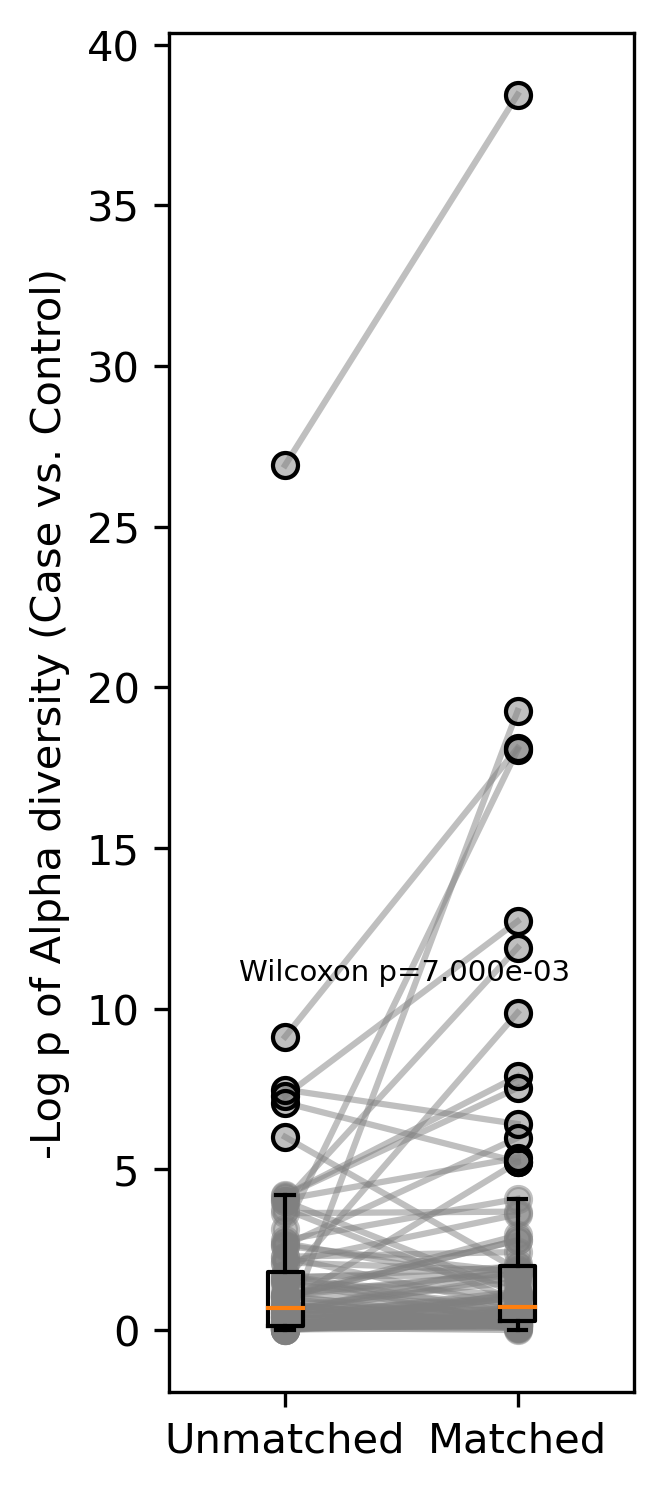

In [8]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    x = matched.loc[matched['Group']==0, 'distance']
    y = matched.loc[matched['Group']==1, 'distance']
    pairs = pairs.replace('NA_character_',np.nan)
    pairs=pairs.dropna(how='any')
    #print(pairs)
    pairs.to_csv(path+project+'/PSMLabel.csv')
    x_matched = matched.loc[pairs['Control'], 'distance']
    y_matched = matched.loc[pairs['Case'], 'distance']
    ps_changes = [-np.log10(stats.mannwhitneyu(x, y)[1]), -np.log10(stats.wilcoxon(x_matched, y_matched)[1])]
    # alpha : chao1, shannon, simpson, simpson_e
    metric = 'chao1'
    alphas = alpha_diversity(metric, microbiome.values, list(microbiome.index))
    x = alphas.loc[matched['Group']==0]
    y = alphas.loc[matched['Group']==1]
    x_matched = alphas.loc[pairs['Control']]
    y_matched = alphas.loc[pairs['Case']]
    
    result.append([project, ps_changes[0], ps_changes[1], 
                   -np.log10(stats.mannwhitneyu(x, y)[1]), -np.log10(stats.wilcoxon(x_matched, y_matched)[1])])
result = pd.DataFrame(result, columns=['Project', 'Delta_PS_Unmatched', 'Delta_PS_Matched', 'Unmatched', 'Matched'])

_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['Unmatched', 'Matched']], '-o', alpha=0.5, color='gray')
_ = plt.boxplot([result['Unmatched'], result['Matched']])
_ = plt.annotate('Wilcoxon p=%.3e'%round(stats.wilcoxon(result['Unmatched'], result['Matched'])[1], 3), (0.8, 10.9), fontsize=7)
_ = plt.ylabel('-Log p of Alpha diversity (Case vs. Control)')
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
#plt.savefig('../Results/3.Alpha多样性_boxplot.pdf',bbox_inches = 'tight')
_ = plt.show()

('相关统计', (0.2917838515647821, 0.005809676840681427))

(0.29900147206570715, 0.784111111326133, 1.0, 0.0)

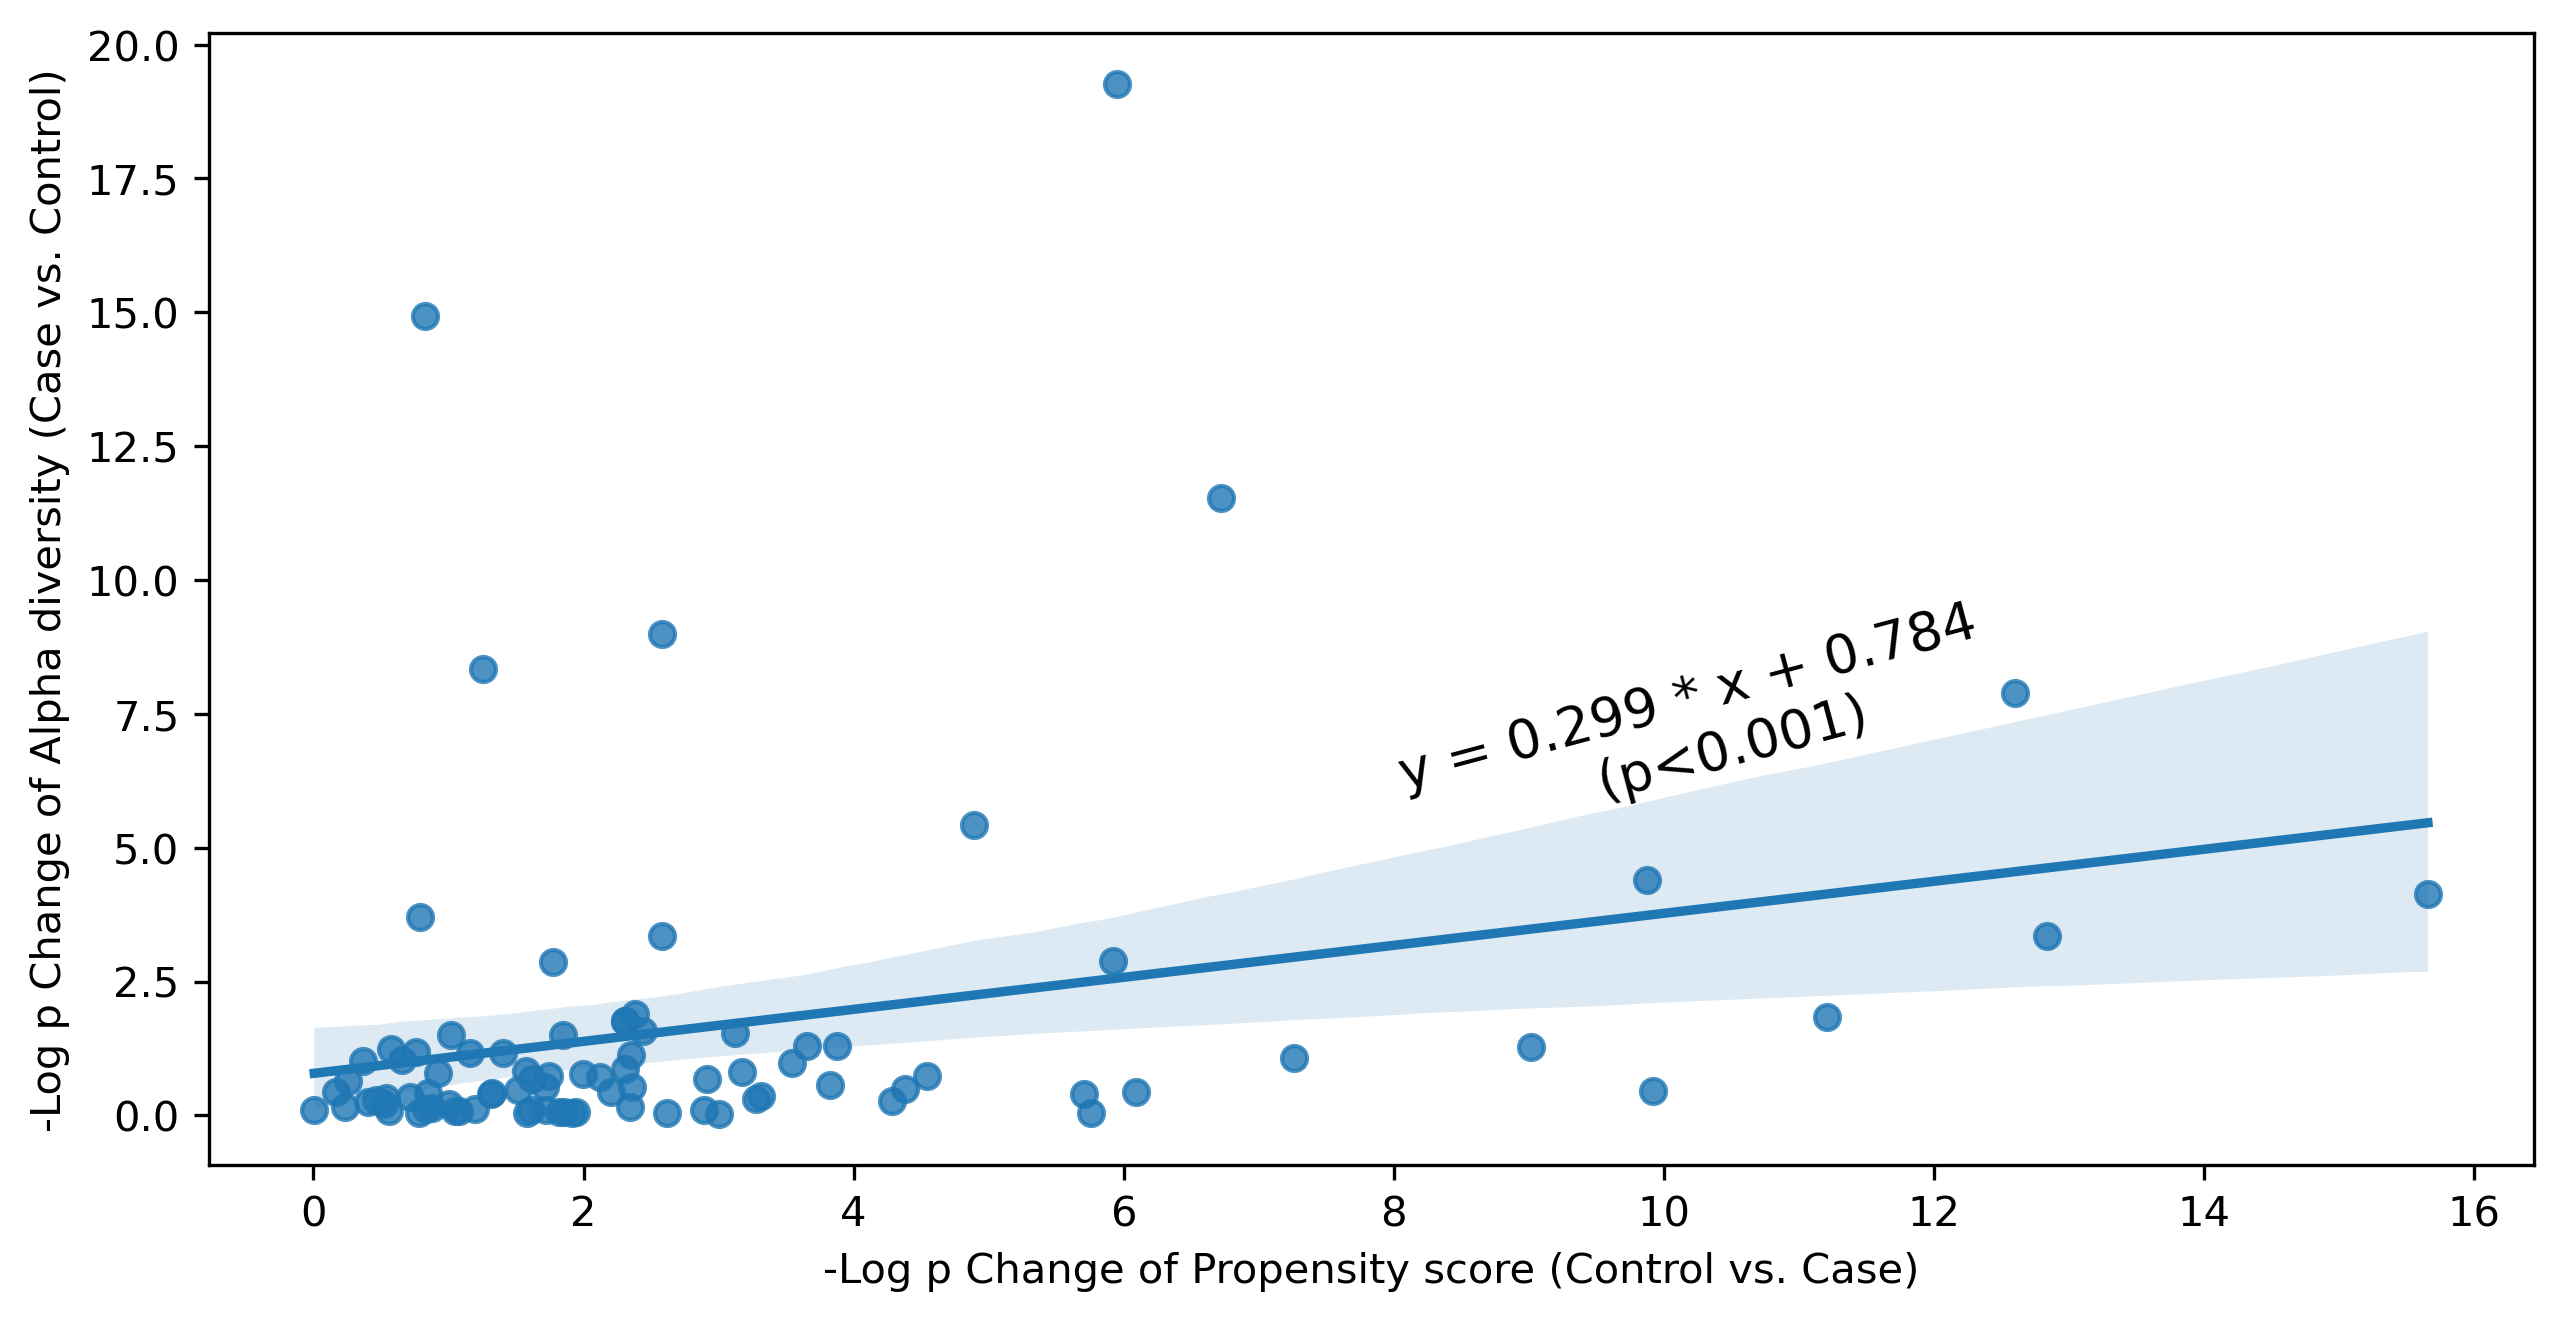

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Alpha_Change   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     8.003
Date:                Wed, 07 Dec 2022   Prob (F-statistic):            0.00581
Time:                        14:55:55   Log-Likelihood:                -221.32
No. Observations:                  88   AIC:                             446.6
Df Residuals:                      86   BIC:                             451.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7841      0.449      1.745      0.085      -0.109       1.677
PS_Change      0.2990      0.106      2.829      0.006       0.089       0.509
==============================================================================
Omnibus:                       97.444   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1027.976
Skew:                           3.695   Prob(JB):                    6.00e-224
Kurtosis:                      18.025   Cond. No.                         6.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
'相关统计', stats.pearsonr(np.abs(result['Delta_PS_Matched']-result['Delta_PS_Unmatched']), np.abs(result['Matched']-result['Unmatched']))
result['PS_Change'] = np.abs(result['Delta_PS_Matched']-result['Delta_PS_Unmatched']) 
result['Alpha_Change'] = np.abs(result['Matched']-result['Unmatched'])
_ = plt.figure(0, (10, 5), dpi=300)
p = sns.regplot(x="PS_Change", y="Alpha_Change", data=result)
slope, intercept, r_value, p_value, std_err = stats.linregress(x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata())
slope,intercept,r_value,p_value

_ = plt.annotate('y = '+str(round(slope, 3))+' * x + '+str(round(intercept, 3))+'\n           (p<0.001)', 
                 (8,5), fontsize=13, rotation=15)
_ = plt.xlabel('-Log p Change of Propensity score (Control vs. Case)')
_ = plt.ylabel('-Log p Change of Alpha diversity (Case vs. Control)')
#plt.savefig('../Results/3.Alpha多样性_相关性.pdf',bbox_inches = 'tight')
_ = plt.show()

X = result['PS_Change']
X = sm.add_constant(X)
y = result['Alpha_Change']
est=sm.OLS(y, X)
est=est.fit()
est.summary()

### 1.2 Beta——between samples

In [19]:
# distance : braycurtis, euclidean, correlation, cosine
dis_method = braycurtis
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    x = matched.loc[matched['Group']==0, 'distance']
    y = matched.loc[matched['Group']==1, 'distance']
    pairs = pairs.replace('NA_character_',np.nan)
    pairs=pairs.dropna(how='any')
    x_matched = matched.loc[pairs['Control'], 'distance']
    y_matched = matched.loc[pairs['Case'], 'distance']
    ps_changes = [-np.log10(stats.mannwhitneyu(x, y)[1]), -np.log10(stats.wilcoxon(x_matched, y_matched)[1])]
    ### Beta diversity
    distance_matrix = pd.DataFrame(np.zeros((microbiome.shape[0], microbiome.shape[0])), 
                               index=microbiome.index, columns=microbiome.index)
    distance_matrix.head(2)
    for i in distance_matrix:
        for j in distance_matrix:
            dis = dis_method(microbiome.loc[i, :], microbiome.loc[j, :])
            distance_matrix.loc[i, j] = 0.0 if pd.isnull(dis) else dis
    
    project, microbiome.isnull().sum().sum(), distance_matrix.isnull().sum().sum()
   
    unmatched_grouping = ['Control' if i in list(matched.loc[matched['Group']==0, :].index) else 'Case' for i in distance_matrix.index]
    dm = DistanceMatrix(distance_matrix.values, list(distance_matrix.index))
    p1 = anosim(dm, grouping=unmatched_grouping)['p-value']
    p2 = permanova(dm, grouping=unmatched_grouping)['p-value']
    ### 
    matched_smaples = list(set(pairs['Control'])|set(pairs['Case']))
    matched_grouping = ['Control' if i in list(pairs['Control']) else 'Case' for i in matched_smaples]
    dm = DistanceMatrix(distance_matrix.loc[matched_smaples, matched_smaples].values, matched_smaples)
    p3= anosim(dm, grouping=matched_grouping)['p-value']
    p4 = permanova(dm, grouping=matched_grouping)['p-value']
    result.append([project, ps_changes[0], ps_changes[1], -np.log10(p1), -np.log10(p2), -np.log10(p3), -np.log10(p4)])

result = pd.DataFrame(result, columns=['Project', 'Delta_PS_Unmatched', 'Delta_PS_Matched', 'ANOSIM_Unmatched', 
                                       'PERMANOVA_Unmatched', 'ANOSIM_Matched', 'PERMANOVA_Matched'])
result.head(2)
#result.to_csv('../Results/3. Beta_diversity_braycurtis.csv')

N2_031_008G1  N2_031_010G1  N2_031_012G1  N2_031_014G1  \
N2_031_008G1           0.0           0.0           0.0           0.0   
N2_031_010G1           0.0           0.0           0.0           0.0   

              N2_031_016G1  N2_031_018G1  N2_031_020G1  N2_031_021G1  \
N2_031_008G1           0.0           0.0           0.0           0.0   
N2_031_010G1           0.0           0.0           0.0           0.0   

              N2_031_023G1  N2_031_027G1  ...  S2_018_019G1  S2_018_020G1  \
N2_031_008G1           0.0           0.0  ...           0.0           0.0   
N2_031_010G1           0.0           0.0  ...           0.0           0.0   

              S2_018_021G1  S2_018_022G1  S2_018_023G1  S2_CON_000E1  \
N2_031_008G1           0.0           0.0           0.0           0.0   
N2_031_010G1           0.0           0.0           0.0           0.0   

              S2_CON_001E1  S2_CON_002E1  S2_CON_002E2  S2_CON_003E1  
N2_031_008G1           0.0           0.0           0.0           0.0  
N2_031_010G1           0.0           0.0           0.0           0.0  

[2 rows x 408 columns]

('08', 0, 0)

ES_001  ES_007  ES_010  ES_014  ES_017  ES_019  ES_024  ES_043  \
ES_001     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ES_007     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        ES_046  ES_048  ...  ES_116  ES_132  ES_137  ES_147  ES_158  ES_207  \
ES_001     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
ES_007     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        ES_208  ES_209  ES_210  ES_211  
ES_001     0.0     0.0     0.0     0.0  
ES_007     0.0     0.0     0.0     0.0  

[2 rows x 32 columns]

('09', 0, 0)

wHAXPI032581-18  wHAXPI032582-19  wHAXPI032583-21  \
wHAXPI032581-18              0.0              0.0              0.0   
wHAXPI032582-19              0.0              0.0              0.0   

                 wHAXPI032584-22  wHAXPI032585-23  wHAXPI032586-25  \
wHAXPI032581-18              0.0              0.0              0.0   
wHAXPI032582-19              0.0              0.0              0.0   

                 wHAXPI032587-26  wHAXPI032588-27  wHAXPI032589-28  \
wHAXPI032581-18              0.0              0.0              0.0   
wHAXPI032582-19              0.0              0.0              0.0   

                 wHAXPI032590-29  ...  wHAXPI034926-15  wHAXPI037144-8  \
wHAXPI032581-18              0.0  ...              0.0             0.0   
wHAXPI032582-19              0.0  ...              0.0             0.0   

                 wHAXPI037145-9  wHAXPI037146-11  wHAXPI037147-12  \
wHAXPI032581-18             0.0              0.0              0.0   
wHAXPI032582-19             0.0              0.0              0.0   

                 wHAXPI043592-8  wHAXPI043593-9  wHAXPI043594-11  \
wHAXPI032581-18             0.0             0.0              0.0   
wHAXPI032582-19             0.0             0.0              0.0   

                 wHAXPI047830-11  wHAXPI048670-90  
wHAXPI032581-18              0.0              0.0  
wHAXPI032582-19              0.0              0.0  

[2 rows x 171 columns]

('100', 0, 0)

ESS-0542  ESS-0452  ESS-0280  ESS-0184  ESS-0513  ESS-0476  \
ESS-0542       0.0       0.0       0.0       0.0       0.0       0.0   
ESS-0452       0.0       0.0       0.0       0.0       0.0       0.0   

          ESS-0359  ESS-0335  ESS-0316  ESS-0296  ...  ESS-0058  ESS-0053  \
ESS-0542       0.0       0.0       0.0       0.0  ...       0.0       0.0   
ESS-0452       0.0       0.0       0.0       0.0  ...       0.0       0.0   

          ESS-0044  ESS-0039  ESS-0035  ESS-0026  ESS-0020  ESS-0014  \
ESS-0542       0.0       0.0       0.0       0.0       0.0       0.0   
ESS-0452       0.0       0.0       0.0       0.0       0.0       0.0   

          ESS-0010  ESS-0005  
ESS-0542       0.0       0.0  
ESS-0452       0.0       0.0  

[2 rows x 100 columns]

('101', 0, 0)

WBE003  WBE004  WBE005  WBE006  WBE007  WBE008  WBE009  WBE010  \
WBE003     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
WBE004     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        WBE011  WBE012  ...  WBU011  WBU012  WBU013  WBU014  WBU015  WBU016  \
WBE003     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
WBE004     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        WBU017  WBU018  WBU019  WBU020  
WBE003     0.0     0.0     0.0     0.0  
WBE004     0.0     0.0     0.0     0.0  

[2 rows x 78 columns]

('11', 0, 0)

LD-Run2-11  LD-Run2-12  LD-Run2-13  LD-Run2-19  LD-Run2-20  \
LD-Run2-11         0.0         0.0         0.0         0.0         0.0   
LD-Run2-12         0.0         0.0         0.0         0.0         0.0   

            LD-Run2-24  LD-Run2-29  LD-Run2-36  LD-Run2-37  LD-Run1-01  ...  \
LD-Run2-11         0.0         0.0         0.0         0.0         0.0  ...   
LD-Run2-12         0.0         0.0         0.0         0.0         0.0  ...   

            LD-Run2-23  LD-Run2-25  LD-Run2-26  LD-Run2-27  LD-Run2-28  \
LD-Run2-11         0.0         0.0         0.0         0.0         0.0   
LD-Run2-12         0.0         0.0         0.0         0.0         0.0   

            LD-Run2-30  LD-Run2-32  LD-Run2-33  LD-Run2-34  LD-Run2-35  
LD-Run2-11         0.0         0.0         0.0         0.0         0.0  
LD-Run2-12         0.0         0.0         0.0         0.0         0.0  

[2 rows x 47 columns]

('15', 0, 0)

SID31009  SID31021  SID31030  SID31071  SID31112  SID31129  \
SID31009       0.0       0.0       0.0       0.0       0.0       0.0   
SID31021       0.0       0.0       0.0       0.0       0.0       0.0   

          SID31137  SID31160  SID31219  SID31233  ...  SID531424  SID531663  \
SID31009       0.0       0.0       0.0       0.0  ...        0.0        0.0   
SID31021       0.0       0.0       0.0       0.0  ...        0.0        0.0   

          SID532305  SID532749  SID532779  SID532796  SID532802  SID532826  \
SID31009        0.0        0.0        0.0        0.0        0.0        0.0   
SID31021        0.0        0.0        0.0        0.0        0.0        0.0   

          SID532832  SID532915  
SID31009        0.0        0.0  
SID31021        0.0        0.0  

[2 rows x 108 columns]

('18_1', 0, 0)

SID31004  SID31009  SID31021  SID31071  SID31112  SID31129  \
SID31004       0.0       0.0       0.0       0.0       0.0       0.0   
SID31009       0.0       0.0       0.0       0.0       0.0       0.0   

          SID31159  SID31160  SID31188  SID31219  ...  SID531424  SID531469  \
SID31004       0.0       0.0       0.0       0.0  ...        0.0        0.0   
SID31009       0.0       0.0       0.0       0.0  ...        0.0        0.0   

          SID531766  SID531775  SID532749  SID532779  SID532796  SID532802  \
SID31004        0.0        0.0        0.0        0.0        0.0        0.0   
SID31009        0.0        0.0        0.0        0.0        0.0        0.0   

          SID532826  SID532915  
SID31004        0.0        0.0  
SID31009        0.0        0.0  

[2 rows x 107 columns]

('18_2', 0, 0)

SID31004  SID31030  SID31137  SID31159  SID31188  SID31223  \
SID31004       0.0       0.0       0.0       0.0       0.0       0.0   
SID31030       0.0       0.0       0.0       0.0       0.0       0.0   

          SID31233  SID31237  SID31256  SID31275  ...  SID531361  SID531382  \
SID31004       0.0       0.0       0.0       0.0  ...        0.0        0.0   
SID31030       0.0       0.0       0.0       0.0  ...        0.0        0.0   

          SID531403  SID531416  SID531469  SID531663  SID531766  SID531775  \
SID31004        0.0        0.0        0.0        0.0        0.0        0.0   
SID31030        0.0        0.0        0.0        0.0        0.0        0.0   

          SID532305  SID532832  
SID31004        0.0        0.0  
SID31030        0.0        0.0  

[2 rows x 93 columns]

('18_3', 0, 0)

SP_344SPT_T016  SP_164SPT_T016  SP_162SPI_T016  \
SP_344SPT_T016             0.0             0.0             0.0   
SP_164SPT_T016             0.0             0.0             0.0   

                SP_282SPT_T016_R  SP_189SPI_T016  SP_383SPT_T016  \
SP_344SPT_T016               0.0             0.0             0.0   
SP_164SPT_T016               0.0             0.0             0.0   

                SP_384SPT_T016  SP_283SPI_T016  SP_161SPI_T016  \
SP_344SPT_T016             0.0             0.0             0.0   
SP_164SPT_T016             0.0             0.0             0.0   

                SP_241SPT_T016  ...  SP_222SPI_T016  SP_262SPI_T016  \
SP_344SPT_T016             0.0  ...             0.0             0.0   
SP_164SPT_T016             0.0  ...             0.0             0.0   

                SP_324SPT_T016  SP_284SPI_T016  SP_144SPI_T016  \
SP_344SPT_T016             0.0             0.0             0.0   
SP_164SPT_T016             0.0             0.0             0.0   

                SP_381SPI_T016  SP_343SPT_T016_R  SP_602SPI_T016  \
SP_344SPT_T016             0.0               0.0             0.0   
SP_164SPT_T016             0.0               0.0             0.0   

                SP_361SPT_T016  SP_122SPT_T016  
SP_344SPT_T016             0.0             0.0  
SP_164SPT_T016             0.0             0.0  

[2 rows x 90 columns]

('24_1', 0, 0)

SP_305SPI_T016  SP_283SPI_T016  SP_502SPI_T016  \
SP_305SPI_T016             0.0             0.0             0.0   
SP_283SPI_T016             0.0             0.0             0.0   

                SP_264SPI_T016  SP_281SPI_T016  SP_323SPI_T016  \
SP_305SPI_T016             0.0             0.0             0.0   
SP_283SPI_T016             0.0             0.0             0.0   

                SP_384SPI_T016  SP_285SPI_T016  SP_304SPI_T016  \
SP_305SPI_T016             0.0             0.0             0.0   
SP_283SPI_T016             0.0             0.0             0.0   

                SP_201SPI_T016  ...  SP_230SPI_T016  SP_389SPI_T016  \
SP_305SPI_T016             0.0  ...             0.0             0.0   
SP_283SPI_T016             0.0  ...             0.0             0.0   

                SP_282SPI_T016  SP_345SPI_T016  SP_222SPI_T016  \
SP_305SPI_T016             0.0             0.0             0.0   
SP_283SPI_T016             0.0             0.0             0.0   

                SP_262SPI_T016  SP_284SPI_T016  SP_381SPI_T016  \
SP_305SPI_T016             0.0             0.0             0.0   
SP_283SPI_T016             0.0             0.0             0.0   

                SP_322SPI_T016  SP_602SPI_T016  
SP_305SPI_T016             0.0             0.0  
SP_283SPI_T016             0.0             0.0  

[2 rows x 43 columns]

('24_2', 0, 0)

SP_344SPT_T016  SP_164SPT_T016  SP_162SPI_T016  \
SP_344SPT_T016             0.0             0.0             0.0   
SP_164SPT_T016             0.0             0.0             0.0   

                SP_282SPT_T016_R  SP_189SPI_T016  SP_305SPI_T016  \
SP_344SPT_T016               0.0             0.0             0.0   
SP_164SPT_T016               0.0             0.0             0.0   

                SP_383SPT_T016  SP_384SPT_T016  SP_161SPI_T016  \
SP_344SPT_T016             0.0             0.0             0.0   
SP_164SPT_T016             0.0             0.0             0.0   

                SP_241SPT_T016  ...  SP_361SPI_T016  SP_389SPI_T016  \
SP_344SPT_T016             0.0  ...             0.0             0.0   
SP_164SPT_T016             0.0  ...             0.0             0.0   

                SP_129SPT_T016  SP_345SPI_T016  SP_324SPT_T016  \
SP_344SPT_T016             0.0             0.0             0.0   
SP_164SPT_T016             0.0             0.0             0.0   

                SP_144SPI_T016  SP_322SPI_T016  SP_343SPT_T016_R  \
SP_344SPT_T016             0.0             0.0               0.0   
SP_164SPT_T016             0.0             0.0               0.0   

                SP_361SPT_T016  SP_122SPT_T016  
SP_344SPT_T016             0.0             0.0  
SP_164SPT_T016             0.0             0.0  

[2 rows x 93 columns]

('24_3', 0, 0)

GupDM_JP  GupDM_JG  GupDM_A4  GupDM_JM  GupDM_A13  GupDM_JK  \
GupDM_JP       0.0       0.0       0.0       0.0        0.0       0.0   
GupDM_JG       0.0       0.0       0.0       0.0        0.0       0.0   

          GupDM_JI  GupDM_A7  GupDM_A2  GupDM_A_11  ...  GupDM_HCS  GupDM_HCT  \
GupDM_JP       0.0       0.0       0.0         0.0  ...        0.0        0.0   
GupDM_JG       0.0       0.0       0.0         0.0  ...        0.0        0.0   

          GupDM_HCM  GupDM_HCN  GupDM_HCO  GupDM_HCP  GupDM_HP  GupDM_HS  \
GupDM_JP        0.0        0.0        0.0        0.0       0.0       0.0   
GupDM_JG        0.0        0.0        0.0        0.0       0.0       0.0   

          GupDM_HR  GupDM_HBR  
GupDM_JP       0.0        0.0  
GupDM_JG       0.0        0.0  

[2 rows x 60 columns]

('26', 0, 0)

SKST006_6_G102964  SKST006_7_G102965  SKST006_4_G102962  \
SKST006_6_G102964                0.0                0.0                0.0   
SKST006_7_G102965                0.0                0.0                0.0   

                   SKST006_5_G102963  SKST006_2_G102960  SKST006_3_G102961  \
SKST006_6_G102964                0.0                0.0                0.0   
SKST006_7_G102965                0.0                0.0                0.0   

                   SKST006_10_G102994  SKST006_1_G102959  SKST006_9_G103014  \
SKST006_6_G102964                 0.0                0.0                0.0   
SKST006_7_G102965                 0.0                0.0                0.0   

                   SKST027_3_G102945  ...  p8649_mo9  p8649_mo8  p8712_mo10  \
SKST006_6_G102964                0.0  ...        0.0        0.0         0.0   
SKST006_7_G102965                0.0  ...        0.0        0.0         0.0   

                   p8712_mo1  p8712_mo12  p8712_mo11  p8582_mo4  p8582_mo3  \
SKST006_6_G102964        0.0         0.0         0.0        0.0        0.0   
SKST006_7_G102965        0.0         0.0         0.0        0.0        0.0   

                   p8582_mo2  p8582_mo12  
SKST006_6_G102964        0.0         0.0  
SKST006_7_G102965        0.0         0.0  

[2 rows x 259 columns]

('27', 0, 0)

MG100208  MG100207  MG100206  MG100205  MG100204  MG100203  \
MG100208       0.0       0.0       0.0       0.0       0.0       0.0   
MG100207       0.0       0.0       0.0       0.0       0.0       0.0   

          MG100202  MG100201  MG100200  MG100199  ...  MG100162  MG100161  \
MG100208       0.0       0.0       0.0       0.0  ...       0.0       0.0   
MG100207       0.0       0.0       0.0       0.0  ...       0.0       0.0   

          MG100160  MG100159  MG100158  MG100157  MG100156  MG100155  \
MG100208       0.0       0.0       0.0       0.0       0.0       0.0   
MG100207       0.0       0.0       0.0       0.0       0.0       0.0   

          MG100154  MG100153  
MG100208       0.0       0.0  
MG100207       0.0       0.0  

[2 rows x 54 columns]

('28_1', 0, 0)

MG100180  MG100179  MG100178  MG100177  MG100176  MG100175  \
MG100180       0.0       0.0       0.0       0.0       0.0       0.0   
MG100179       0.0       0.0       0.0       0.0       0.0       0.0   

          MG100174  MG100173  MG100172  MG100171  ...  MG100134  MG100133  \
MG100180       0.0       0.0       0.0       0.0  ...       0.0       0.0   
MG100179       0.0       0.0       0.0       0.0  ...       0.0       0.0   

          MG100132  MG100131  MG100130  MG100129  MG100128  MG100127  \
MG100180       0.0       0.0       0.0       0.0       0.0       0.0   
MG100179       0.0       0.0       0.0       0.0       0.0       0.0   

          MG100126  MG100125  
MG100180       0.0       0.0  
MG100179       0.0       0.0  

[2 rows x 55 columns]

('28_2', 0, 0)

MG100208  MG100207  MG100206  MG100205  MG100204  MG100203  \
MG100208       0.0       0.0       0.0       0.0       0.0       0.0   
MG100207       0.0       0.0       0.0       0.0       0.0       0.0   

          MG100202  MG100201  MG100200  MG100199  ...  MG100134  MG100133  \
MG100208       0.0       0.0       0.0       0.0  ...       0.0       0.0   
MG100207       0.0       0.0       0.0       0.0  ...       0.0       0.0   

          MG100132  MG100131  MG100130  MG100129  MG100128  MG100127  \
MG100208       0.0       0.0       0.0       0.0       0.0       0.0   
MG100207       0.0       0.0       0.0       0.0       0.0       0.0   

          MG100126  MG100125  
MG100208       0.0       0.0  
MG100207       0.0       0.0  

[2 rows x 53 columns]

('28_3', 0, 0)

M01.1-V1-stool  M01.1-V2-stool  M01.1-V3-stool  \
M01.1-V1-stool             0.0             0.0             0.0   
M01.1-V2-stool             0.0             0.0             0.0   

                M01.2-V1-stool  M01.2-V2-stool  M01.2-V3-stool  \
M01.1-V1-stool             0.0             0.0             0.0   
M01.1-V2-stool             0.0             0.0             0.0   

                M01.3-V1-stool  M01.3-V2-stool  M01.3-V3-stool  \
M01.1-V1-stool             0.0             0.0             0.0   
M01.1-V2-stool             0.0             0.0             0.0   

                M01.4-V1-stool  ...  M04.3-V1-stool  M04.3-V3-stool  \
M01.1-V1-stool             0.0  ...             0.0             0.0   
M01.1-V2-stool             0.0  ...             0.0             0.0   

                M04.4-V1-stool  M04.4-V3-stool  M04.5-V1-stool  \
M01.1-V1-stool             0.0             0.0             0.0   
M01.1-V2-stool             0.0             0.0             0.0   

                M04.5-V2-stool  M04.5-V3-stool  M04.6-V1-stool  \
M01.1-V1-stool             0.0             0.0             0.0   
M01.1-V2-stool             0.0             0.0             0.0   

                M04.6-V2-stool  M04.6-V3-stool  
M01.1-V1-stool             0.0             0.0  
M01.1-V2-stool             0.0             0.0  

[2 rows x 53 columns]

('30', 0, 0)

CSM5FZ3N_P  CSM5FZ3R_P  CSM5YRY7_P  CSM5FZ3V_P  CSM5FZ4C_P  \
CSM5FZ3N_P         0.0         0.0         0.0         0.0         0.0   
CSM5FZ3R_P         0.0         0.0         0.0         0.0         0.0   

            CSM5MCVD_P  CSM5MCVF_P  CSM5MCVV_P  CSM5MCWI_P  CSM5MCXD  ...  \
CSM5FZ3N_P         0.0         0.0         0.0         0.0       0.0  ...   
CSM5FZ3R_P         0.0         0.0         0.0         0.0       0.0  ...   

            PSMA266Y  PSMA2671  PSMA2675  PSMA269S  PSMA269W  PSMA26A1  \
CSM5FZ3N_P       0.0       0.0       0.0       0.0       0.0       0.0   
CSM5FZ3R_P       0.0       0.0       0.0       0.0       0.0       0.0   

            PSMA26A3  PSMB4MC1  PSMB4MC3  PSMB4MC5  
CSM5FZ3N_P       0.0       0.0       0.0       0.0  
CSM5FZ3R_P       0.0       0.0       0.0       0.0  

[2 rows x 1627 columns]

('36', 0, 0)

HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0   

                                                   HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                               0.0   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                0.0   

                                                   HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                               0.0   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                0.0   

                                                   HMP2_J00826_M_ST_T0_B0_0120_ZN9YTFN-1011_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00827_M_ST_T0_B0_0120_ZN9YTFN-1012_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00827_M_ST_T0_B0_0120_ZN9YTFN-1012_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00828_M_ST_T0_B0_0120_ZN9YTFN-1013_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00828_M_ST_T0_B0_0120_ZN9YTFN-1013_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00829_M_ST_T0_B0_0120_ZN9YTFN-1014_AC9387ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0     
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0     

                                                   HMP2_J00829_M_ST_T0_B0_0120_ZN9YTFN-1014_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   ...  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX  ...   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX   ...   

                                                   HMP2_J43837_M_ST_T0_B0_0120_ZVBQY1N-6013_C93B2ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J43838_M_ST_T0_B0_0120_ZVBQY1N-6014_C93B2ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J43839_M_ST_T0_B0_0120_ZVBQY1N-6015_C93B

('37_1', 0, 0)

HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0   

                                                   HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                               0.0   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                0.0   

                                                   HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                               0.0   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                0.0   

                                                   HMP2_J00826_M_ST_T0_B0_0120_ZN9YTFN-1011_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00827_M_ST_T0_B0_0120_ZN9YTFN-1012_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00827_M_ST_T0_B0_0120_ZN9YTFN-1012_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00828_M_ST_T0_B0_0120_ZN9YTFN-1013_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00828_M_ST_T0_B0_0120_ZN9YTFN-1013_HA986ADXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J00829_M_ST_T0_B0_0120_ZN9YTFN-1014_AC9387ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0     
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0     

                                                   HMP2_J00829_M_ST_T0_B0_0120_ZN9YTFN-1014_C8GAAANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   ...  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX  ...   
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX   ...   

                                                   HMP2_J43837_M_ST_T0_B0_0120_ZVBQY1N-6013_C93B2ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J43838_M_ST_T0_B0_0120_ZVBQY1N-6014_C93B2ANXX  \
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_AC9387ANXX                                                0.0    
HMP2_J00825_M_ST_T0_B0_0120_ZN9YTFN-01_C8GAAANXX                                                 0.0    

                                                   HMP2_J43839_M_ST_T0_B0_0120_ZVBQY1N-6015_C93B

('37_2', 0, 0)

HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                               0.0   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                               0.0   

                                                  HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                               0.0   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                               0.0   

                                                  HMP2_J00837_M_ST_T0_B0_0120_ZLZQMEV-1012_C93B2ANXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                                0.0    
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                                0.0    

                                                  HMP2_J00839_M_ST_T0_B0_0120_ZLZQMEV-1015_C93B2ANXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                                0.0    
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                                0.0    

                                                  HMP2_J00839_M_ST_T0_B0_0120_ZLZQMEV-1015_HA986ADXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                                0.0    
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                                0.0    

                                                  HMP2_J00879_M_ST_T0_B0_0120_ZMBH10Z-01_AC9387ANXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                                0.0   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                                0.0   

                                                  HMP2_J00879_M_ST_T0_B0_0120_ZMBH10Z-01_C8GAAANXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                               0.0   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                               0.0   

                                                  HMP2_J00879_M_ST_T0_B0_0120_ZMBH10Z-01_HA986ADXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                               0.0   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                               0.0   

                                                  HMP2_J00880_M_ST_T0_B0_0120_ZMBH10Z-02_AC9387ANXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                                0.0   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                                0.0   

                                                  HMP2_J00880_M_ST_T0_B0_0120_ZMBH10Z-02_C8GAAANXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                               0.0   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                               0.0   

                                                  ...  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX  ...   
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX  ...   

                                                  HMP2_J15246_M_ST_T0_B0_0120_ZVGW5FI-02_GES15-03641  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                                0.0    
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                                0.0    

                                                  HMP2_J16531_M_ST_T0_B0_0120_ZVGW5FI-03_HK3LNBGXX_S2  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX                                                0.0     
HMP2_J00836_M_ST_T0_B0_0120_ZLZQMEV-03_HA986ADXX                                                0.0     

                                                  HMP2_J35165_M_ST_T0_B0_0120_ZMBH10Z-04_HBB8WADXX  \
HMP2_J00835_M_ST_T0_B0_0120_ZLZQMEV-01_HA986ADXX     

('37_3', 0, 0)

S101_a_WGS  S102_a_WGS  S103_a_WGS  S117_a_WGS  S119_a_WGS  \
S101_a_WGS         0.0         0.0         0.0         0.0         0.0   
S102_a_WGS         0.0         0.0         0.0         0.0         0.0   

            S128_a_WGS  S130_a_WGS  S132_a_WGS  S134_a_WGS  S138_a_WGS  ...  \
S101_a_WGS         0.0         0.0         0.0         0.0         0.0  ...   
S102_a_WGS         0.0         0.0         0.0         0.0         0.0  ...   

            S71_a_WGS  S72_a_WGS  S73_a_WGS  S79_a_WGS  S80_a_WGS  S81_a_WGS  \
S101_a_WGS        0.0        0.0        0.0        0.0        0.0        0.0   
S102_a_WGS        0.0        0.0        0.0        0.0        0.0        0.0   

            S82_a_WGS  S83_a_WGS  S84_a_WGS  S87_a_WGS  
S101_a_WGS        0.0        0.0        0.0        0.0  
S102_a_WGS        0.0        0.0        0.0        0.0  

[2 rows x 94 columns]

('38', 0, 0)

SAMEA104142324  SAMEA104142316  SAMEA104142314  \
SAMEA104142324             0.0             0.0             0.0   
SAMEA104142316             0.0             0.0             0.0   

                SAMEA104142312  SAMEA104142471  SAMEA104142470  \
SAMEA104142324             0.0             0.0             0.0   
SAMEA104142316             0.0             0.0             0.0   

                SAMEA104142469  SAMEA104142468  SAMEA104142467  \
SAMEA104142324             0.0             0.0             0.0   
SAMEA104142316             0.0             0.0             0.0   

                SAMEA104142466  ...  SAMEA104142365  SAMEA104142366  \
SAMEA104142324             0.0  ...             0.0             0.0   
SAMEA104142316             0.0  ...             0.0             0.0   

                SAMEA104142367  SAMEA104142368  SAMEA104142369  \
SAMEA104142324             0.0             0.0             0.0   
SAMEA104142316             0.0             0.0             0.0   

                SAMEA104142370  SAMEA104142371  SAMEA104142372  \
SAMEA104142324             0.0             0.0             0.0   
SAMEA104142316             0.0             0.0             0.0   

                SAMEA104142373  SAMEA104142374  
SAMEA104142324             0.0             0.0  
SAMEA104142316             0.0             0.0  

[2 rows x 385 columns]

('39', 0, 0)

S112  S118  S121  S126  S127  S131  S137  S141  S143  S144  ...  S628  \
S112   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
S118   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      S638  S640  S643  S646  S655  S77  S80  S88  S92  
S112   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  
S118   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  

[2 rows x 92 columns]

('40_1', 0, 0)

S112  S131  S144  S158  S186  S200  S205  S227  S229  S235  ...  S589  \
S112   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
S131   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      S591  S598  S60  S600  S602  S604  S638  S640  S646  
S112   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
S131   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[2 rows x 102 columns]

('40_2', 0, 0)

S118  S121  S126  S127  S137  S141  S143  S146  S153  S155  ...  S614  \
S118   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
S121   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      S617  S618  S628  S643  S655  S77  S80  S88  S92  
S118   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  
S121   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  

[2 rows x 96 columns]

('40_3', 0, 0)

DY.401.D01  DY.404.D01  DY.405.D01  DY.406.D01  DY.407.D01  \
DY.401.D01         0.0         0.0         0.0         0.0         0.0   
DY.404.D01         0.0         0.0         0.0         0.0         0.0   

            DY.408.D01  DY.409.D01  DY.411.D01  DY.419.D01  DY.501.D01  ...  \
DY.401.D01         0.0         0.0         0.0         0.0         0.0  ...   
DY.404.D01         0.0         0.0         0.0         0.0         0.0  ...   

            DY.509.D01  DY.510.D01  DY.511.D01  DY.512.D01  DY.513.D01  \
DY.401.D01         0.0         0.0         0.0         0.0         0.0   
DY.404.D01         0.0         0.0         0.0         0.0         0.0   

            DY.514.D01  DY.515.D01  DY.516.D01  DY.517.D01  DY.518.D01  
DY.401.D01         0.0         0.0         0.0         0.0         0.0  
DY.404.D01         0.0         0.0         0.0         0.0         0.0  

[2 rows x 27 columns]

('43', 0, 0)

PRJNA231909.3105829  PRJNA231909.3108874  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3108875  PRJNA231909.3113669  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3114784  PRJNA231909.3111969  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3111970  PRJNA231909.3112924  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3112925  PRJNA231909.3113339  ...  \
PRJNA231909.3105829                  0.0                  0.0  ...   
PRJNA231909.3108874                  0.0                  0.0  ...   

                     PRJNA231909.3115643  PRJNA231909.3115644  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3115646  PRJNA231909.3102986  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3107336  PRJNA231909.3115087  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3110226  PRJNA231909.3112348  \
PRJNA231909.3105829                  0.0                  0.0   
PRJNA231909.3108874                  0.0                  0.0   

                     PRJNA231909.3113035  PRJNA231909.3114185  
PRJNA231909.3105829                  0.0                  0.0  
PRJNA231909.3108874                  0.0                  0.0  

[2 rows x 120 columns]

('44', 0, 0)

MH0290  MH0336  MH0340  NLF002-IE  NLF009-IE  NLM009-IE  NLM025-IE  \
MH0290     0.0     0.0     0.0        0.0        0.0        0.0        0.0   
MH0336     0.0     0.0     0.0        0.0        0.0        0.0        0.0   

        NOF002-IE  NOF007-IE  NOF013-IE  ...  V1.UC40-1  V1.UC47-4  V1.UC54-4  \
MH0290        0.0        0.0        0.0  ...        0.0        0.0        0.0   
MH0336        0.0        0.0        0.0  ...        0.0        0.0        0.0   

        V1.UC56-1  V1.UC58-4  V1.UC59-0  V1.UC59-4  V1.UC60-0  V1.UC63-0  \
MH0290        0.0        0.0        0.0        0.0        0.0        0.0   
MH0336        0.0        0.0        0.0        0.0        0.0        0.0   

        V1.UC64-0  
MH0290        0.0  
MH0336        0.0  

[2 rows x 150 columns]

('48_1', 0, 0)

MH0271  MH0339  MH0346  MH0355  MH0362  MH0364  MH0365  MH0368  \
MH0271     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
MH0339     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        MH0369  MH0371  ...  V1.UC40-1  V1.UC47-4  V1.UC54-4  V1.UC56-1  \
MH0271     0.0     0.0  ...        0.0        0.0        0.0        0.0   
MH0339     0.0     0.0  ...        0.0        0.0        0.0        0.0   

        V1.UC58-4  V1.UC59-0  V1.UC59-4  V1.UC60-0  V1.UC63-0  V1.UC64-0  
MH0271        0.0        0.0        0.0        0.0        0.0        0.0  
MH0339        0.0        0.0        0.0        0.0        0.0        0.0  

[2 rows x 171 columns]

('48_2', 0, 0)

DLF005-IE  DLM006-IE  DOM005-IE  DOM017-IE  MH0192  MH0221  MH0222  \
DLF005-IE        0.0        0.0        0.0        0.0     0.0     0.0     0.0   
DLM006-IE        0.0        0.0        0.0        0.0     0.0     0.0     0.0   

           MH0234  MH0238  MH0245  ...  V1.UC40-1  V1.UC47-4  V1.UC54-4  \
DLF005-IE     0.0     0.0     0.0  ...        0.0        0.0        0.0   
DLM006-IE     0.0     0.0     0.0  ...        0.0        0.0        0.0   

           V1.UC56-1  V1.UC58-4  V1.UC59-0  V1.UC59-4  V1.UC60-0  V1.UC63-0  \
DLF005-IE        0.0        0.0        0.0        0.0        0.0        0.0   
DLM006-IE        0.0        0.0        0.0        0.0        0.0        0.0   

           V1.UC64-0  
DLF005-IE        0.0  
DLM006-IE        0.0  

[2 rows x 219 columns]

('48_3', 0, 0)

DLF005-IE  DLM006-IE  DOM005-IE  DOM017-IE  MH0192  MH0221  MH0222  \
DLF005-IE        0.0        0.0        0.0        0.0     0.0     0.0     0.0   
DLM006-IE        0.0        0.0        0.0        0.0     0.0     0.0     0.0   

           MH0234  MH0238  MH0245  ...  MH0393  MH0394  MH0395  MH0396  \
DLF005-IE     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
DLM006-IE     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

           MH0397  MH0398  MH0399  MH0400  MH0401  MH0402  
DLF005-IE     0.0     0.0     0.0     0.0     0.0     0.0  
DLM006-IE     0.0     0.0     0.0     0.0     0.0     0.0  

[2 rows x 110 columns]

('48_4', 0, 0)

MH0271  MH0290  MH0336  MH0339  MH0340  MH0346  MH0355  MH0362  \
MH0271     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
MH0290     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        MH0364  MH0365  ...  MH0397  MH0399  MH0402  NLF002-IE  NLF009-IE  \
MH0271     0.0     0.0  ...     0.0     0.0     0.0        0.0        0.0   
MH0290     0.0     0.0  ...     0.0     0.0     0.0        0.0        0.0   

        NLM009-IE  NLM025-IE  NOF002-IE  NOF007-IE  NOF013-IE  
MH0271        0.0        0.0        0.0        0.0        0.0  
MH0290        0.0        0.0        0.0        0.0        0.0  

[2 rows x 41 columns]

('48_5', 0, 0)

DLF005-IE  DLM006-IE  DOM005-IE  DOM017-IE  MH0192  MH0221  MH0222  \
DLF005-IE        0.0        0.0        0.0        0.0     0.0     0.0     0.0   
DLM006-IE        0.0        0.0        0.0        0.0     0.0     0.0     0.0   

           MH0234  MH0238  MH0245  ...  MH0398  MH0400  MH0401  NLF002-IE  \
DLF005-IE     0.0     0.0     0.0  ...     0.0     0.0     0.0        0.0   
DLM006-IE     0.0     0.0     0.0  ...     0.0     0.0     0.0        0.0   

           NLF009-IE  NLM009-IE  NLM025-IE  NOF002-IE  NOF007-IE  NOF013-IE  
DLF005-IE        0.0        0.0        0.0        0.0        0.0        0.0  
DLM006-IE        0.0        0.0        0.0        0.0        0.0        0.0  

[2 rows x 89 columns]

('48_6', 0, 0)

nHF511704  nHM512705  nHM611708  nHF611710  nHM511712  nHM410714  \
nHF511704        0.0        0.0        0.0        0.0        0.0        0.0   
nHM512705        0.0        0.0        0.0        0.0        0.0        0.0   

           nHM511615  nHM412716  nHM511717  nHF411719  ...  H3M513141  \
nHF511704        0.0        0.0        0.0        0.0  ...        0.0   
nHM512705        0.0        0.0        0.0        0.0  ...        0.0   

           H3M514142  H3M514143  H3M514144  H3M616848  H3M617849  H3M516751  \
nHF511704        0.0        0.0        0.0        0.0        0.0        0.0   
nHM512705        0.0        0.0        0.0        0.0        0.0        0.0   

           H3M616753  H3M516154  H2M514107  
nHF511704        0.0        0.0        0.0  
nHM512705        0.0        0.0        0.0  

[2 rows x 140 columns]

('49_1', 0, 0)

H1M514901  H1M413802  H1M513803  H1M513804  H1M414905  H1M513606  \
H1M514901        0.0        0.0        0.0        0.0        0.0        0.0   
H1M413802        0.0        0.0        0.0        0.0        0.0        0.0   

           H1M513807  H1M512808  H1M412809  H1M513810  ...  H3M513141  \
H1M514901        0.0        0.0        0.0        0.0  ...        0.0   
H1M413802        0.0        0.0        0.0        0.0  ...        0.0   

           H3M514142  H3M514143  H3M514144  H3M616848  H3M617849  H3M516751  \
H1M514901        0.0        0.0        0.0        0.0        0.0        0.0   
H1M413802        0.0        0.0        0.0        0.0        0.0        0.0   

           H3M616753  H3M516154  H2M514107  
H1M514901        0.0        0.0        0.0  
H1M413802        0.0        0.0        0.0  

[2 rows x 155 columns]

('49_2', 0, 0)

nHF511704  nHM512705  nHM611708  nHF611710  nHM511712  nHM410714  \
nHF511704        0.0        0.0        0.0        0.0        0.0        0.0   
nHM512705        0.0        0.0        0.0        0.0        0.0        0.0   

           nHM511615  nHM412716  nHM511717  nHF411719  ...  H1M513747  \
nHF511704        0.0        0.0        0.0        0.0  ...        0.0   
nHM512705        0.0        0.0        0.0        0.0  ...        0.0   

           H1M213648  H1M513852  H1M512853  H1M512854  H1M512855  H2M414940  \
nHF511704        0.0        0.0        0.0        0.0        0.0        0.0   
nHM512705        0.0        0.0        0.0        0.0        0.0        0.0   

           nHM511825  nHM612836  nHM412840  
nHF511704        0.0        0.0        0.0  
nHM512705        0.0        0.0        0.0  

[2 rows x 97 columns]

('49_3', 0, 0)

FAT_DON_19-22-0-0  FAT_020-22-14-0  FAT_020-22-2-0  \
FAT_DON_19-22-0-0                0.0              0.0             0.0   
FAT_020-22-14-0                  0.0              0.0             0.0   

                   FAT_020-22-42-0  FAT_020-22-84-0  FAT_DON_8-22-0-0  \
FAT_DON_19-22-0-0              0.0              0.0               0.0   
FAT_020-22-14-0                0.0              0.0               0.0   

                   FAT_008-22-14-0  FAT_008-22-2-0  FAT_008-22-42-0  \
FAT_DON_19-22-0-0              0.0             0.0              0.0   
FAT_020-22-14-0                0.0             0.0              0.0   

                   FAT_008-22-84-0  ...  FAT_010-22-42-0  FAT_010-22-84-0  \
FAT_DON_19-22-0-0              0.0  ...              0.0              0.0   
FAT_020-22-14-0                0.0  ...              0.0              0.0   

                   FAT_024-22-14-0  FAT_024-22-2-0  FAT_024-22-42-0  \
FAT_DON_19-22-0-0              0.0             0.0              0.0   
FAT_020-22-14-0                0.0             0.0              0.0   

                   FAT_024-22-84-0  FAT_012-22-14-0  FAT_012-22-2-0  \
FAT_DON_19-22-0-0              0.0              0.0             0.0   
FAT_020-22-14-0                0.0              0.0             0.0   

                   FAT_012-22-42-0  FAT_012-22-84-0  
FAT_DON_19-22-0-0              0.0              0.0  
FAT_020-22-14-0                0.0              0.0  

[2 rows x 45 columns]

('50_1', 0, 0)

FAT_020-22-0-0  FAT_020-22-14-0  FAT_020-22-2-0  \
FAT_020-22-0-0              0.0              0.0             0.0   
FAT_020-22-14-0             0.0              0.0             0.0   

                 FAT_020-22-42-0  FAT_020-22-84-0  FAT_008-22-0-0  \
FAT_020-22-0-0               0.0              0.0             0.0   
FAT_020-22-14-0              0.0              0.0             0.0   

                 FAT_008-22-14-0  FAT_008-22-2-0  FAT_008-22-42-0  \
FAT_020-22-0-0               0.0             0.0              0.0   
FAT_020-22-14-0              0.0             0.0              0.0   

                 FAT_008-22-84-0  ...  FAT_024-22-0-0  FAT_024-22-14-0  \
FAT_020-22-0-0               0.0  ...             0.0              0.0   
FAT_020-22-14-0              0.0  ...             0.0              0.0   

                 FAT_024-22-2-0  FAT_024-22-42-0  FAT_024-22-84-0  \
FAT_020-22-0-0              0.0              0.0              0.0   
FAT_020-22-14-0             0.0              0.0              0.0   

                 FAT_012-22-0-0  FAT_012-22-14-0  FAT_012-22-2-0  \
FAT_020-22-0-0              0.0              0.0             0.0   
FAT_020-22-14-0             0.0              0.0             0.0   

                 FAT_012-22-42-0  FAT_012-22-84-0  
FAT_020-22-0-0               0.0              0.0  
FAT_020-22-14-0              0.0              0.0  

[2 rows x 50 columns]

('50_2', 0, 0)

FAT_DON_19-22-0-0  FAT_020-22-0-0  FAT_DON_8-22-0-0  \
FAT_DON_19-22-0-0                0.0             0.0               0.0   
FAT_020-22-0-0                   0.0             0.0               0.0   

                   FAT_008-22-0-0  FAT_DON_11-22-0-4  FAT_DON_11-22-0-5  \
FAT_DON_19-22-0-0             0.0                0.0                0.0   
FAT_020-22-0-0                0.0                0.0                0.0   

                   FAT_DON_11-22-0-6  FAT_015-22-0-0  FAT_014-22-0-0  \
FAT_DON_19-22-0-0                0.0             0.0             0.0   
FAT_020-22-0-0                   0.0             0.0             0.0   

                   FAT_006-22-0-0  FAT_023-22-0-0  FAT_017-22-0-0  \
FAT_DON_19-22-0-0             0.0             0.0             0.0   
FAT_020-22-0-0                0.0             0.0             0.0   

                   FAT_010-22-0-0  FAT_024-22-0-0  FAT_012-22-0-0  
FAT_DON_19-22-0-0             0.0             0.0             0.0  
FAT_020-22-0-0                0.0             0.0             0.0

('50_3', 0, 0)

SID0002_gti  SID0004_cle  SID0006_evh  SID0008_kcu  SID0009_rhg  \
SID0002_gti          0.0          0.0          0.0          0.0          0.0   
SID0004_cle          0.0          0.0          0.0          0.0          0.0   

             SID0011_vkb  SID0012_qdz  SID0013_eop  SID0014_cps  SID0017_mqf  \
SID0002_gti          0.0          0.0          0.0          0.0          0.0   
SID0004_cle          0.0          0.0          0.0          0.0          0.0   

             ...  SID5566_wwo  SID5570_qby  SID5577_ytn  SID5579_bce  \
SID0002_gti  ...          0.0          0.0          0.0          0.0   
SID0004_cle  ...          0.0          0.0          0.0          0.0   

             SID5581_yad  SID5584_vix  SID5627_irb  SID5631_soh  SID5634_lel  \
SID0002_gti          0.0          0.0          0.0          0.0          0.0   
SID0004_cle          0.0          0.0          0.0          0.0          0.0   

             SID5639_uuc  
SID0002_gti          0.0  
SID0004_cle          0.0  

[2 rows x 45 columns]

('54_1', 0, 0)

SID0002_gti  SID0004_cle  SID0005_aaf  SID0008_kcu  SID0009_rhg  \
SID0002_gti          0.0          0.0          0.0          0.0          0.0   
SID0004_cle          0.0          0.0          0.0          0.0          0.0   

             SID0011_vkb  SID0012_qdz  SID0013_eop  SID0014_cps  SID0018_fze  \
SID0002_gti          0.0          0.0          0.0          0.0          0.0   
SID0004_cle          0.0          0.0          0.0          0.0          0.0   

             ...  SID5584_vix  SID5625_bnh  SID5627_irb  SID5629_hiu  \
SID0002_gti  ...          0.0          0.0          0.0          0.0   
SID0004_cle  ...          0.0          0.0          0.0          0.0   

             SID5630_kod  SID5631_soh  SID5634_lel  SID5636_prt  SID5639_uuc  \
SID0002_gti          0.0          0.0          0.0          0.0          0.0   
SID0004_cle          0.0          0.0          0.0          0.0          0.0   

             SID5640_ijm  
SID0002_gti          0.0  
SID0004_cle          0.0  

[2 rows x 77 columns]

('54_2', 0, 0)

SID0005_aaf  SID0006_evh  SID0017_mqf  SID0018_fze  SID0020_jhi  \
SID0005_aaf          0.0          0.0          0.0          0.0          0.0   
SID0006_evh          0.0          0.0          0.0          0.0          0.0   

             SID1005_aae  SID1006_aaf  SID1012_aal  SID1019_aas  SID1022_aav  \
SID0005_aaf          0.0          0.0          0.0          0.0          0.0   
SID0006_evh          0.0          0.0          0.0          0.0          0.0   

             ...  SID5564_meq  SID5571_lgi  SID5572_xty  SID5574_yeb  \
SID0005_aaf  ...          0.0          0.0          0.0          0.0   
SID0006_evh  ...          0.0          0.0          0.0          0.0   

             SID5578_fjg  SID5625_bnh  SID5629_hiu  SID5630_kod  SID5636_prt  \
SID0005_aaf          0.0          0.0          0.0          0.0          0.0   
SID0006_evh          0.0          0.0          0.0          0.0          0.0   

             SID5640_ijm  
SID0005_aaf          0.0  
SID0006_evh          0.0  

[2 rows x 50 columns]

('54_3', 0, 0)

ESS-0542  ESS-0452  ESS-0280  ESS-0184  ESS-0513  ESS-0476  \
ESS-0542       0.0       0.0       0.0       0.0       0.0       0.0   
ESS-0452       0.0       0.0       0.0       0.0       0.0       0.0   

          ESS-0359  ESS-0335  ESS-0316  ESS-0296  ...  ESS-0058  ESS-0053  \
ESS-0542       0.0       0.0       0.0       0.0  ...       0.0       0.0   
ESS-0452       0.0       0.0       0.0       0.0  ...       0.0       0.0   

          ESS-0044  ESS-0039  ESS-0035  ESS-0026  ESS-0020  ESS-0014  \
ESS-0542       0.0       0.0       0.0       0.0       0.0       0.0   
ESS-0452       0.0       0.0       0.0       0.0       0.0       0.0   

          ESS-0010  ESS-0005  
ESS-0542       0.0       0.0  
ESS-0452       0.0       0.0  

[2 rows x 100 columns]

('58', 0, 0)

MH0001  MH0002  MH0003  MH0004  MH0005  MH0006  MH0007  MH0008  \
MH0001     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
MH0002     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        MH0009  MH0010  ...  V1_UC55_4  V1_UC56_0  V1_UC57_0  V1_UC58_0  \
MH0001     0.0     0.0  ...        0.0        0.0        0.0        0.0   
MH0002     0.0     0.0  ...        0.0        0.0        0.0        0.0   

        V1_UC6_0  V1_UC61_0  V1_UC62_0  V1_UC7_0  V1_UC8_0  V1_UC9_0  
MH0001       0.0        0.0        0.0       0.0       0.0       0.0  
MH0002       0.0        0.0        0.0       0.0       0.0       0.0  

[2 rows x 396 columns]

('59', 0, 0)

CON-001  CON-002  CON-003  CON-004  CON-005  CON-006  CON-007  \
CON-001      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
CON-002      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

         CON-008  CON-009  CON-010  ...  T2D-098  T2D-099  T2D-100  T2D-101  \
CON-001      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
CON-002      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

         T2D-102  T2D-103  T2D-104  T2D-105  T2D-106  T2D-107  
CON-001      0.0      0.0      0.0      0.0      0.0      0.0  
CON-002      0.0      0.0      0.0      0.0      0.0      0.0  

[2 rows x 344 columns]

('68', 0, 0)

HD-1  HD-10  HD-11  HD-12  HD-13  HD-14  HD-15  HD-16  HD-17  HD-18  \
HD-1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
HD-10   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  LV-23  LV-24  LV-25  LV-3  LV-4  LV-5  LV-6  LV-7  LV-8  LV-9  
HD-1   ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
HD-10  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[2 rows x 237 columns]

('69', 0, 0)

P10E0  P10E7  P10E90  P11E0  P11E7  P11E90  P12E0  P12E7  P12E90  \
P10E0    0.0    0.0     0.0    0.0    0.0     0.0    0.0    0.0     0.0   
P10E7    0.0    0.0     0.0    0.0    0.0     0.0    0.0    0.0     0.0   

       P13E0  ...  P6C90  P7C0  P7C7  P7C90  P8C0  P8C7  P8C90  P9E0  P9E7  \
P10E0    0.0  ...    0.0   0.0   0.0    0.0   0.0   0.0    0.0   0.0   0.0   
P10E7    0.0  ...    0.0   0.0   0.0    0.0   0.0   0.0    0.0   0.0   0.0   

       P9E90  
P10E0    0.0  
P10E7    0.0  

[2 rows x 72 columns]

('71', 0, 0)

U_VS-3059-508  U_VS-1592-367  U_VS-1590-529  U_VS-1592-169  \
U_VS-3059-508            0.0            0.0            0.0            0.0   
U_VS-1592-367            0.0            0.0            0.0            0.0   

               U_VS-3145-837  U_VS-1506-127  U_VS-3059-665  U_VS-1651-541  \
U_VS-3059-508            0.0            0.0            0.0            0.0   
U_VS-1592-367            0.0            0.0            0.0            0.0   

               U_VS-1686-548  U_VS-1590-365  ...  U_VS-1651-391  \
U_VS-3059-508            0.0            0.0  ...            0.0   
U_VS-1592-367            0.0            0.0  ...            0.0   

               U_VS-1540-523  U_VS-1686-403  U_VS-1226-705  U_VS-1540-350  \
U_VS-3059-508            0.0            0.0            0.0            0.0   
U_VS-1592-367            0.0            0.0            0.0            0.0   

               U_VS-1506-333  U_VS-P610129-1  U_VS-P610119-1  U_VS-P610096-1  \
U_VS-3059-508            0.0             0.0             0.0             0.0   
U_VS-1592-367            0.0             0.0             0.0             0.0   

               U_VS-P610052-1  
U_VS-3059-508             0.0  
U_VS-1592-367             0.0  

[2 rows x 24 columns]

('72', 0, 0)

CM.102_WGS  CM.103_WGS  CM.105_WGS  CM.107_WGS  CM.109_WGS  \
CM.102_WGS         0.0         0.0         0.0         0.0         0.0   
CM.103_WGS         0.0         0.0         0.0         0.0         0.0   

            CM.111_WGS  CM.118_WGS  CM.126_WGS  CM.129_WGS  CM.13_WGS  ...  \
CM.102_WGS         0.0         0.0         0.0         0.0        0.0  ...   
CM.103_WGS         0.0         0.0         0.0         0.0        0.0  ...   

            CM.7_WGS  CM.70_WGS  CM.75_WGS  CM.79_WGS  CM.80_WGS  CM.82_WGS  \
CM.102_WGS       0.0        0.0        0.0        0.0        0.0        0.0   
CM.103_WGS       0.0        0.0        0.0        0.0        0.0        0.0   

            CM.86_WGS  CM.90_WGS  CM.94_WGS  CM.97_WGS  
CM.102_WGS        0.0        0.0        0.0        0.0  
CM.103_WGS        0.0        0.0        0.0        0.0  

[2 rows x 175 columns]

('73', 0, 0)

CA01  CA02  CA03  CA04  CA05  CA06  CA08  CA12  CA13  CA14  ...  CA32  \
CA01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
CA02   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      CA33  CA34  CA35  CA36  CA37  CA38  CA39  CA40  CA41  
CA01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
CA02   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[2 rows x 37 columns]

('74', 0, 0)

S01-01-D  S01-02-D  S01-05-R  S01-06-R  S03-01-D  S03-03-R  \
S01-01-D       0.0       0.0       0.0       0.0       0.0       0.0   
S01-02-D       0.0       0.0       0.0       0.0       0.0       0.0   

          S04-01-D  S04-02-D  S04-03-D  S04-04-D  ...  S21-03-R  S21-04-R  \
S01-01-D       0.0       0.0       0.0       0.0  ...       0.0       0.0   
S01-02-D       0.0       0.0       0.0       0.0  ...       0.0       0.0   

          S27-01-D  S27-02-D  S27-03-R  S27-04-R  S31-01-D  S31-02-D  \
S01-01-D       0.0       0.0       0.0       0.0       0.0       0.0   
S01-02-D       0.0       0.0       0.0       0.0       0.0       0.0   

          S31-03-R  S31-04-R  
S01-01-D       0.0       0.0  
S01-02-D       0.0       0.0  

[2 rows x 48 columns]

('76', 0, 0)

SK_CT101OSL_t1M14  SK_CT101RCR_t1M14  SK_CT102OSL_t1M14  \
SK_CT101OSL_t1M14                0.0                0.0                0.0   
SK_CT101RCR_t1M14                0.0                0.0                0.0   

                   SK_CT102RCL_t1M14  SK_CT102RCR_t1M14  SK_CT104OSL_t1M14  \
SK_CT101OSL_t1M14                0.0                0.0                0.0   
SK_CT101RCR_t1M14                0.0                0.0                0.0   

                   SK_CT104OSR_t1M14  SK_CT104RCL_t1M14  SK_CT104RCR_t1M14  \
SK_CT101OSL_t1M14                0.0                0.0                0.0   
SK_CT101RCR_t1M14                0.0                0.0                0.0   

                   SK_CT105OSL_t1M14  ...  Steph_b2_64  Steph_b2_65  \
SK_CT101OSL_t1M14                0.0  ...          0.0          0.0   
SK_CT101RCR_t1M14                0.0  ...          0.0          0.0   

                   Steph_b2_66  Steph_b2_67  Steph_b2_68  Steph_b2_70  \
SK_CT101OSL_t1M14          0.0          0.0          0.0          0.0   
SK_CT101RCR_t1M14          0.0          0.0          0.0          0.0   

                   Steph_b2_71  Steph_b2_72  Steph_b2_74  Steph_b2_9  
SK_CT101OSL_t1M14          0.0          0.0          0.0         0.0  
SK_CT101RCR_t1M14          0.0          0.0          0.0         0.0  

[2 rows x 89 columns]

('78', 0, 0)

LILT_GF06_16  LILT_GF12_16  LILT_GF16_T017  LILT_GF17_16  \
LILT_GF06_16           0.0           0.0             0.0           0.0   
LILT_GF12_16           0.0           0.0             0.0           0.0   

              LILT_GF18_T016  LILT_VF00TL_16  LILT_VF02_T016  LILT_VF04_16  \
LILT_GF06_16             0.0             0.0             0.0           0.0   
LILT_GF12_16             0.0             0.0             0.0           0.0   

              LILT_VF06_16  LILT_VF07_16  ...  LILT_VF265_T016  \
LILT_GF06_16           0.0           0.0  ...              0.0   
LILT_GF12_16           0.0           0.0  ...              0.0   

              LILT_VF279_T016  LILT_VF301_T016  LILT_VF10_T016  \
LILT_GF06_16              0.0              0.0             0.0   
LILT_GF12_16              0.0              0.0             0.0   

              LILT_VF140_T016  LILT_VF171_T016  LILT_VF18_T016  \
LILT_GF06_16              0.0              0.0             0.0   
LILT_GF12_16              0.0              0.0             0.0   

              LILT_VF189_T016  LILT_VF28_T016  LILT_VF82_T016  
LILT_GF06_16              0.0             0.0             0.0  
LILT_GF12_16              0.0             0.0             0.0  

[2 rows x 51 columns]

('81_1', 0, 0)

LILT_GF06_16  LILT_GF15_16  LILT_VF00TL_16  LILT_VF06_16  \
LILT_GF06_16           0.0           0.0             0.0           0.0   
LILT_GF15_16           0.0           0.0             0.0           0.0   

              LILT_VF100_T016  LILT_VF107_16  LILT_VF114_T017  LILT_VF120_16  \
LILT_GF06_16              0.0            0.0              0.0            0.0   
LILT_GF15_16              0.0            0.0              0.0            0.0   

              LILT_VF145_T017  LILT_VF154_T017  ...  LILT_VF265_T016  \
LILT_GF06_16              0.0              0.0  ...              0.0   
LILT_GF15_16              0.0              0.0  ...              0.0   

              LILT_VF279_T016  LILT_VF300_T016  LILT_VF10_T016  \
LILT_GF06_16              0.0              0.0             0.0   
LILT_GF15_16              0.0              0.0             0.0   

              LILT_VF140_T016  LILT_VF171_T016  LILT_VF18_T016  \
LILT_GF06_16              0.0              0.0             0.0   
LILT_GF15_16              0.0              0.0             0.0   

              LILT_VF189_T016  LILT_VF28_T016  LILT_VF82_T016  
LILT_GF06_16              0.0             0.0             0.0  
LILT_GF15_16              0.0             0.0             0.0  

[2 rows x 53 columns]

('81_2', 0, 0)

LILT_GF12_16  LILT_GF15_16  LILT_GF16_T017  LILT_GF17_16  \
LILT_GF12_16           0.0           0.0             0.0           0.0   
LILT_GF15_16           0.0           0.0             0.0           0.0   

              LILT_GF18_T016  LILT_VF02_T016  LILT_VF04_16  LILT_VF07_16  \
LILT_GF12_16             0.0             0.0           0.0           0.0   
LILT_GF15_16             0.0             0.0           0.0           0.0   

              LILT_VF100_T016  LILT_VF102_T017  ...  LILT_VF208_T017  \
LILT_GF12_16              0.0              0.0  ...              0.0   
LILT_GF15_16              0.0              0.0  ...              0.0   

              LILT_VF281_T017  LILT_VF172_T017  LILT_VF216_T017  \
LILT_GF12_16              0.0              0.0              0.0   
LILT_GF15_16              0.0              0.0              0.0   

              LILT_VF232_T017  LILT_VF264_T017  LILT_VF251_T017  \
LILT_GF12_16              0.0              0.0              0.0   
LILT_GF15_16              0.0              0.0              0.0   

              LILT_VF214_T016  LILT_VF300_T016  LILT_VF301_T016  
LILT_GF12_16              0.0              0.0              0.0  
LILT_GF15_16              0.0              0.0              0.0  

[2 rows x 56 columns]

('81_3', 0, 0)

CRC_MR_SBJ01C_17  CRC_MR_SBJ02C_17  CRC_MR_SBJ03H_17  \
CRC_MR_SBJ01C_17               0.0               0.0               0.0   
CRC_MR_SBJ02C_17               0.0               0.0               0.0   

                  CRC_MR_SBJ04C_17  CRC_MR_SBJ05C_17  CRC_MR_SBJ06C_17  \
CRC_MR_SBJ01C_17               0.0               0.0               0.0   
CRC_MR_SBJ02C_17               0.0               0.0               0.0   

                  CRC_MR_SBJ07C_17  CRC_MR_SBJ10C_17  CRC_MR_SBJ11C_17  \
CRC_MR_SBJ01C_17               0.0               0.0               0.0   
CRC_MR_SBJ02C_17               0.0               0.0               0.0   

                  CRC_MR_SBJ12C_17  ...  CRC_MR_SBJ74H_17  CRC_MR_SBJ75H_17  \
CRC_MR_SBJ01C_17               0.0  ...               0.0               0.0   
CRC_MR_SBJ02C_17               0.0  ...               0.0               0.0   

                  CRC_MR_SBJ77H_17  CRC_MR_SBJ78H_17  CRC_MR_SBJ79H_17  \
CRC_MR_SBJ01C_17               0.0               0.0               0.0   
CRC_MR_SBJ02C_17               0.0               0.0               0.0   

                  CRC_MR_SBJ80H_17  CRC_MR_SBJ81H_17  CRC_MR_SBJ82H_17  \
CRC_MR_SBJ01C_17               0.0               0.0               0.0   
CRC_MR_SBJ02C_17               0.0               0.0               0.0   

                  CRC_MR_SBJ83H_17  CRC_MR_SBJ84H_17  
CRC_MR_SBJ01C_17               0.0               0.0  
CRC_MR_SBJ02C_17               0.0               0.0  

[2 rows x 60 columns]

('82', 0, 0)

mix1_N702-N505_CGTACTAG-GTAAGGAG  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  mix3_N707-N505_CTCTCTAC-GTAAGGAG  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  mix3_N705-N506_GGACTCCT-ACTGCATA  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  mix3_N706-N506_TAGGCATG-ACTGCATA  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  mix2_N707-N503_CTCTCTAC-TATCCTCT  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  mix6_N707-N504_CTCTCTAC-AGAGTAGA  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  mix2_N708-N504_CAGAGAGG-AGAGTAGA  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  mix2_N711-N504_AAGAGGCA-AGAGTAGA  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  AHCT5GADXX.N703-S501_AGGCAGAA-TAGATCGC  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                                     0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                                     0.0   

                                  BHCNG3ADXX.N705-S502_GGACTCCT-CTCTCTAT  ...  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                                     0.0  ...   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                                     0.0  ...   

                                  HJKNLADXX_PG0783_82A0407_H1_L002  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  HJKNLADXX_PG0783_89A0507_H1_L002  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  HJKJJADXX_PG0783_92A0603_H1_L002  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  HJKHJADXX_PG0783_98A0717_H1_L001  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                               0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                               0.0   

                                  HJK7NADXX_PG0783_110A0106_H1_L002  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                                0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                                0.0   

                                  HJKTNADXX_PG0783_113A0203_H1_L001  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                                0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                                0.0   

                                  HJK7NADXX_PG0783_128A0406_H1_L002  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                                0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                                0.0   

                                  HJKTNADXX_PG0783_132A0504_H1_L002  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                                0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGAG                                0.0   

                                  HJKTNADXX_PG0783_145A0703_H1_L001  \
mix1_N702-N505_CGTACTAG-GTAAGGAG                                0.0   
mix3_N707-N505_CTCTCTAC-GTAAGGA

('83', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78889  G78630  G80339  G78591  G78911  G80281  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G69228  G80291  G69226  G78722  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 632 columns]

('84_1', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 620 columns]

('84_10', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 627 columns]

('84_11', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 616 columns]

('84_14', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 616 columns]

('84_15', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G80375  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 617 columns]

('84_17', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 616 columns]

('84_2', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 617 columns]

('84_4', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 619 columns]

('84_5', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G78579  ...  G78690  G78889  G78630  G80339  G78591  G78911  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G80281  G78528  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 721 columns]

('84_7', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80455  G80498  G80482  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80387  G80461  ...  G78690  G78889  G78630  G80339  G78591  G78911  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G80281  G78839  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 617 columns]

('84_8', 0, 0)

G80538  G80541  G80490  G78823  G80322  G80537  G80513  G80455  \
G80538     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        G80498  G80482  ...  G78625  G78690  G78889  G78630  G80339  G78591  \
G80538     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
G80541     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

        G78911  G80281  G69228  G80291  
G80538     0.0     0.0     0.0     0.0  
G80541     0.0     0.0     0.0     0.0  

[2 rows x 616 columns]

('84_9', 0, 0)

MM001.1  MM001.2  MM001.3  MM001.4  MM002.1  MM002.2  MM003.1  \
MM001.1      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
MM001.2      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

         MM003.2  MM004.1  MM004.2  ...  MM099.3  MM099.4  MM100.1  MM100.2  \
MM001.1      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
MM001.2      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

         MM101.1  MM101.2  MM103.1  MM103.2  MM103.3  MM104  
MM001.1      0.0      0.0      0.0      0.0      0.0    0.0  
MM001.2      0.0      0.0      0.0      0.0      0.0    0.0  

[2 rows x 229 columns]

('86', 0, 0)

MMRS11288076ST-27-0-0  MMRS11932626ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS12272136ST-27-0-0  MMRS14379078ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS14602194ST-27-0-0  MMRS15137911ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS16644320ST-27-0-0  MMRS17603756ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS17963147ST-27-0-0  MMRS18295921ST-27-0-0  ...  \
MMRS11288076ST-27-0-0                    0.0                    0.0  ...   
MMRS11932626ST-27-0-0                    0.0                    0.0  ...   

                       MMRS93621581ST-27-0-0  MMRS94549160ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS95277876ST-27-0-0  MMRS95479054ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS95674036ST-27-0-0  MMRS96422329ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS97052561ST-27-0-0  MMRS97307143ST-27-0-0  \
MMRS11288076ST-27-0-0                    0.0                    0.0   
MMRS11932626ST-27-0-0                    0.0                    0.0   

                       MMRS97327636ST-27-0-0  MMRS99045180ST-27-0-0  
MMRS11288076ST-27-0-0                    0.0                    0.0  
MMRS11932626ST-27-0-0                    0.0                    0.0  

[2 rows x 104 columns]

('87', 0, 0)

CCMD11006829ST-21-0  CCMD12232071ST-21-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD13071240ST-21-0  CCMD13934959ST-21-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD14479708ST-21-0  CCMD18872694ST-21-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD19497912ST-21-0  CCMD23101338ST-21-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD25511638ST-21-0  CCMD25963797ST-21-0  ...  \
CCMD11006829ST-21-0                  0.0                  0.0  ...   
CCMD12232071ST-21-0                  0.0                  0.0  ...   

                     CCMD89967135ST-11-0  CCMD92404903ST-11-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD93755960ST-11-0  CCMD95431029ST-11-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD95676152ST-11-0  CCMD98198513ST-11-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD98531134ST-11-0  CCMD98702133ST-11-0  \
CCMD11006829ST-21-0                  0.0                  0.0   
CCMD12232071ST-21-0                  0.0                  0.0   

                     CCMD99440714ST-11-0  CCMD99929634ST-11-0  
CCMD11006829ST-21-0                  0.0                  0.0  
CCMD12232071ST-21-0                  0.0                  0.0  

[2 rows x 125 columns]

('91', 0, 0)

YSZC12003_35365  YSZC12003_35366  YSZC12003_35388  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_35389R1  YSZC12003_35390  YSZC12003_35391  \
YSZC12003_35365                0.0              0.0              0.0   
YSZC12003_35366                0.0              0.0              0.0   

                 YSZC12003_35392  YSZC12003_35505  YSZC12003_35506  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_35511  ...  YSZC12003_37651  YSZC12003_37652  \
YSZC12003_35365              0.0  ...              0.0              0.0   
YSZC12003_35366              0.0  ...              0.0              0.0   

                 YSZC12003_37753  YSZC12003_37797  YSZC12003_37798  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_37829  YSZC12003_37830  YSZC12003_37877  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_37878  YSZC12003_37879  
YSZC12003_35365              0.0              0.0  
YSZC12003_35366              0.0              0.0  

[2 rows x 201 columns]

('92_1', 0, 0)

YSZC12003_35365  YSZC12003_35366  YSZC12003_35387  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_35388  YSZC12003_35389R1  YSZC12003_35390  \
YSZC12003_35365              0.0                0.0              0.0   
YSZC12003_35366              0.0                0.0              0.0   

                 YSZC12003_35391  YSZC12003_35392  YSZC12003_35505  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_35506  ...  YSZC12003_37648  YSZC12003_37651  \
YSZC12003_35365              0.0  ...              0.0              0.0   
YSZC12003_35366              0.0  ...              0.0              0.0   

                 YSZC12003_37652  YSZC12003_37753  YSZC12003_37754  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_37829  YSZC12003_37830  YSZC12003_37877  \
YSZC12003_35365              0.0              0.0              0.0   
YSZC12003_35366              0.0              0.0              0.0   

                 YSZC12003_37878  YSZC12003_37880  
YSZC12003_35365              0.0              0.0  
YSZC12003_35366              0.0              0.0  

[2 rows x 226 columns]

('92_2', 0, 0)

YSZC12003_35387  YSZC12003_35511  YSZC12003_35515  \
YSZC12003_35387              0.0              0.0              0.0   
YSZC12003_35511              0.0              0.0              0.0   

                 YSZC12003_35519  YSZC12003_35541  YSZC12003_35542  \
YSZC12003_35387              0.0              0.0              0.0   
YSZC12003_35511              0.0              0.0              0.0   

                 YSZC12003_35551  YSZC12003_35552  YSZC12003_35630  \
YSZC12003_35387              0.0              0.0              0.0   
YSZC12003_35511              0.0              0.0              0.0   

                 YSZC12003_35654  ...  YSZC12003_37352  YSZC12003_37400  \
YSZC12003_35387              0.0  ...              0.0              0.0   
YSZC12003_35511              0.0  ...              0.0              0.0   

                 YSZC12003_37405  YSZC12003_37462  YSZC12003_37647  \
YSZC12003_35387              0.0              0.0              0.0   
YSZC12003_35511              0.0              0.0              0.0   

                 YSZC12003_37754  YSZC12003_37797  YSZC12003_37798  \
YSZC12003_35387              0.0              0.0              0.0   
YSZC12003_35511              0.0              0.0              0.0   

                 YSZC12003_37879  YSZC12003_37880  
YSZC12003_35387              0.0              0.0  
YSZC12003_35511              0.0              0.0  

[2 rows x 73 columns]

('92_3', 0, 0)

SAMD00115015  SAMD00115025  SAMD00115027  SAMD00114971  \
SAMD00115015           0.0           0.0           0.0           0.0   
SAMD00115025           0.0           0.0           0.0           0.0   

              SAMD00115039  SAMD00114968  SAMD00114970  SAMD00115016  \
SAMD00115015           0.0           0.0           0.0           0.0   
SAMD00115025           0.0           0.0           0.0           0.0   

              SAMD00115017  SAMD00115019  ...  SAMD00165024  SAMD00165025  \
SAMD00115015           0.0           0.0  ...           0.0           0.0   
SAMD00115025           0.0           0.0  ...           0.0           0.0   

              SAMD00165026  SAMD00165027  SAMD00165028  SAMD00165029  \
SAMD00115015           0.0           0.0           0.0           0.0   
SAMD00115025           0.0           0.0           0.0           0.0   

              SAMD00165030  SAMD00165031  SAMD00165032  SAMD00165033  
SAMD00115015           0.0           0.0           0.0           0.0  
SAMD00115025           0.0           0.0           0.0           0.0  

[2 rows x 291 columns]

('93_1', 0, 0)

SAMD00115015  SAMD00115025  SAMD00115027  SAMD00114971  \
SAMD00115015           0.0           0.0           0.0           0.0   
SAMD00115025           0.0           0.0           0.0           0.0   

              SAMD00114968  SAMD00114970  SAMD00115016  SAMD00115017  \
SAMD00115015           0.0           0.0           0.0           0.0   
SAMD00115025           0.0           0.0           0.0           0.0   

              SAMD00115019  SAMD00115023  ...  SAMD00165024  SAMD00165025  \
SAMD00115015           0.0           0.0  ...           0.0           0.0   
SAMD00115025           0.0           0.0  ...           0.0           0.0   

              SAMD00165026  SAMD00165027  SAMD00165028  SAMD00165029  \
SAMD00115015           0.0           0.0           0.0           0.0   
SAMD00115025           0.0           0.0           0.0           0.0   

              SAMD00165030  SAMD00165031  SAMD00165032  SAMD00165033  
SAMD00115015           0.0           0.0           0.0           0.0  
SAMD00115025           0.0           0.0           0.0           0.0  

[2 rows x 318 columns]

('93_2', 0, 0)

SAMD00115014  SAMD00115015  SAMD00115025  SAMD00115027  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00115015           0.0           0.0           0.0           0.0   

              SAMD00114971  SAMD00114972  SAMD00114968  SAMD00114970  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00115015           0.0           0.0           0.0           0.0   

              SAMD00115016  SAMD00115017  ...  SAMD00165024  SAMD00165025  \
SAMD00115014           0.0           0.0  ...           0.0           0.0   
SAMD00115015           0.0           0.0  ...           0.0           0.0   

              SAMD00165026  SAMD00165027  SAMD00165028  SAMD00165029  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00115015           0.0           0.0           0.0           0.0   

              SAMD00165030  SAMD00165031  SAMD00165032  SAMD00165033  
SAMD00115014           0.0           0.0           0.0           0.0  
SAMD00115015           0.0           0.0           0.0           0.0  

[2 rows x 509 columns]

('93_3', 0, 0)

SAMD00115014  SAMD00114972  SAMD00115039  SAMD00115021  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00114972           0.0           0.0           0.0           0.0   

              SAMD00114969  SAMD00115020  SAMD00115064  SAMD00115029  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00114972           0.0           0.0           0.0           0.0   

              SAMD00115026  SAMD00115028  ...  SAMD00165007  SAMD00165009  \
SAMD00115014           0.0           0.0  ...           0.0           0.0   
SAMD00114972           0.0           0.0  ...           0.0           0.0   

              SAMD00165011  SAMD00165012  SAMD00165013  SAMD00165014  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00114972           0.0           0.0           0.0           0.0   

              SAMD00165016  SAMD00165017  SAMD00165018  SAMD00165019  
SAMD00115014           0.0           0.0           0.0           0.0  
SAMD00114972           0.0           0.0           0.0           0.0  

[2 rows x 298 columns]

('93_4', 0, 0)

SAMD00115039  SAMD00115024  SAMD00115064  SAMD00115060  \
SAMD00115039           0.0           0.0           0.0           0.0   
SAMD00115024           0.0           0.0           0.0           0.0   

              SAMD00115061  SAMD00115062  SAMD00115063  SAMD00114999  \
SAMD00115039           0.0           0.0           0.0           0.0   
SAMD00115024           0.0           0.0           0.0           0.0   

              SAMD00115065  SAMD00114801  ...  SAMD00164921  SAMD00164922  \
SAMD00115039           0.0           0.0  ...           0.0           0.0   
SAMD00115024           0.0           0.0  ...           0.0           0.0   

              SAMD00164924  SAMD00164925  SAMD00164942  SAMD00164943  \
SAMD00115039           0.0           0.0           0.0           0.0   
SAMD00115024           0.0           0.0           0.0           0.0   

              SAMD00164945  SAMD00164948  SAMD00164959  SAMD00165013  
SAMD00115039           0.0           0.0           0.0           0.0  
SAMD00115024           0.0           0.0           0.0           0.0  

[2 rows x 107 columns]

('93_5', 0, 0)

SAMD00115014  SAMD00114972  SAMD00115021  SAMD00114969  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00114972           0.0           0.0           0.0           0.0   

              SAMD00115020  SAMD00115024  SAMD00115029  SAMD00115026  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00114972           0.0           0.0           0.0           0.0   

              SAMD00115028  SAMD00115030  ...  SAMD00165006  SAMD00165007  \
SAMD00115014           0.0           0.0  ...           0.0           0.0   
SAMD00114972           0.0           0.0  ...           0.0           0.0   

              SAMD00165009  SAMD00165011  SAMD00165012  SAMD00165014  \
SAMD00115014           0.0           0.0           0.0           0.0   
SAMD00114972           0.0           0.0           0.0           0.0   

              SAMD00165016  SAMD00165017  SAMD00165018  SAMD00165019  
SAMD00115014           0.0           0.0           0.0           0.0  
SAMD00114972           0.0           0.0           0.0           0.0  

[2 rows x 325 columns]

('93_6', 0, 0)

YEZ_N-48  YEZ_N-47  YEZ_N-10  YEZ_N-9  YEZ_N-8  YEZ_N-1  YEZ_N-14  \
YEZ_N-48       0.0       0.0       0.0      0.0      0.0      0.0       0.0   
YEZ_N-47       0.0       0.0       0.0      0.0      0.0      0.0       0.0   

          YEZ_N-13  YEZ_N-12  YEZ_N-11  ...  YEZ_BA13  YEZ_BA15  YEZ_BA18  \
YEZ_N-48       0.0       0.0       0.0  ...       0.0       0.0       0.0   
YEZ_N-47       0.0       0.0       0.0  ...       0.0       0.0       0.0   

          YEZ_BA19  YEZ_BA21  YEZ_BA22  YEZ_BA2  YEZ_BA20  YEZ_BA3  YEZ_BA4  
YEZ_N-48       0.0       0.0       0.0      0.0       0.0      0.0      0.0  
YEZ_N-47       0.0       0.0       0.0      0.0       0.0      0.0      0.0  

[2 rows x 65 columns]

('96', 0, 0)

SZAXPI003409-8  SZAXPI003410-3  SZAXPI003411-6  \
SZAXPI003409-8             0.0             0.0             0.0   
SZAXPI003410-3             0.0             0.0             0.0   

                SZAXPI003412-1  SZAXPI003413-4  SZAXPI003414-3  \
SZAXPI003409-8             0.0             0.0             0.0   
SZAXPI003410-3             0.0             0.0             0.0   

                SZAXPI003415-12  SZAXPI003416-4  SZAXPI003417-4  \
SZAXPI003409-8              0.0             0.0             0.0   
SZAXPI003410-3              0.0             0.0             0.0   

                SZAXPI003418-8  ...  SZAXPI017586-111  SZAXPI017587-113  \
SZAXPI003409-8             0.0  ...               0.0               0.0   
SZAXPI003410-3             0.0  ...               0.0               0.0   

                SZAXPI017588-123  SZAXPI017589-133  SZAXPI017590-136  \
SZAXPI003409-8               0.0               0.0               0.0   
SZAXPI003410-3               0.0               0.0               0.0   

                SZAXPI017591-140  SZAXPI017592-142  SZAXPI017593-158  \
SZAXPI003409-8               0.0               0.0               0.0   
SZAXPI003410-3               0.0               0.0               0.0   

                SZAXPI017594-166  SZAXPI017595-169  
SZAXPI003409-8               0.0               0.0  
SZAXPI003410-3               0.0               0.0  

[2 rows x 128 columns]

('97', 0, 0)

CCIS00146684ST-4-0  CCIS00281083ST-3-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS02124300ST-4-0  CCIS02856720ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS03473770ST-4-0  CCIS03857607ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS05314658ST-4-0  CCIS07277498ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS07539127ST-4-0  CCIS07648107ST-4-0  ...  \
CCIS00146684ST-4-0                 0.0                 0.0  ...   
CCIS00281083ST-3-0                 0.0                 0.0  ...   

                    CCIS90443472ST-4-0  CCIS90903952ST-3-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS93040568ST-20-0  CCIS94417875ST-3-0  \
CCIS00146684ST-4-0                  0.0                 0.0   
CCIS00281083ST-3-0                  0.0                 0.0   

                    CCIS94496512ST-4-0  CCIS94603952ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS95097901ST-4-0  CCIS95409808ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS96387239ST-4-0  CCIS98482370ST-3-0  
CCIS00146684ST-4-0                 0.0                 0.0  
CCIS00281083ST-3-0                 0.0                 0.0  

[2 rows x 103 columns]

('99_1', 0, 0)

CCIS00146684ST-4-0  CCIS00281083ST-3-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS02124300ST-4-0  CCIS02379307ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS02856720ST-4-0  CCIS03473770ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS03857607ST-4-0  CCIS05314658ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS06260551ST-3-0  CCIS07277498ST-4-0  ...  \
CCIS00146684ST-4-0                 0.0                 0.0  ...   
CCIS00281083ST-3-0                 0.0                 0.0  ...   

                    CCIS90164298ST-4-0  CCIS91228662ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS93040568ST-20-0  CCIS94417875ST-3-0  \
CCIS00146684ST-4-0                  0.0                 0.0   
CCIS00281083ST-3-0                  0.0                 0.0   

                    CCIS94603952ST-4-0  CCIS95097901ST-4-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS95409808ST-4-0  CCIS98482370ST-3-0  \
CCIS00146684ST-4-0                 0.0                 0.0   
CCIS00281083ST-3-0                 0.0                 0.0   

                    CCIS98512455ST-4-0  CCIS98832363ST-4-0  
CCIS00146684ST-4-0                 0.0                 0.0  
CCIS00281083ST-3-0                 0.0                 0.0  

[2 rows x 114 columns]

('99_2', 0, 0)

CCIS02379307ST-4-0  CCIS06260551ST-3-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS08668806ST-3-0  CCIS10793554ST-4-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS11015875ST-4-0  CCIS11019776ST-4-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS12370844ST-4-0  CCIS12656533ST-4-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS14449628ST-4-0  CCIS15704761ST-4-0  ...  \
CCIS02379307ST-4-0                 0.0                 0.0  ...   
CCIS06260551ST-3-0                 0.0                 0.0  ...   

                    CCIS87290971ST-4-0  CCIS87605453ST-4-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS90166425ST-4-0  CCIS90443472ST-4-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS90903952ST-3-0  CCIS91228662ST-4-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS94496512ST-4-0  CCIS96387239ST-4-0  \
CCIS02379307ST-4-0                 0.0                 0.0   
CCIS06260551ST-3-0                 0.0                 0.0   

                    CCIS98512455ST-4-0  CCIS98832363ST-4-0  
CCIS02379307ST-4-0                 0.0                 0.0  
CCIS06260551ST-3-0                 0.0                 0.0  

[2 rows x 95 columns]

('99_3', 0, 0)

Project  Delta_PS_Unmatched  Delta_PS_Matched  ANOSIM_Unmatched  \
0      08            2.895914          8.848464           1.69897   
1      09            2.617320          0.268259           2.69897   

   PERMANOVA_Unmatched  ANOSIM_Matched  PERMANOVA_Matched  
0                  3.0        1.397940           2.522879  
1                  3.0        1.468521           1.327902

In [7]:
result = pd.read_csv('../Results/3. Beta_diversity_braycurtis.csv', index_col=0)
result.head(2)

Project  Delta_PS_Unmatched  Delta_PS_Matched  ANOSIM_Unmatched  \
0      08            2.895914          8.848464           1.69897   
1      09            2.617320          0.268259           2.69897   

   PERMANOVA_Unmatched  ANOSIM_Matched  PERMANOVA_Matched  
0                  3.0        1.397940           2.522879  
1                  3.0        1.468521           1.327902

0.00894892801413728

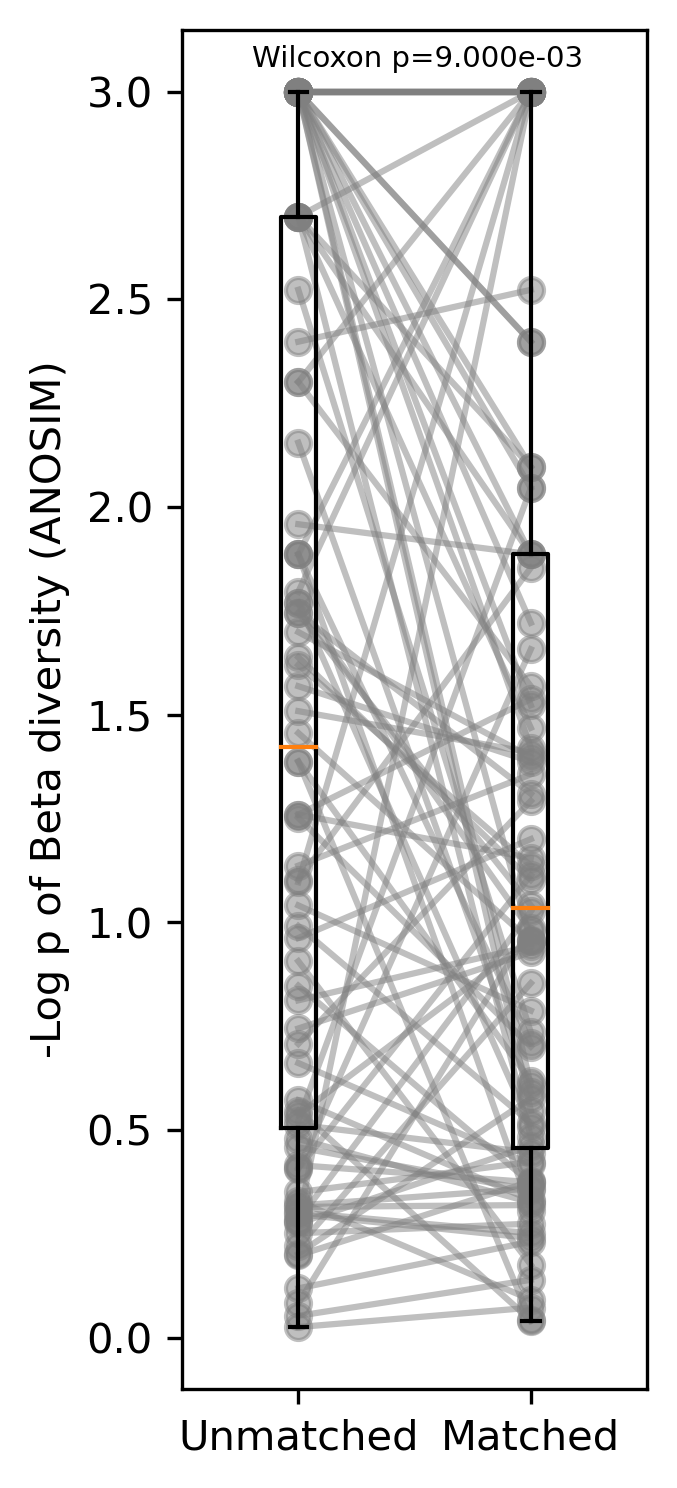

In [8]:
stats.wilcoxon(result['ANOSIM_Unmatched'], result['ANOSIM_Matched'])[1]
_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['ANOSIM_Unmatched', 'ANOSIM_Matched']], '-o', alpha=0.5, color='gray')
_ = plt.boxplot([result['ANOSIM_Unmatched'], result['ANOSIM_Matched']])
_ = plt.annotate('Wilcoxon p=%.3e'%0.009, (0.8, 3.06), fontsize=7)
_ = plt.ylabel('-Log p of Beta diversity (ANOSIM)')
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])

_ = plt.show()

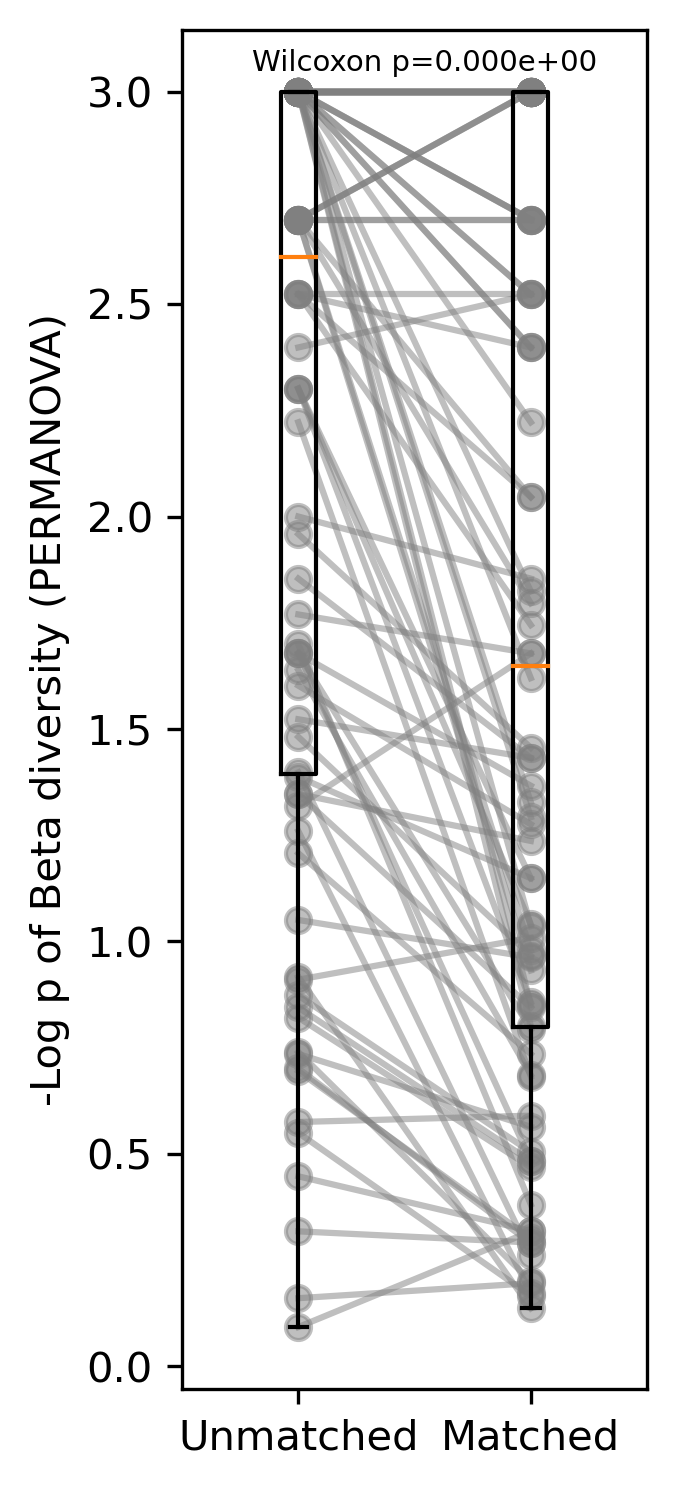

In [9]:
_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['PERMANOVA_Unmatched', 'PERMANOVA_Matched']], '-o', alpha=0.5, color='gray')
_ = plt.boxplot([result['PERMANOVA_Unmatched'], result['PERMANOVA_Matched']])
_ = plt.annotate('Wilcoxon p=%.3e'%round(stats.wilcoxon(result['PERMANOVA_Unmatched'], result['PERMANOVA_Matched'])[1], 3), 
                 (0.8, 3.05), fontsize=7)
_ = plt.ylabel('-Log p of Beta diversity (PERMANOVA)')
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
_ = plt.show()

('相关统计', (0.16143269684945027, 0.13294366996517823))

(0.0343115718212751, 0.5420030891639083, 0.9999999999999996, 0.0)

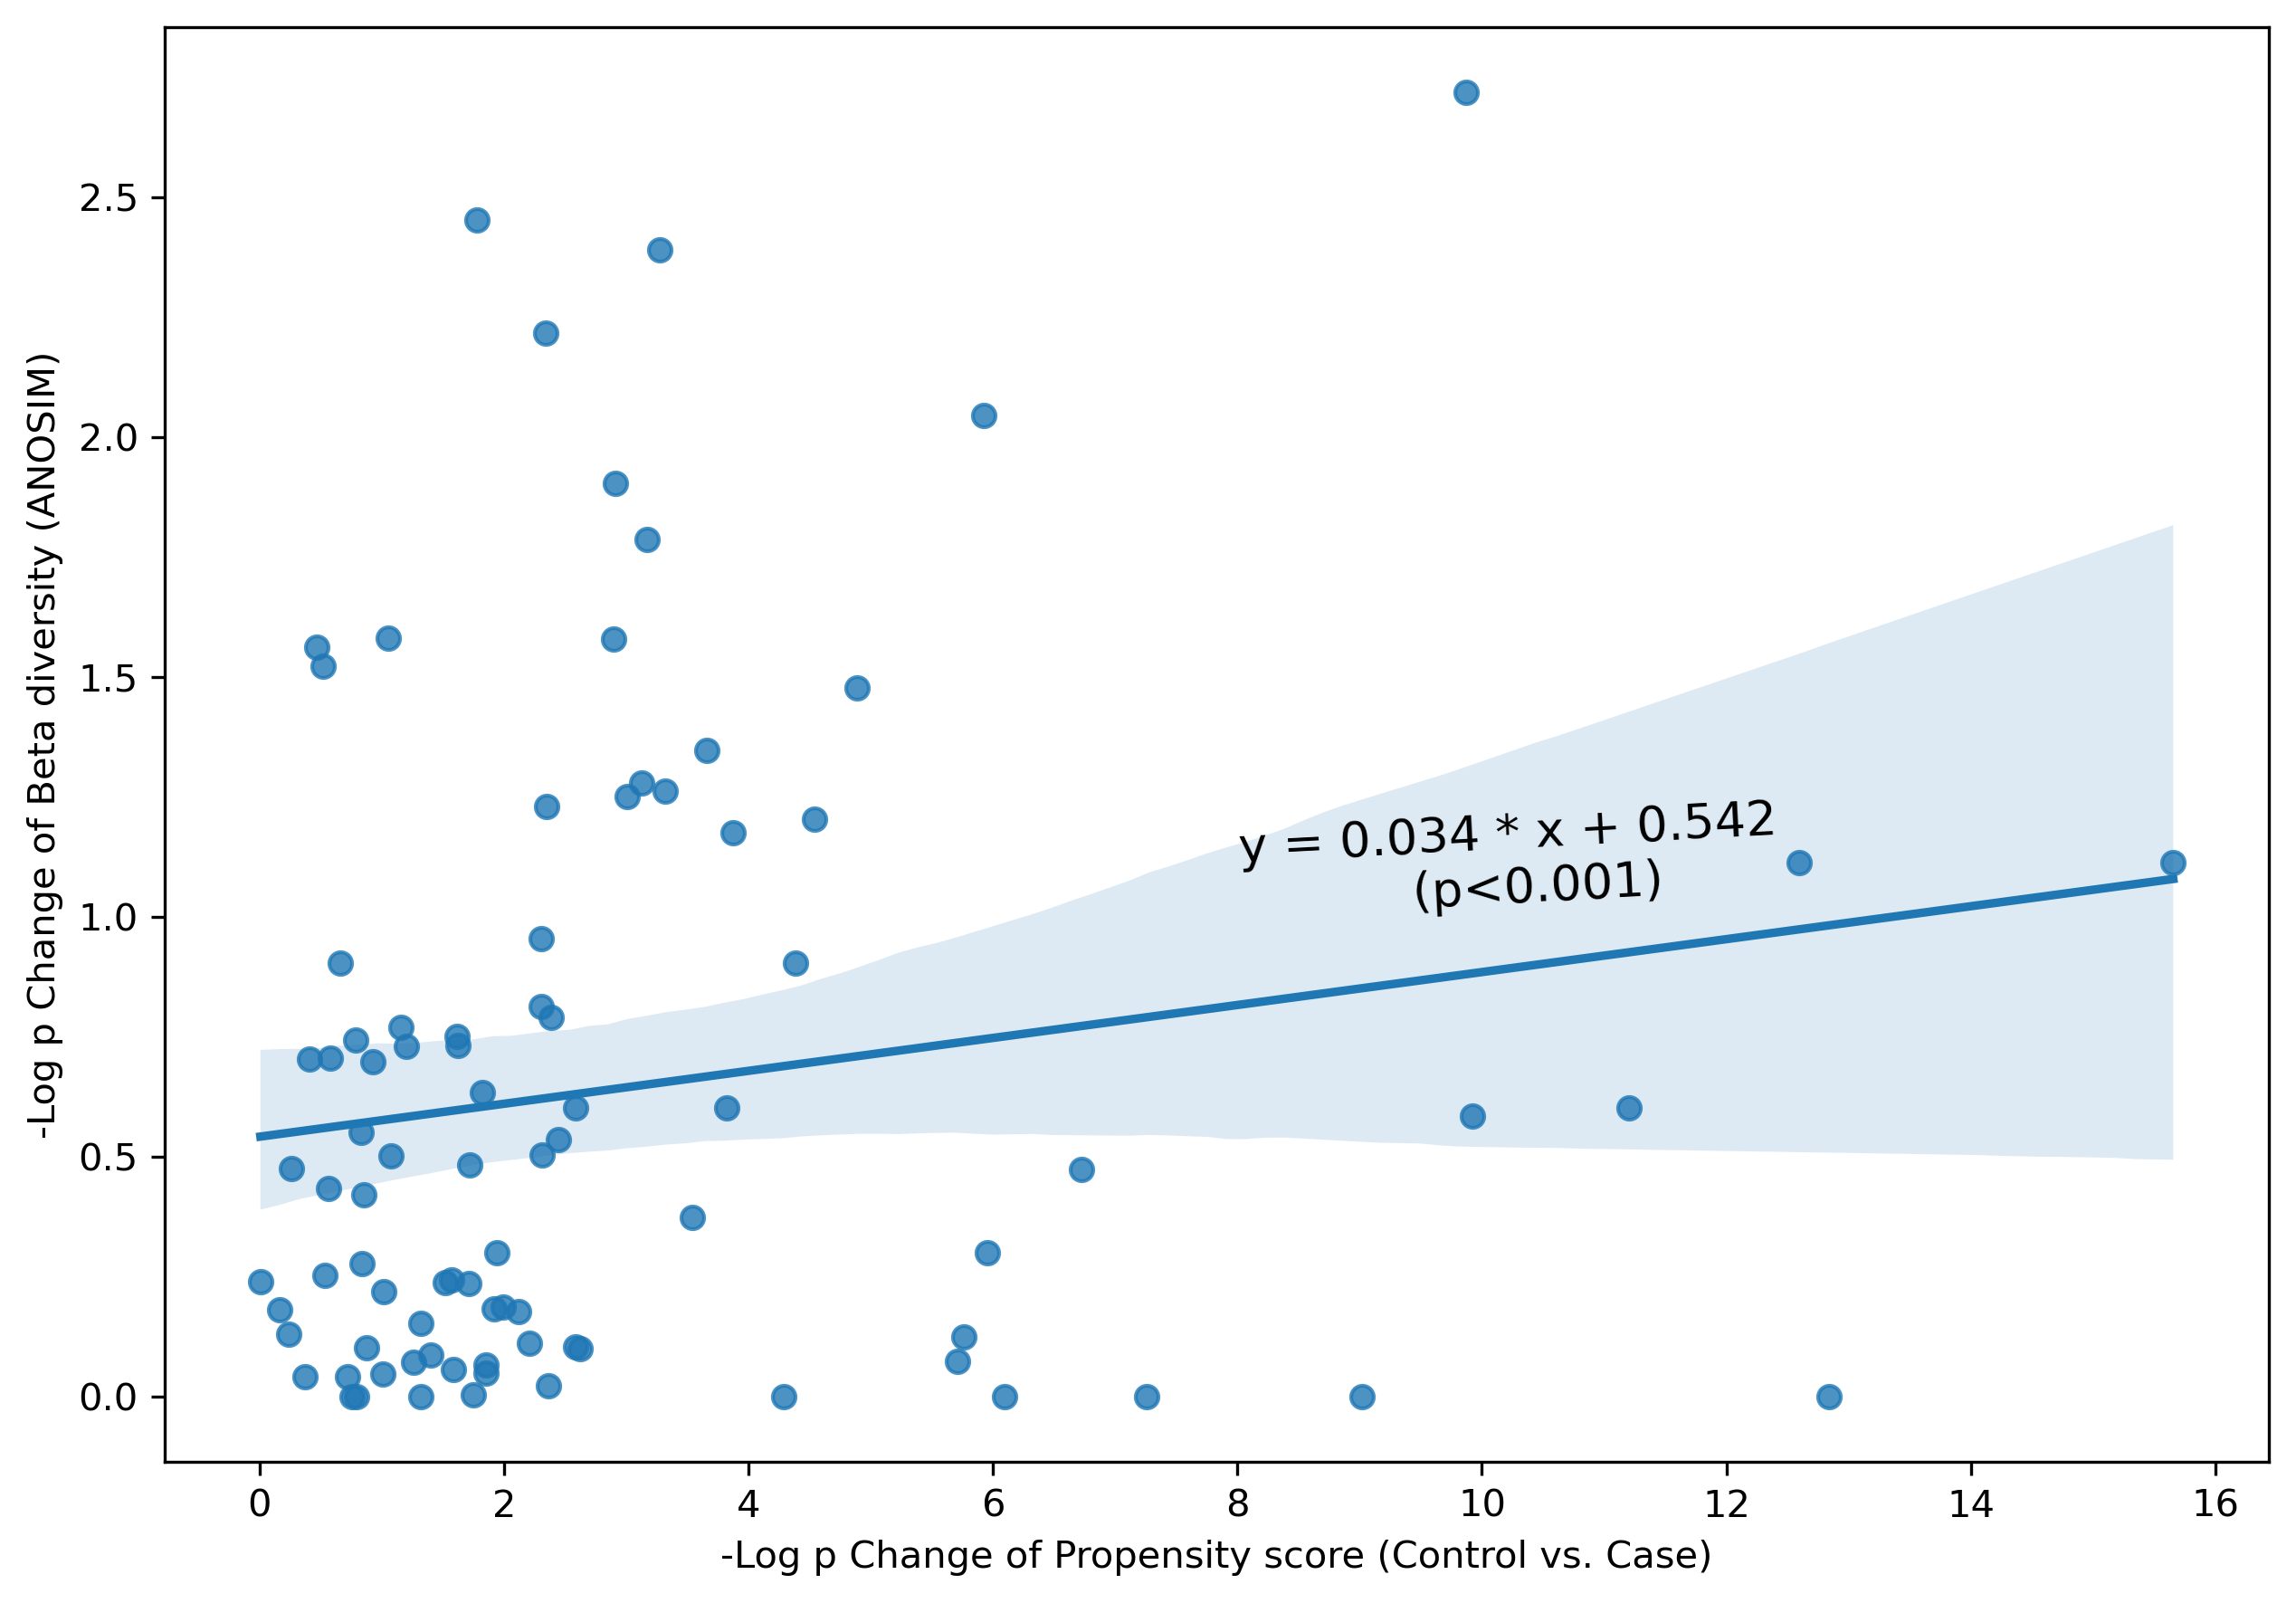

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ANOSIM_Change   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.301
Date:                Mon, 12 Dec 2022   Prob (F-statistic):              0.133
Time:                        10:13:31   Log-Likelihood:                -85.646
No. Observations:                  88   AIC:                             175.3
Df Residuals:                      86   BIC:                             180.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5420      0.096      5.637      0.000       0.351       0.733
PS_Change      0.0343      0.023      1.517      0.133      -0.011       0.079
==============================================================================
Omnibus:                       17.781   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.027
Skew:                           1.140   Prob(JB):                     2.72e-05
Kurtosis:                       3.735   Cond. No.                         6.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
'相关统计', stats.pearsonr(np.abs(result['Delta_PS_Matched']-result['Delta_PS_Unmatched']), np.abs(result['ANOSIM_Matched']-result['ANOSIM_Unmatched']))
result['PS_Change'] =np.abs(result['Delta_PS_Matched']-result['Delta_PS_Unmatched']) 
result['ANOSIM_Change'] =np.abs(result['ANOSIM_Matched']-result['ANOSIM_Unmatched']) 
_ = plt.figure(0, (10, 7), dpi=300)
p = sns.regplot(x="PS_Change", y="ANOSIM_Change", data=result)
slope, intercept, r_value, p_value, std_err = stats.linregress(x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata())
slope,intercept,r_value,p_value
_ = plt.annotate('y = '+str(round(slope, 3))+' * x + '+str(round(intercept, 3))+'\n           (p<0.001)', 
                 (8,1), fontsize=13, rotation=3)
_ = plt.xlabel('-Log p Change of Propensity score (Control vs. Case)')
_ = plt.ylabel('-Log p Change of Beta diversity (ANOSIM)')
plt.savefig('../Results/3.Beta多样性_相关性.pdf',bbox_inches = 'tight')
_ = plt.show()

X = result['PS_Change']
X = sm.add_constant(X)
y = result['ANOSIM_Change']
est=sm.OLS(y, X)
est=est.fit()
est.summary()

### 2. All taxa change

3.708349171489501e-07

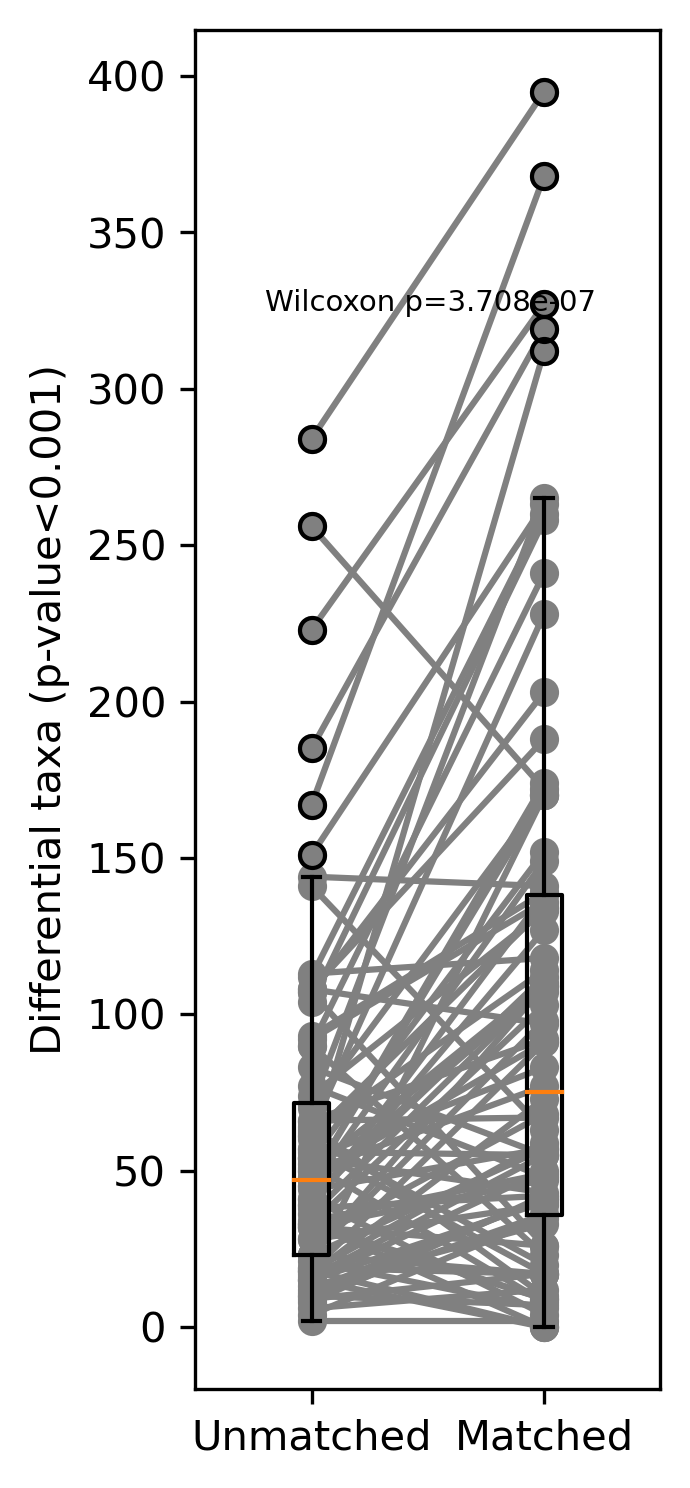

In [13]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    taxa_raw_sig = taxa_diff.loc[taxa_diff['p-value(raw)']<P_VALUE_THRESHOLLD, :]
    taxa_psm_sig = taxa_diff.loc[taxa_diff['p-value(PSM)']<P_VALUE_THRESHOLLD, :]
    #taxa_raw_sig.shape[0], taxa_psm_sig.shape[0], len(set(taxa_raw_sig.index)&set(taxa_psm_sig.index))
    result.append([project, taxa_raw_sig.shape[0], taxa_psm_sig.shape[0], len(set(taxa_raw_sig.index)&set(taxa_psm_sig.index))])
result = pd.DataFrame(result, columns=['Project', 'Diff_unmatched', 'Diff_matched', 'Overlap'])
#result
stats.wilcoxon(result['Diff_unmatched'], result['Diff_matched'])[1]
_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['Diff_unmatched', 'Diff_matched']], '-o', alpha=1, color='gray')
_ = plt.boxplot([result['Diff_unmatched'], result['Diff_matched']])
_ = plt.annotate('Wilcoxon p=%.3e'%3.708e-7, (0.8, 325), fontsize=7)
_ = plt.ylabel('Differential taxa (p-value<0.001)')
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
#plt.savefig('../Results/3.菌群差异.pdf',bbox_inches = 'tight')
_ = plt.show()

3.4402770951074805e-08

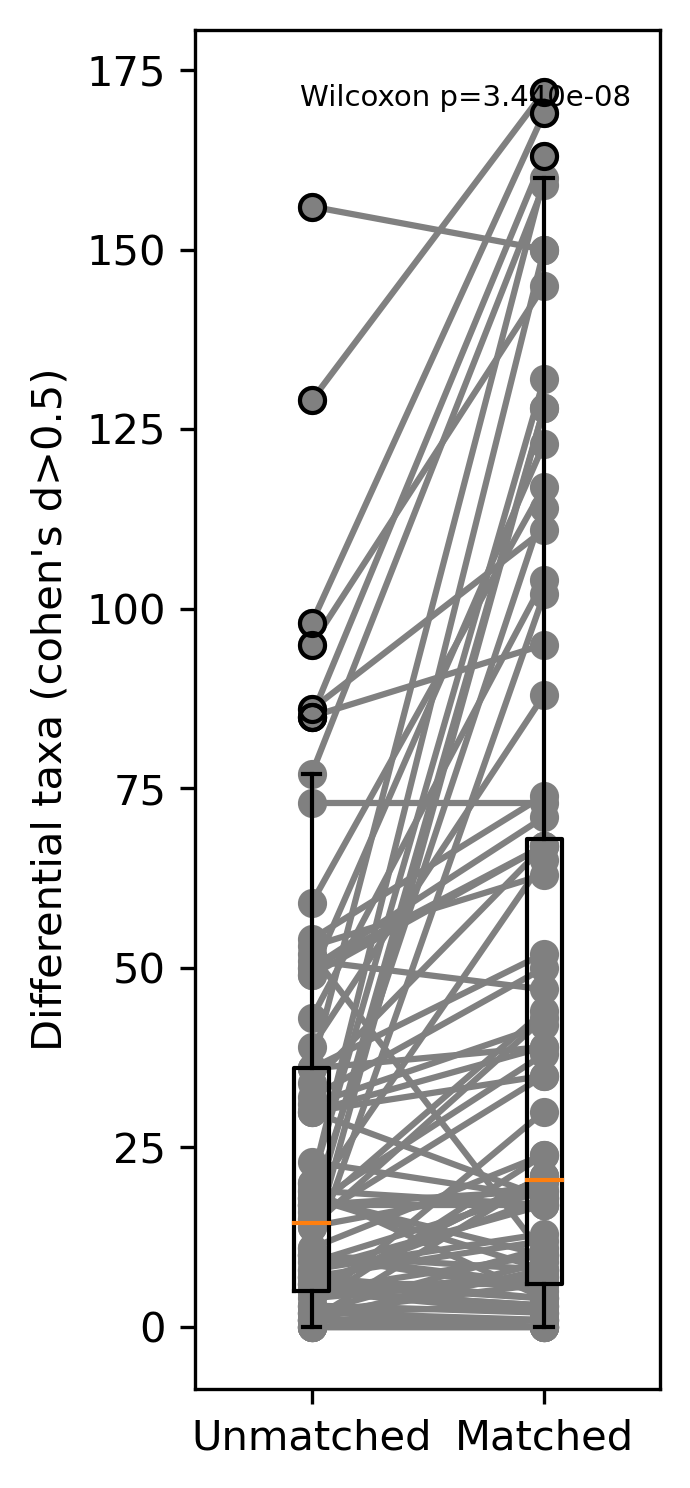

In [14]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    taxa_raw_sig = taxa_diff.loc[taxa_diff["cohen's d(raw)"]>COHEN_THRESHOLLD, :]
    taxa_psm_sig = taxa_diff.loc[taxa_diff["cohen's d(PSM)"]>COHEN_THRESHOLLD, :]
    #taxa_raw_sig.shape[0], taxa_psm_sig.shape[0], len(set(taxa_raw_sig.index)&set(taxa_psm_sig.index))
    result.append([project, taxa_raw_sig.shape[0], taxa_psm_sig.shape[0], len(set(taxa_raw_sig.index)&set(taxa_psm_sig.index))])
result = pd.DataFrame(result, columns=['Project', 'Diff_unmatched', 'Diff_matched', 'Overlap'])
#result
stats.wilcoxon(result['Diff_unmatched'], result['Diff_matched'])[1]
_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['Diff_unmatched', 'Diff_matched']], '-o', alpha=1, color='gray')
_ = plt.boxplot([result['Diff_unmatched'], result['Diff_matched']])
_ = plt.annotate('Wilcoxon p=%.3e'%3.44e-8, (0.95, 170), fontsize=7)
_ = plt.ylabel("Differential taxa (cohen's d>0.5)")
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
#plt.savefig('../Results/3.菌群差异_cohen.pdf',bbox_inches = 'tight')
_ = plt.show()

### 3. Taxa change effect size&P-value

#### 3.1 Effect size

In [7]:
delta_ds = pd.DataFrame()
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    delta_ds[project] = taxa_diff["cohen's d(PSM)"]-taxa_diff["cohen's d(raw)"]

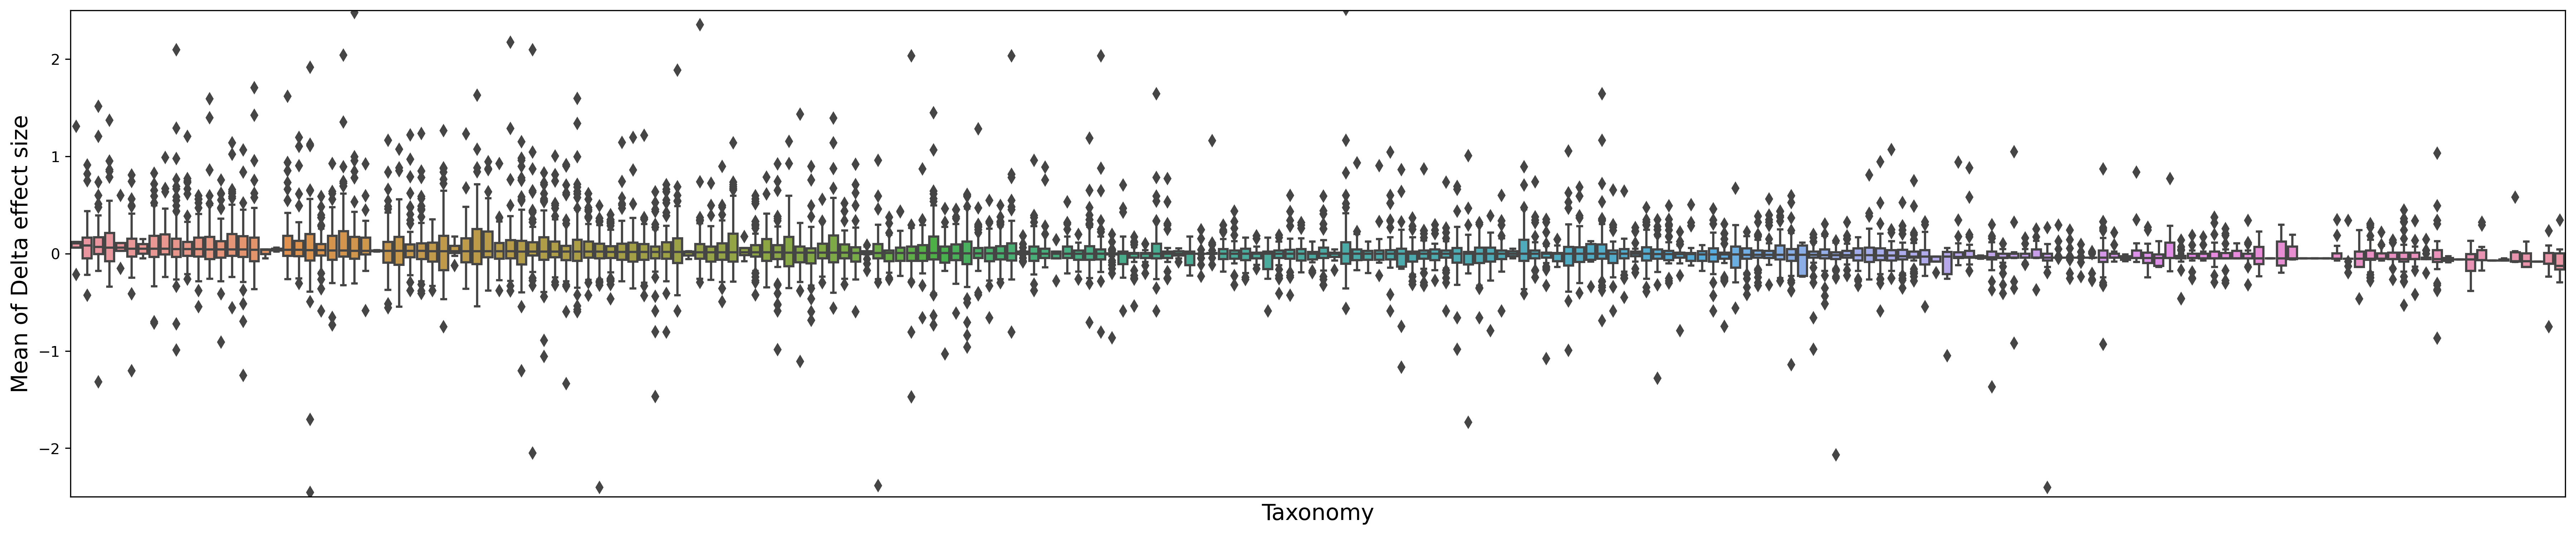

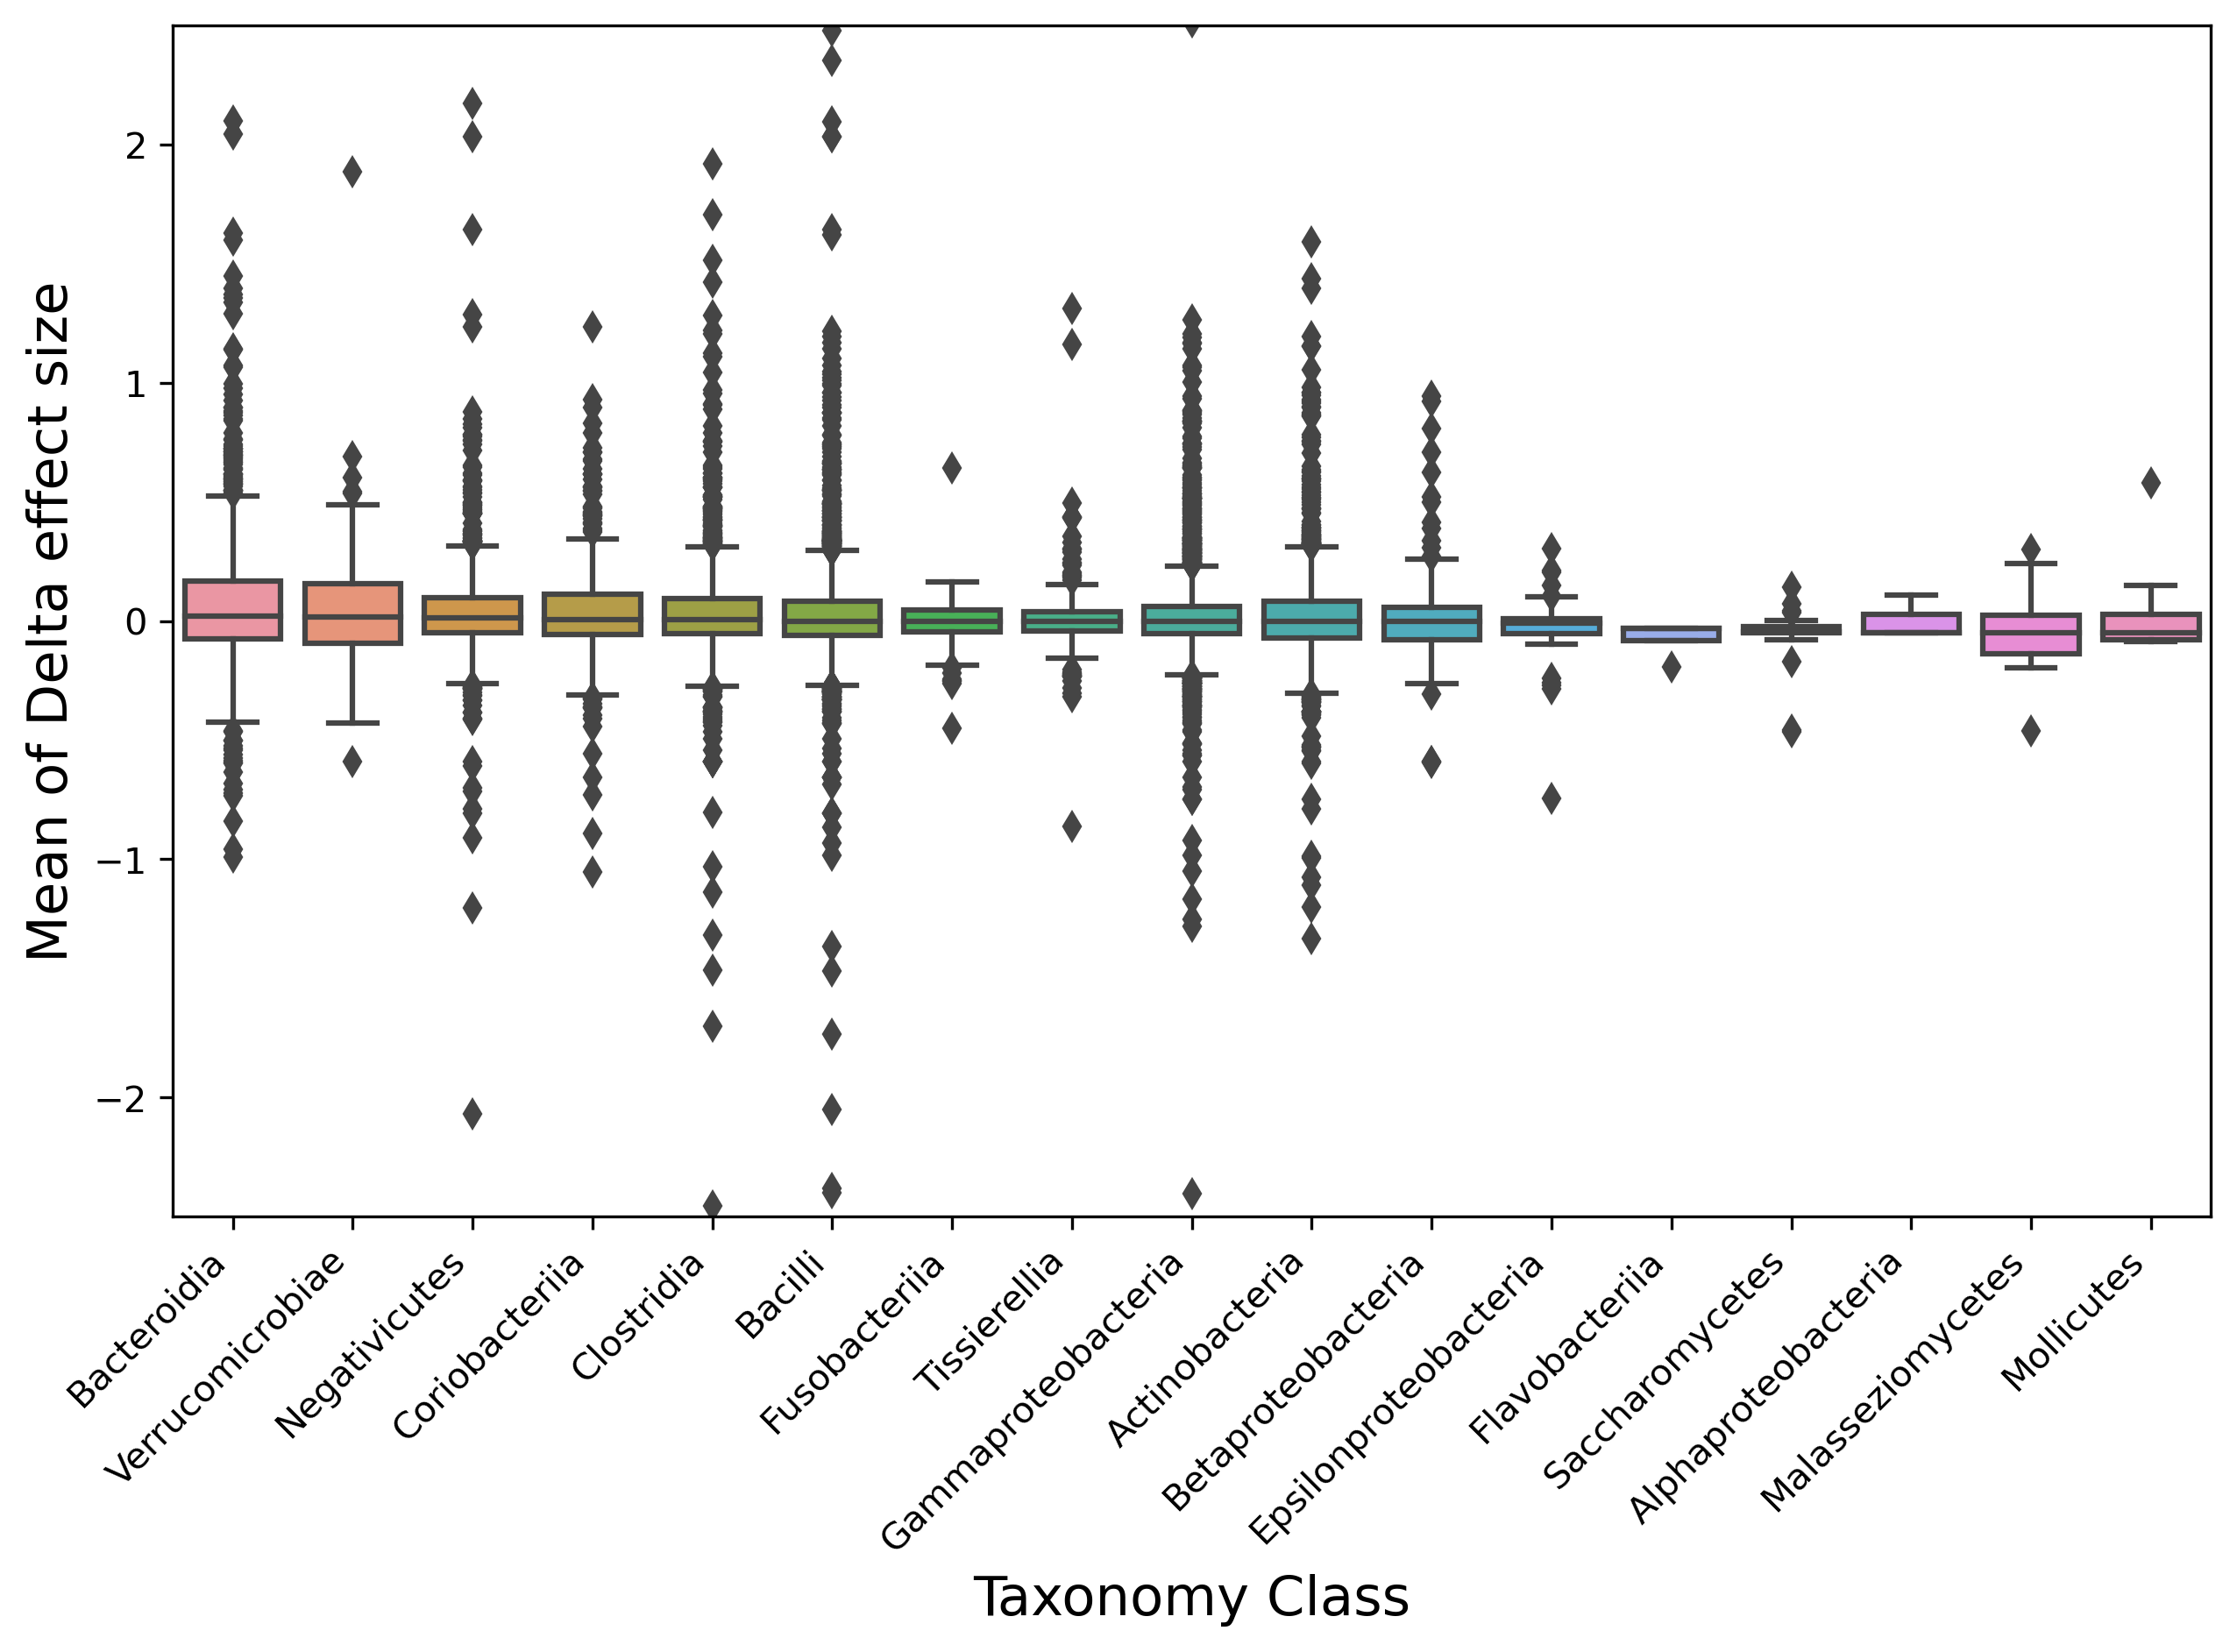

In [8]:
result = []
for taxa in delta_ds.index:
    for study in delta_ds.columns:
        taxa_class = taxa.split('|c__')[1].split('|o__')[0]
        result.append([taxa, taxa_class, study, delta_ds.loc[taxa, study]])
result = pd.DataFrame(result, columns=['Taxa', 'Class', 'Study', 'Delta_D'])
#result.to_csv('../Label/3.差异菌种effectSize.csv')

order = result.groupby('Taxa').median().sort_values('Delta_D', ascending=False).index
_ = plt.figure(0, (30, 6), dpi=300)
_ = sns.boxplot(x="Taxa", y="Delta_D", data=result, order=order)
_ = plt.xticks([], [])
_ = plt.ylim(-2.5,2.5)
_ = plt.ylabel('Mean of Delta effect size', fontsize=15)
_ = plt.xlabel('Taxonomy', fontsize=15)
#plt.savefig('../Results/3.差异菌Taxa群变化_effectSize.pdf',bbox_inches = 'tight')
_ = plt.show()

order = result.groupby('Class').median().sort_values('Delta_D', ascending=False).index
_ = plt.figure(0, (10, 6), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylim(-2.5,2.5)
_ = plt.ylabel('Mean of Delta effect size', fontsize=15)
_ = plt.xlabel('Taxonomy Class', fontsize=15)
#plt.savefig('../Results/3.差异菌种Class类变化_effectSize.pdf',bbox_inches = 'tight')
_ = plt.show()

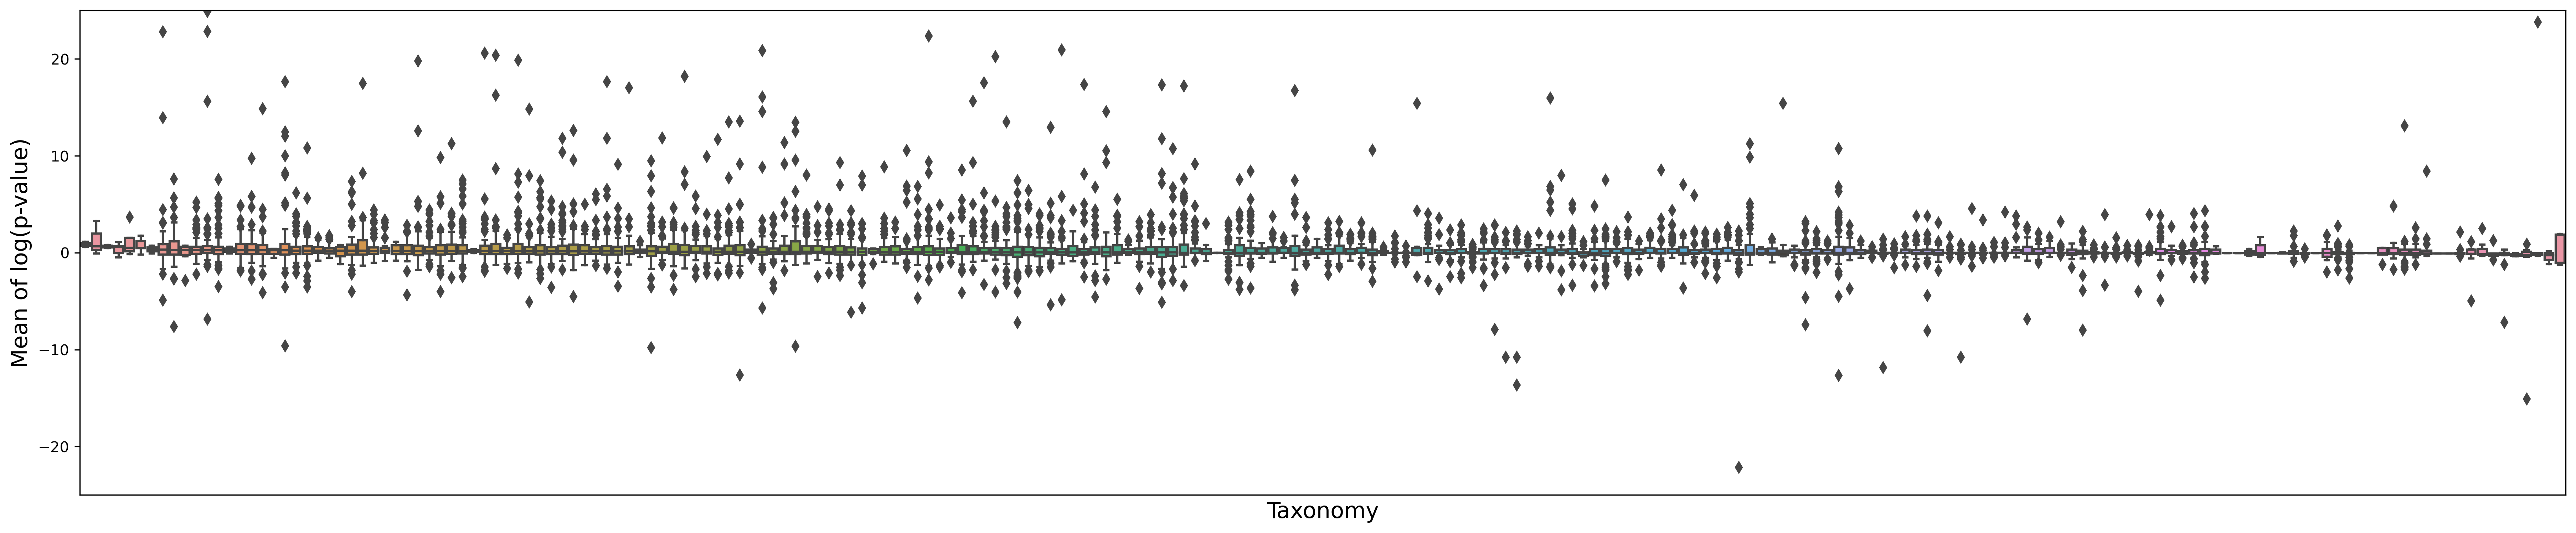

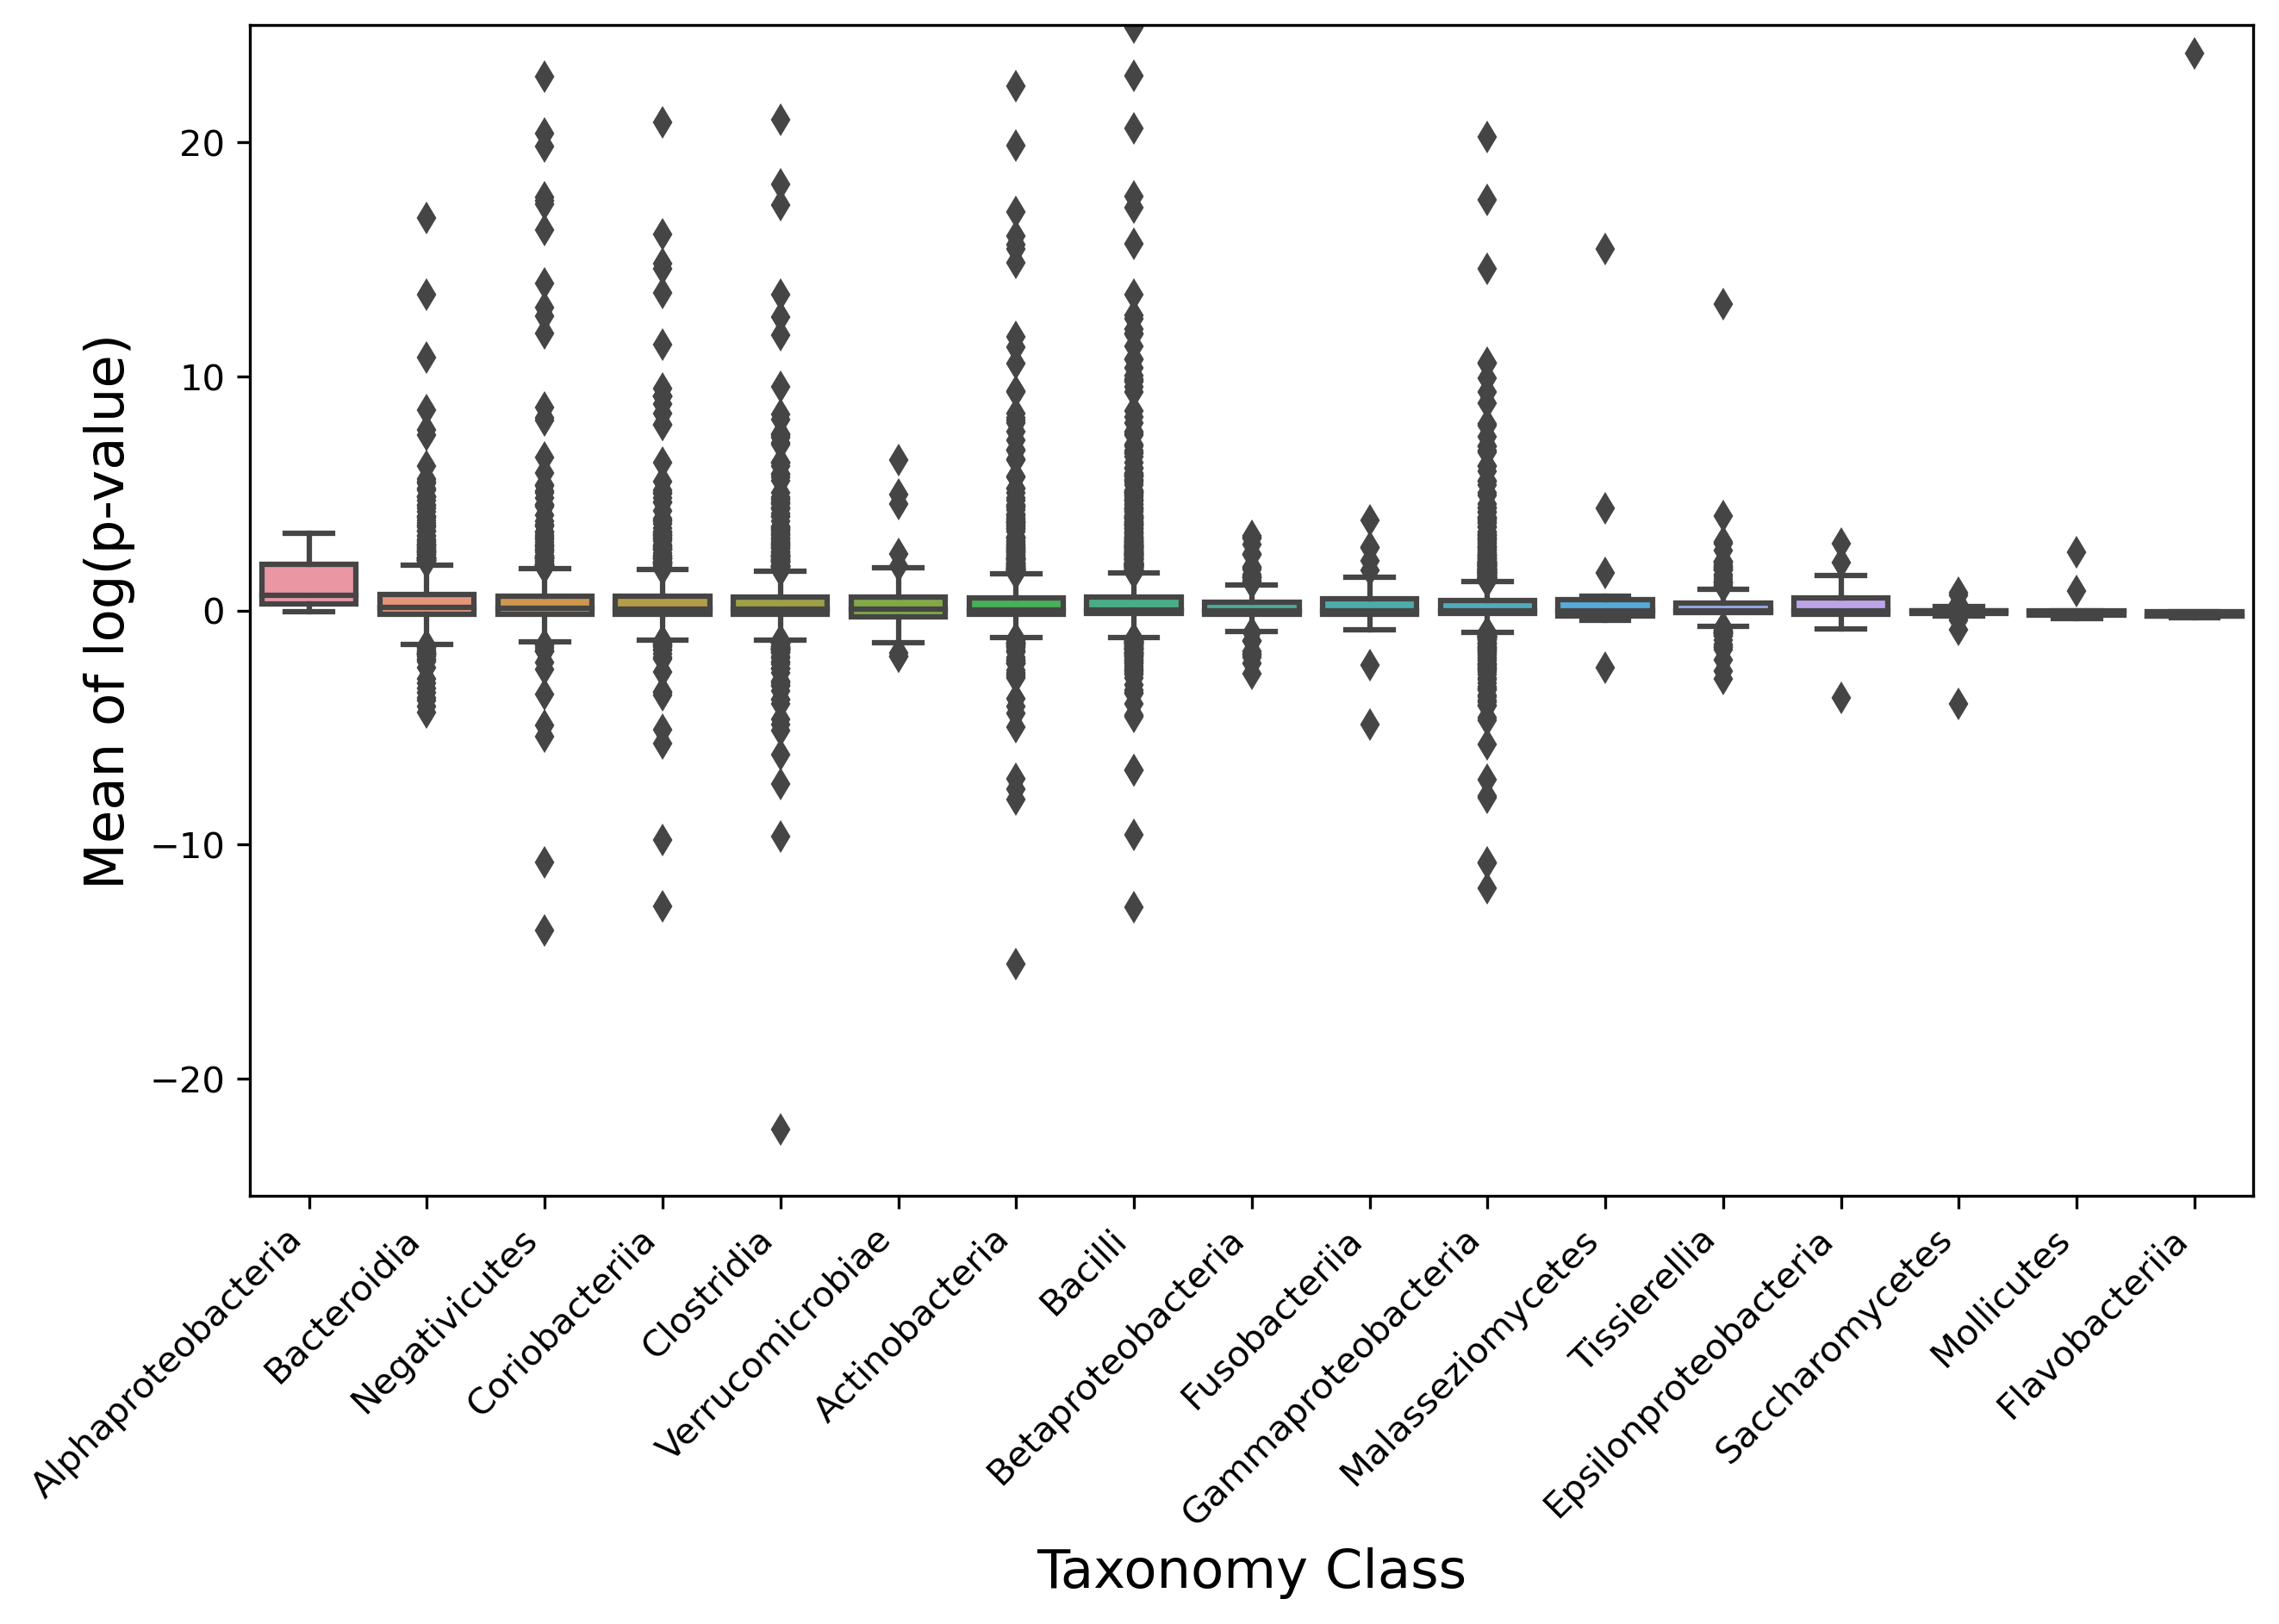

In [12]:
logp_ds = pd.DataFrame()
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    ###p-value(raw)-p-value(PSM) 
    logp_ds[project] =-np.log10(taxa_diff["p-value(PSM)"])+np.log10(taxa_diff["p-value(raw)"])

result = []
for taxa in logp_ds.index:
    for study in logp_ds.columns:
        taxa_class = taxa.split('|c__')[1].split('|o__')[0]
        result.append([taxa, taxa_class, study, logp_ds.loc[taxa, study]])
result = pd.DataFrame(result, columns=['Taxa', 'Class', 'Study', 'Delta_logp'])
#result.to_csv('../Label/3.差异菌种pvalue.csv')

order = result.groupby('Taxa').median().sort_values('Delta_logp', ascending=False).index
_ = plt.figure(0, (30, 6), dpi=300)
_ = sns.boxplot(x="Taxa", y="Delta_logp", data=result, order=order)
_ = plt.xticks([], [])
_ = plt.ylim(-25,25)
_ = plt.ylabel('Mean of log(p-value)', fontsize=15)
_ = plt.xlabel('Taxonomy', fontsize=15)
#plt.savefig('../Results/3.差异菌Taxa群变化_log.pdf',bbox_inches = 'tight')
_ = plt.show()

order = result.groupby('Class').median().sort_values('Delta_logp', ascending=False).index
_ = plt.figure(0, (10, 6), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_logp", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylim(-25,25)
_ = plt.ylabel('Mean of log(p-value)', fontsize=15)
_ = plt.xlabel('Taxonomy Class', fontsize=15)
#plt.savefig('../Results/3.差异菌Class变化_log.pdf',bbox_inches = 'tight')
_ = plt.show()

### 3.2 Meaningful taxa

In [13]:
sign_changes = []
count_stats = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    delta_es = taxa_diff["cohen's d(PSM)"]-taxa_diff["cohen's d(raw)"]
    delta_logp = -np.log10(taxa_diff["p-value(PSM)"])+np.log10(taxa_diff["p-value(raw)"])
    taxas = []
    for i in taxa_diff.index:
        if (taxa_diff.loc[i, "Fold change(raw)"]<1 and taxa_diff.loc[i, "Fold change(PSM)"]>1) or (taxa_diff.loc[i, "Fold change(raw)"]>1 and taxa_diff.loc[i, "Fold change(PSM)"]<1):
            taxas.append(i)
            sign_changes.append([project, i, taxa_diff.loc[i, "Fold change(raw)"], np.sign(taxa_diff.loc[i, "Fold change(raw)"]-1), 
                                 taxa_diff.loc[i, "Fold change(PSM)"], np.sign(taxa_diff.loc[i, "Fold change(PSM)"]-1), taxa_diff.loc[i, "p-value(raw)"], 
                                 taxa_diff.loc[i, "p-value(PSM)"]])
    count_stats.append([project, len(taxas), taxa_diff.shape[0], len(taxas)/taxa_diff.shape[0]])
sign_changes = pd.DataFrame(sign_changes, columns=['project', 'taxa', 'fc_raw', 'sign_fc_raw', 
                                                   'fc_psm', 'sign_fc_psm', 'p_raw', 'p_psm'])
count_stats = pd.DataFrame(count_stats, columns=['project', 'sign_chages', 'raw_taxa_num', 'ratio'])

In [14]:
sign_changes

project                                               taxa     fc_raw  \
0          08  k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...   3.993837   
1          08  k__Bacteria|p__Tenericutes|c__Mollicutes|o__My...  24.559191   
2          08  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   3.249464   
3          08  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...  45.807520   
4          08  k__Bacteria|p__Proteobacteria|c__Gammaproteoba...   0.733137   
...       ...                                                ...        ...   
11211    99_3  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...   0.000000   
11212    99_3  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   1.512076   
11213    99_3  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...   1.239047   
11214    99_3  k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...   0.000000   
11215    99_3  k__Bacteria|p__Firmicutes|c__Negativicutes|o__...   0.000000   

       sign_fc_raw    fc_psm  sign_fc_psm         p_raw         p_psm  
0              1.0  0.408144         -1.0  9.418471e-01  2.118081e-43  
1              1.0  0.024212         -1.0  6.201639e-06  2.012194e-08  
2              1.0  0.445698         -1.0  2.769996e-02  4.932799e-07  
3              1.0  0.000000         -1.0  4.221230e-10  6.888961e-07  
4             -1.0  1.506916          1.0  5.357068e-01  9.870468e-01  
...            ...       ...          ...           ...           ...  
11211         -1.0       inf          1.0  3.848455e-01  1.000000e+00  
11212          1.0  0.659162         -1.0  4.506000e-01  1.000000e+00  
11213          1.0  0.743442         -1.0  1.152010e-01  9.251202e-01  
11214         -1.0       inf          1.0  3.848455e-01  1.000000e+00  
11215         -1.0       inf          1.0  3.848455e-01  1.000000e+00  

[11216 rows x 8 columns]

In [15]:
count_stats.index = count_stats['project']
result = []
for p in count_stats['project']:
    temp = sign_changes.loc[sign_changes['project']==p, :]
    neg2pos = (temp['sign_fc_raw']==-1).sum()
    pos2neg = (temp['sign_fc_raw']==1).sum()
    temp = sign_changes.loc[(sign_changes['project']==p)&(sign_changes['sign_fc_raw']==-1), :]
    neg2pos_sig = [temp.loc[(temp['p_raw']<=0.05)&(temp['p_psm']>0.05), :].shape[0], 
                   temp.loc[(temp['p_raw']>0.05)&(temp['p_psm']<=0.05), :].shape[0], 
                   temp.loc[(temp['p_raw']<=0.05)&(temp['p_psm']<=0.05), :].shape[0], 
                   temp.loc[(temp['p_raw']>0.05)&(temp['p_psm']>0.05), :].shape[0]]
    temp = sign_changes.loc[(sign_changes['project']==p)&(sign_changes['sign_fc_raw']==1), :]
    pos2neg_sig = [temp.loc[(temp['p_raw']<=0.05)&(temp['p_psm']>0.05), :].shape[0], 
                   temp.loc[(temp['p_raw']>0.05)&(temp['p_psm']<=0.05), :].shape[0], 
                   temp.loc[(temp['p_raw']<=0.05)&(temp['p_psm']<=0.05), :].shape[0], 
                   temp.loc[(temp['p_raw']>0.05)&(temp['p_psm']>0.05), :].shape[0]]
    #p, count_stats.loc[p, 'sign_chages'], neg2pos, neg2pos_sig, pos2neg, pos2neg_sig
    row = []
    row.extend(neg2pos_sig)
    row.extend(pos2neg_sig)
    row.append(count_stats.loc[p, 'raw_taxa_num']-neg2pos-pos2neg)
    result.append(np.array(row)/count_stats.loc[p, 'raw_taxa_num']*100.)
result = pd.DataFrame(result, index=count_stats['project'], columns=['neg2pos_*-', 'neg2pos_-*', 'neg2pos_**', 
                                                                     'neg2pos_--', 'pos2neg_*-', 'pos2neg_-*', 
                                                                     'pos2neg_**', 'pos2neg_--', 'others'])
result
#result.to_csv('../Results/3.2代谢影响菌种.csv')

neg2pos_*-  neg2pos_-*  neg2pos_**  neg2pos_--  pos2neg_*-  \
project                                                               
08         0.000000    0.000000    0.000000    0.892857    0.000000   
09         1.901141    0.000000    0.000000    7.604563    0.760456   
100        0.000000    1.250000    0.416667    4.375000    0.000000   
101        0.000000    1.376147    0.458716    4.587156    0.000000   
11         0.000000    0.925926    0.000000    8.564815    0.231481   
...             ...         ...         ...         ...         ...   
96         0.297619    0.892857    0.000000   19.642857    0.000000   
97         0.000000    1.217391    0.173913    5.217391    0.000000   
99_1       0.153374    1.226994    0.000000    9.662577    0.153374   
99_2       0.306748    0.306748    0.000000    9.662577    0.306748   
99_3       0.153374    2.300613    0.306748   12.576687    0.460123   

         pos2neg_-*  pos2neg_**  pos2neg_--     others  
project                                                 
08         0.446429    1.339286    0.000000  97.321429  
09         9.505703    0.000000    6.083650  74.144487  
100        0.416667    0.000000    6.250000  87.291667  
101        0.917431    0.229358    2.981651  89.449541  
11         0.462963    0.462963    2.546296  86.805556  
...             ...         ...         ...        ...  
96         0.000000    0.000000    1.190476  77.976190  
97         0.347826    0.173913    1.217391  91.652174  
99_1       0.460123    0.000000    3.527607  84.815951  
99_2       0.306748    0.000000    3.680982  85.429448  
99_3       0.306748    0.000000    2.607362  81.288344  

[88 rows x 9 columns]

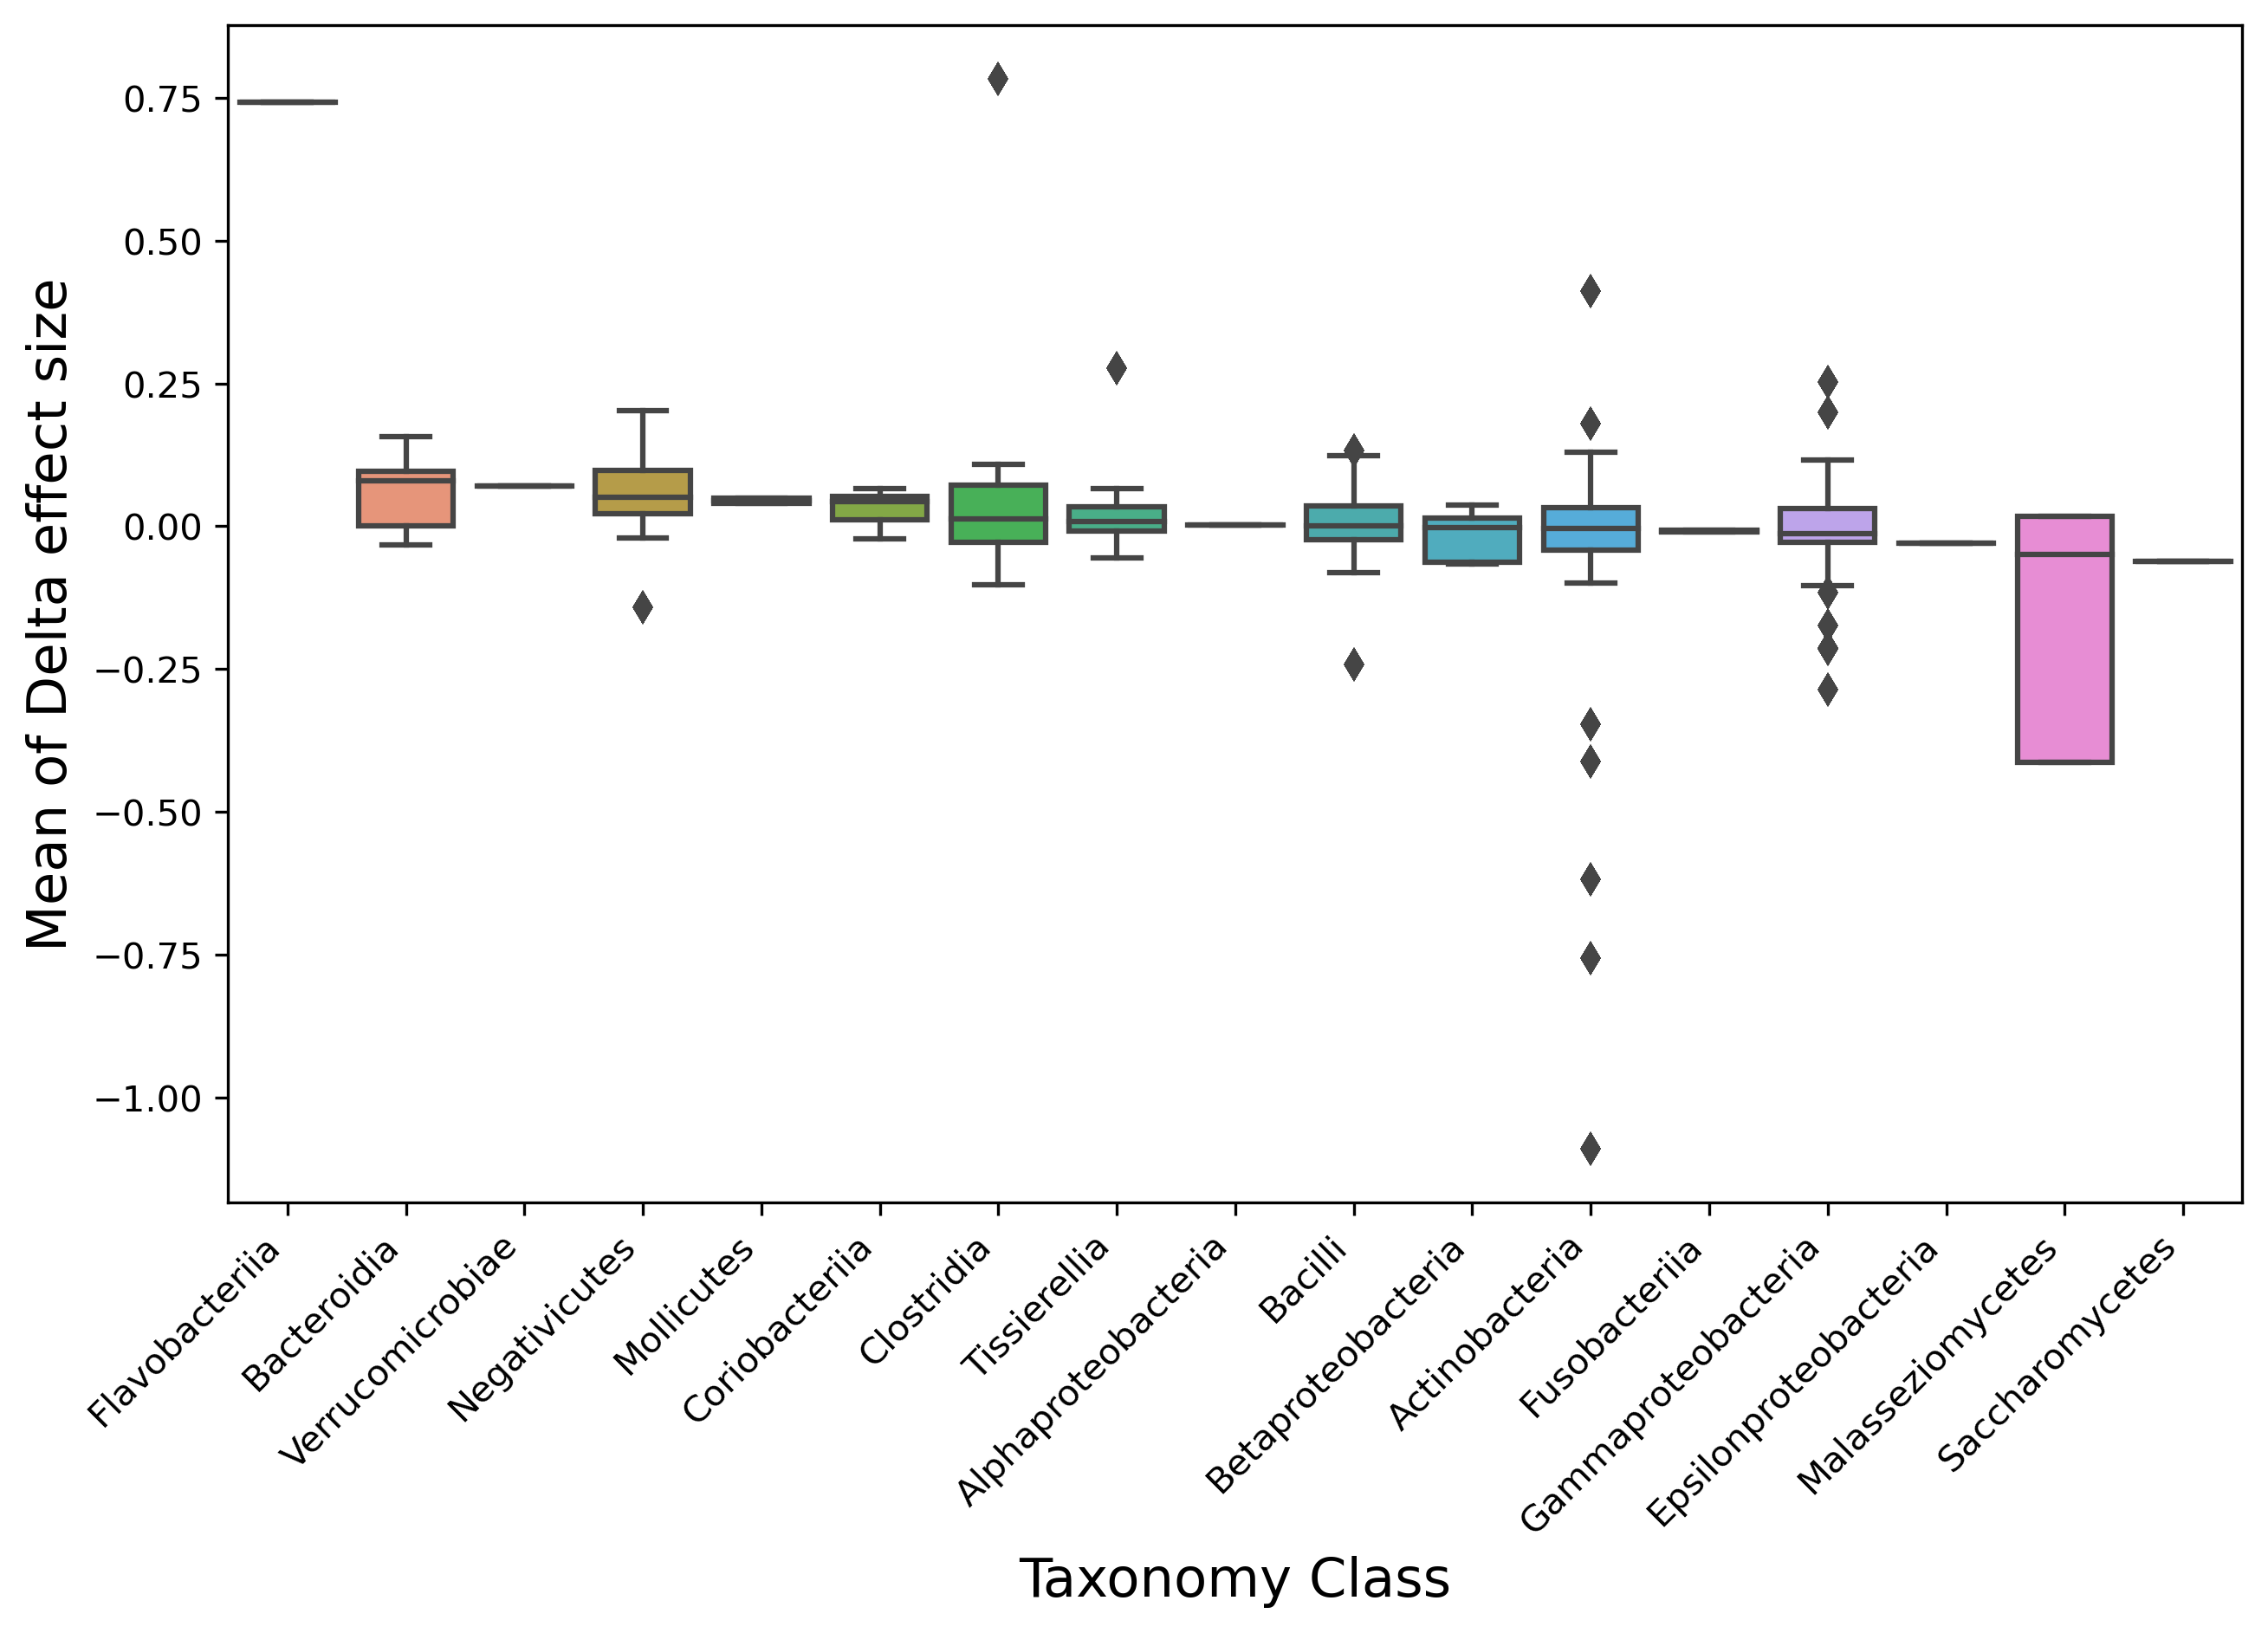

In [16]:
result = []
for taxa in delta_ds.index:
    for study in delta_ds.columns:
        taxa_class = taxa.split('|c__')[1].split('|o__')[0]
        result.append([taxa, taxa_class, study, delta_ds.loc[taxa, :].mean()])
result = pd.DataFrame(result, columns=['Taxa', 'Class', 'Study', 'Delta_D'])
order = result.groupby('Class').median().sort_values('Delta_D', ascending=False).index
_ = plt.figure(0, (10, 6), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylabel('Mean of Delta effect size', fontsize=15)
_ = plt.xlabel('Taxonomy Class', fontsize=15)
#plt.savefig('../Results/3.2 MeanDeltaEffectSize.pdf',bbox_inches = 'tight')
_ = plt.show()

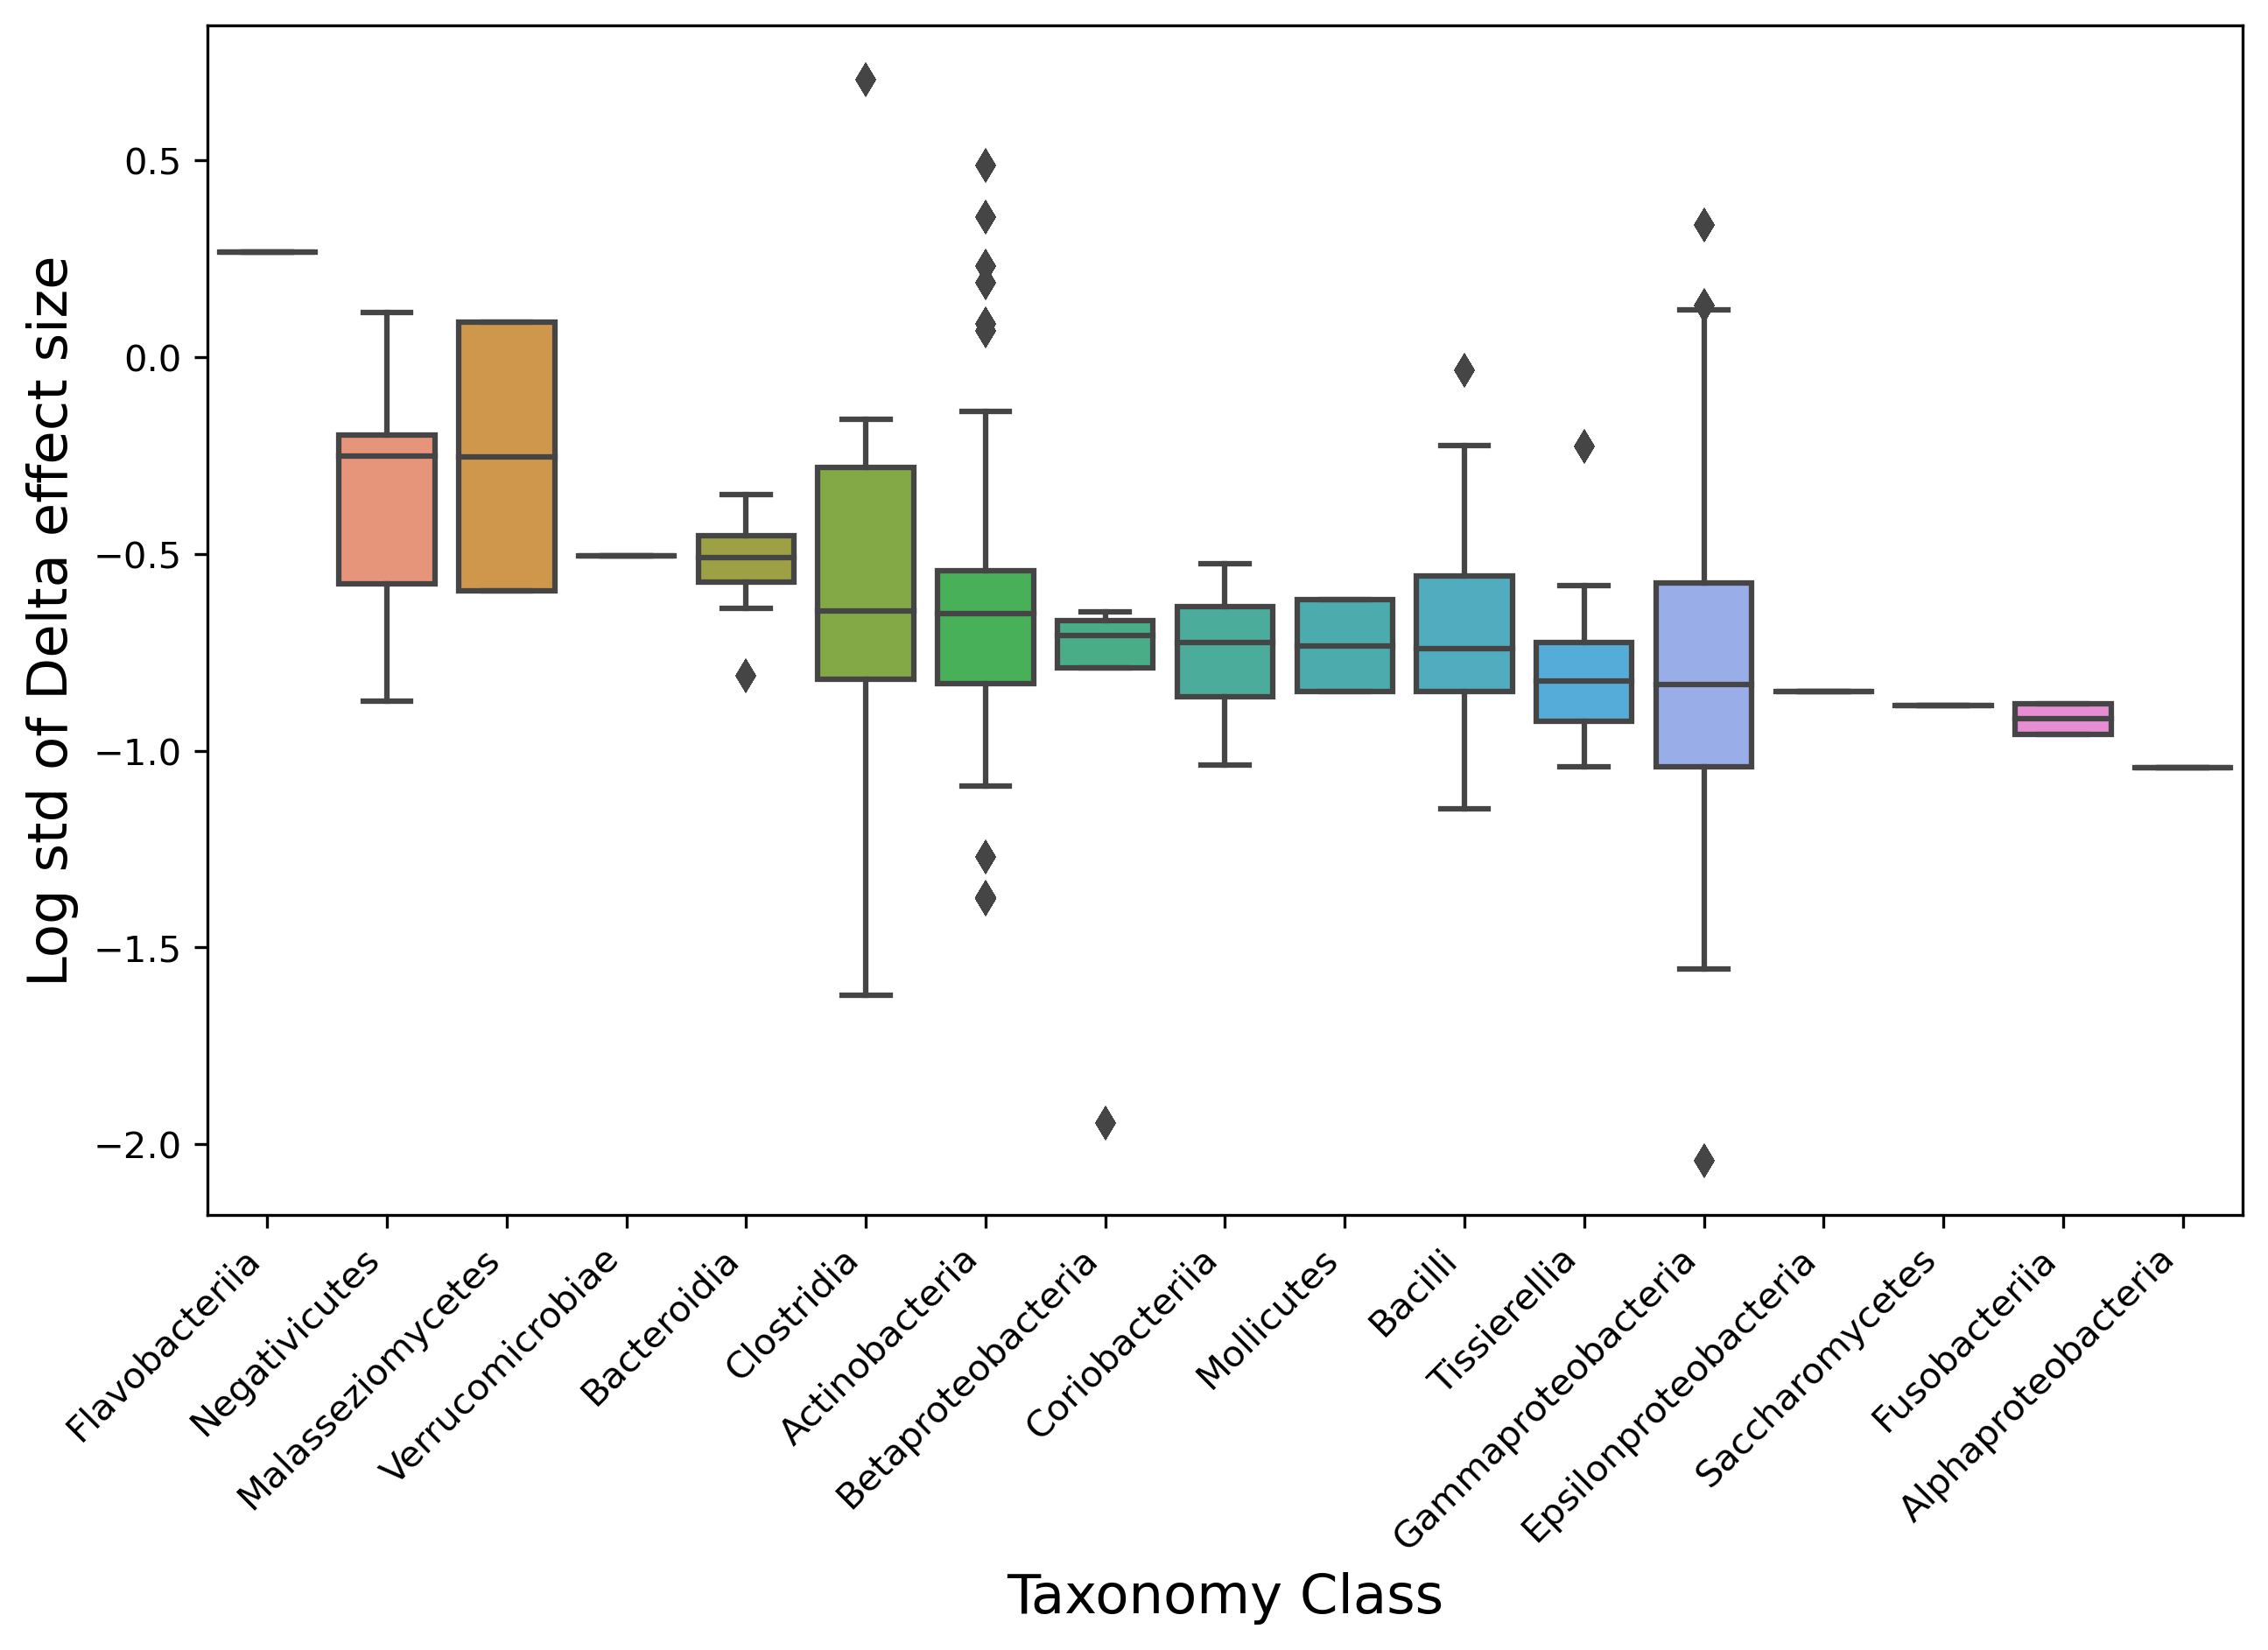

In [33]:
result = []
for taxa in delta_ds.index:
    for study in delta_ds.columns:
        taxa_class = taxa.split('|c__')[1].split('|o__')[0]
        result.append([taxa, taxa_class, study, np.log10(delta_ds.loc[taxa, :].std())])
result = pd.DataFrame(result, columns=['Taxa', 'Class', 'Study', 'Delta_D'])
order = result.groupby('Class').median().sort_values('Delta_D', ascending=False).index
_ = plt.figure(0, (10, 6), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylabel('Log std of Delta effect size', fontsize=15)
_ = plt.xlabel('Taxonomy Class', fontsize=15)
#plt.savefig('../Results/3.2 LogStdDeltaEffectSize.pdf',bbox_inches = 'tight')
_ = plt.show()

In [14]:
def plot_ellipses(axis, x, y, std=1, facecolor='None', edgecolor='k', alpha=0.5):
    from matplotlib.patches import Ellipse
    x = x.fillna(x.mean())
    y = y.fillna(y.mean())
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    e = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*std*2, height=lambda_[1]*std*2, angle=np.rad2deg(np.arccos(v[0, 0])))
    e.set_facecolor(facecolor)
    e.set_edgecolor(edgecolor)
    e.set_alpha(alpha)
    e.set_linestyle('--')
    axis.add_artist(e)
    return axis

In [15]:
result = pd.DataFrame()
result['Std'] = np.log10(delta_ds.std(1))
result['Min/Max'] = [delta_ds.iloc[i, np.argmax(delta_ds.iloc[i, :].abs())] for i in range(delta_ds.shape[0])]
result['Mean'] = delta_ds.mean(1)
result['Ratio'] = [(delta_ds.mean(1)[i]*delta_ds.iloc[i, :]>0).sum()/float(delta_ds.shape[1]) for i in range(delta_ds.shape[0])]
result['Class'] = [i.split('|c__')[1].split('|o__')[0] for i in delta_ds.index]
taxa = result.groupby(['Class']).size().sort_values(ascending=False)
levels = []
for i in taxa.index:
    if taxa[i]>=10:
        result.loc[result['Class']==i, 'Label']=i
        levels.append(i)
    else:
        result.loc[result['Class']==i, 'Label']='Others'
levels.append('Others')
result.head()

Std    Min/Max  \
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  0.486196  -8.669093   
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|...  0.267187   4.049861   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  0.355225  -7.201630   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  0.232082 -10.116933   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  0.084110  -4.037303   

                                                        Mean     Ratio  \
k__Bacteria|p__Actinobacteria|c__Actinobacteria... -1.090424  0.045455   
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|...  0.742546  0.011364   
k__Bacteria|p__Actinobacteria|c__Actinobacteria... -0.756697  0.079545   
k__Bacteria|p__Actinobacteria|c__Actinobacteria... -0.346580  0.397727   
k__Bacteria|p__Actinobacteria|c__Actinobacteria... -0.411913  0.068182   

                                                             Class  \
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|...  Flavobacteriia   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   

                                                             Label  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria  
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|...          Others  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria

['Gammaproteobacteria',
 'Bacilli',
 'Actinobacteria',
 'Clostridia',
 'Bacteroidia',
 'Negativicutes',
 'Coriobacteriia',
 'Others']

<AxesSubplot:xlabel='Std', ylabel='Density'>

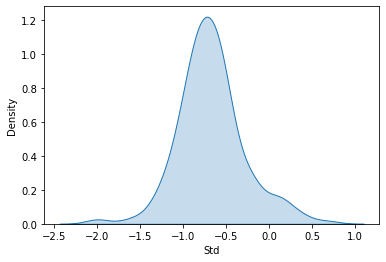

In [16]:
levels
std=result['Std']
sns.kdeplot(std, shade=True)

Corynebacterium_kroppenstedtii (0.4861961277444874, -1.0904243416725659)
Cloacibacterium_normanense (0.2671871288103453, 0.7425464535088203)
Propionibacterium_namnetense (0.3552250485495768, -0.7566965838355528)
Cutibacterium_acnes (0.23208188097312368, -0.34657973110535056)
Micrococcus_luteus (0.08411027386015967, -0.41191297046181746)
Malassezia_restricta (0.08787484520987987, -0.4131167121516052)
Cutibacterium_granulosum (0.06568090474399049, 0.41122181028339927)
Veillonella_parvula (0.11389447280687441, 0.20223839500839152)
Micrococcus_aloeverae (0.1880987673078049, -0.6185327875488372)
Anaerococcus_octavius (-0.22645517087391387, 0.2769952068296131)
Haemophilus_parainfluenzae (0.12056475092393924, 0.25183592166058827)
Citrobacter_werkmanii (0.3360602157030423, -0.2858712464588738)
Mixta_calida (-2.042257902917096, 0.02932698430418529)
Clostridioides_difficile (0.7053862673002935, 0.783843701758564)
Serratia_fonticola (-1.5547104344372467, 0.04065677115382879)
Acidovorax_caeni (-1.

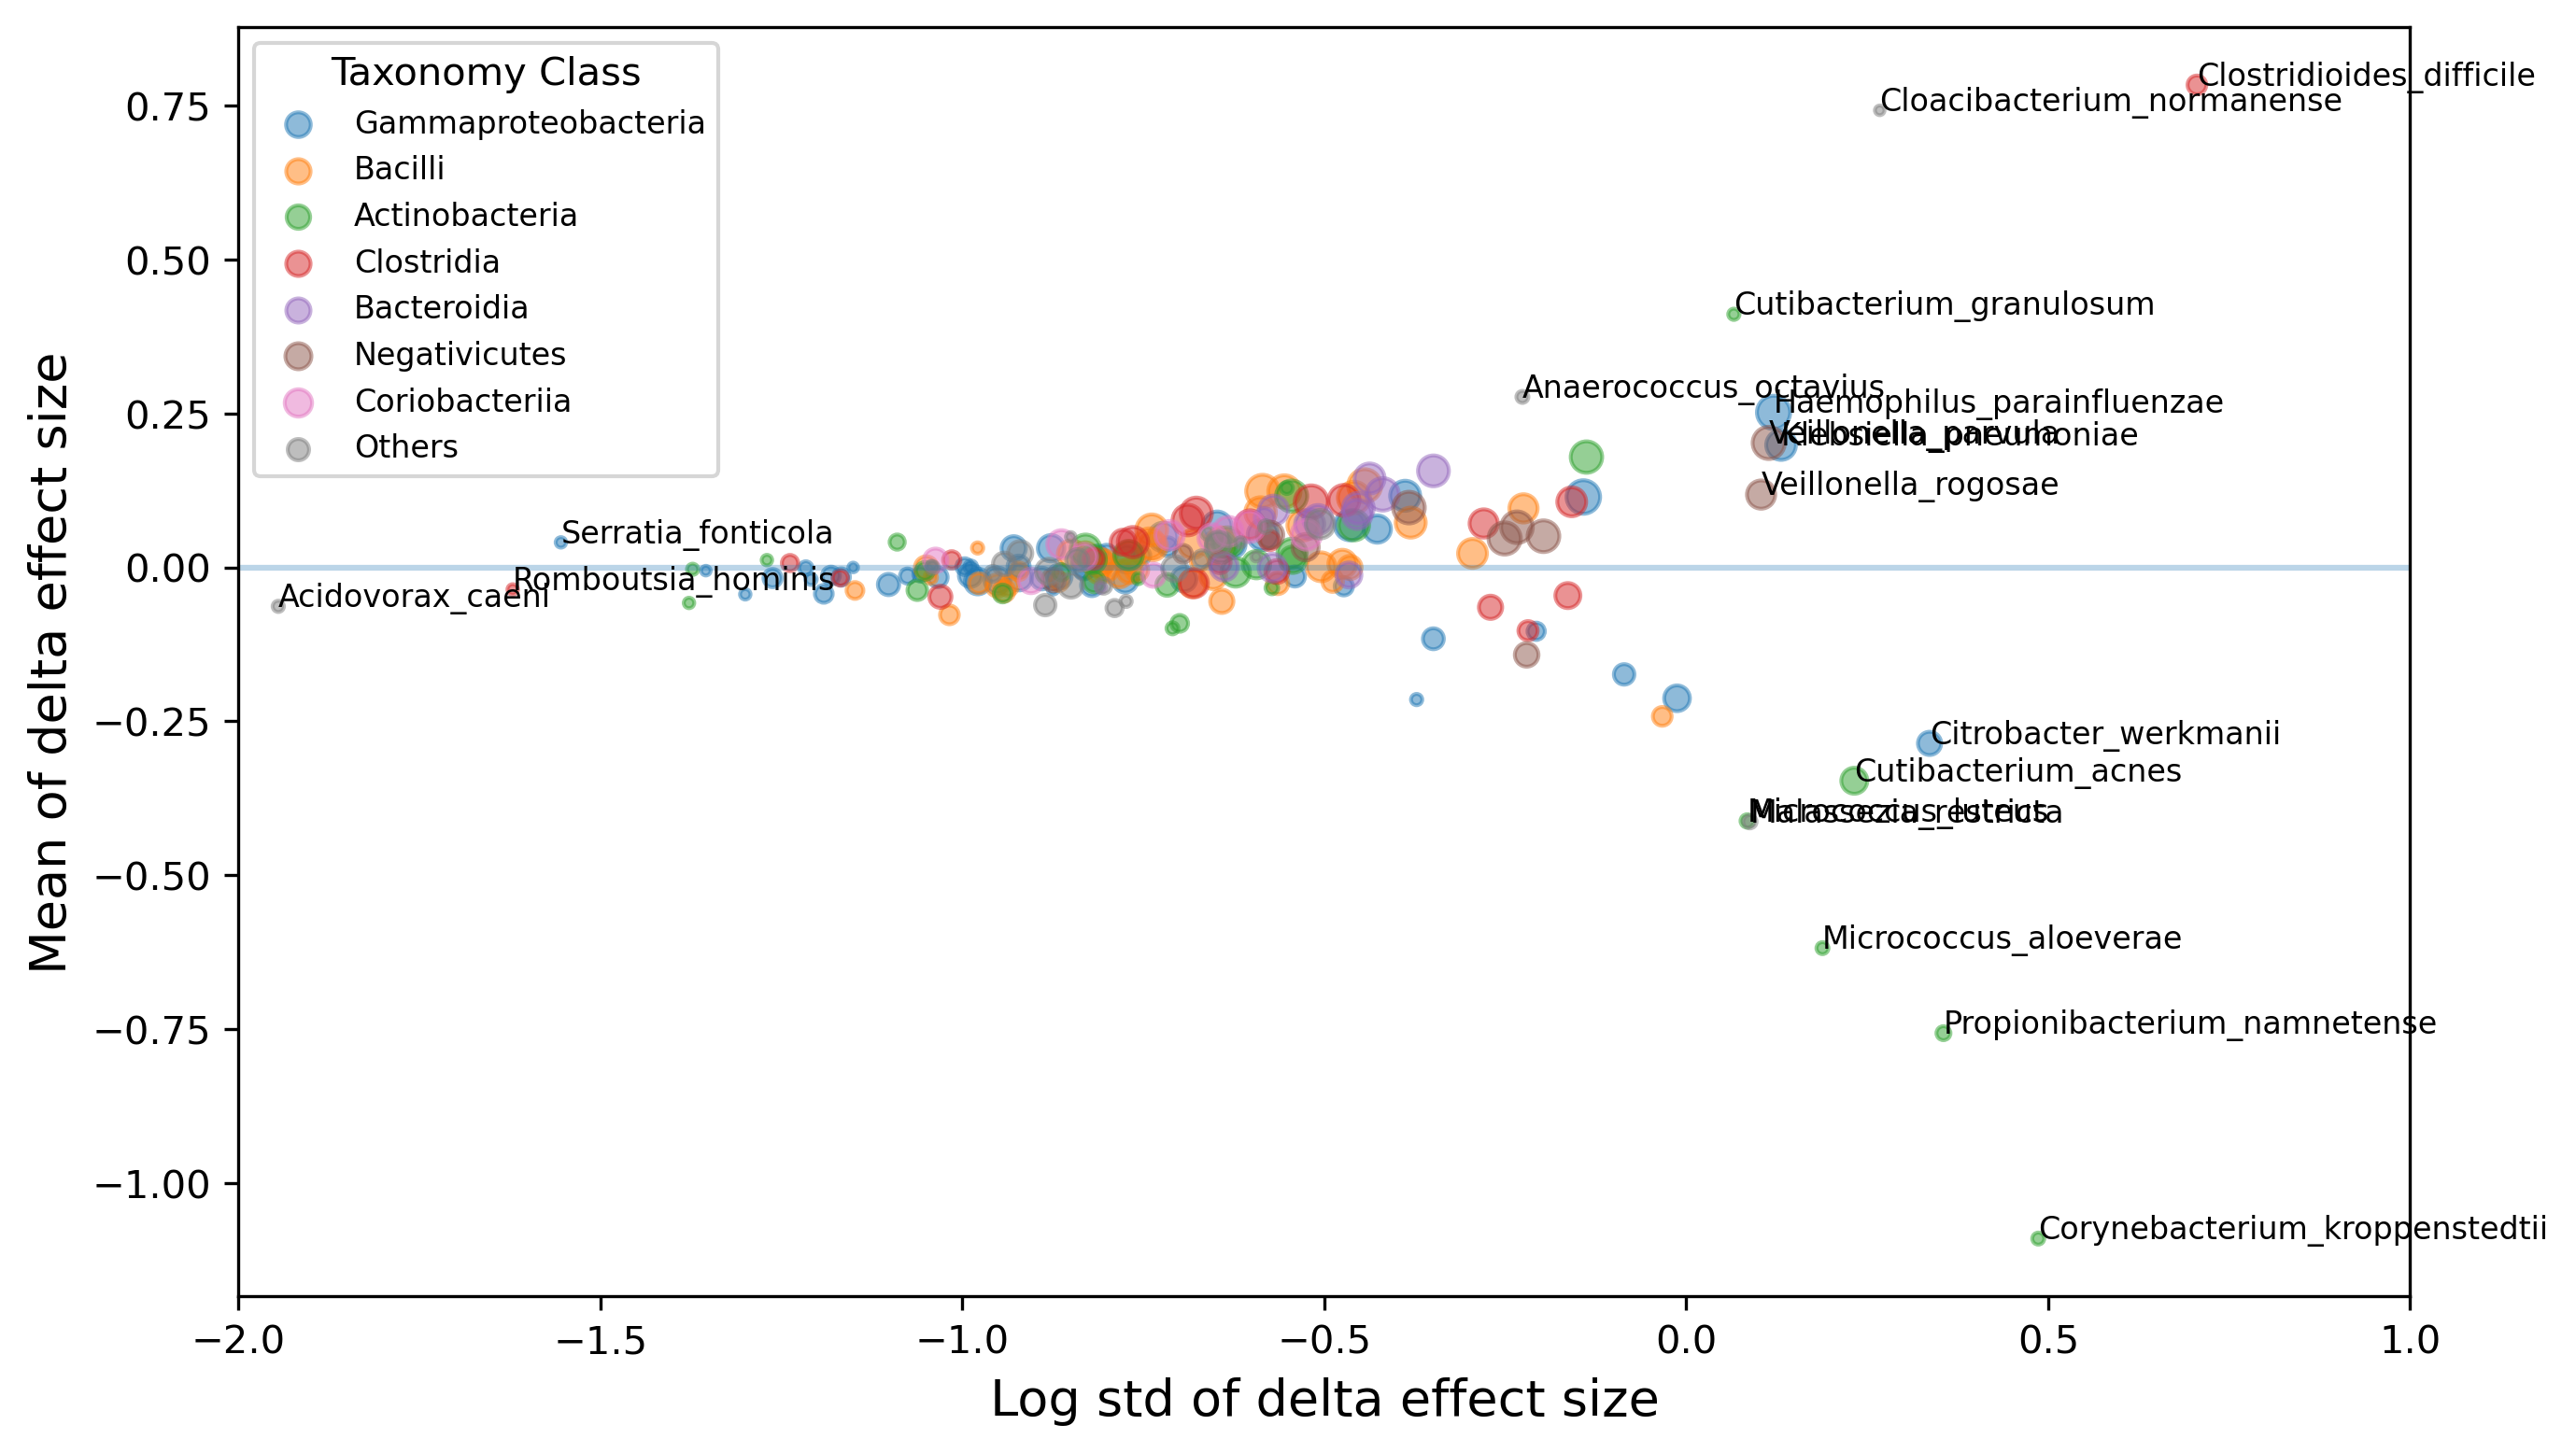

In [20]:
_ = plt.figure(0, (10, 6), dpi=300)
ax = plt.subplot(111)
_ = plt.hlines(xmin=-2, xmax=2, y=0, alpha=0.3)
for l in levels:
    _ = plt.scatter(result.loc[result['Label']==l, 'Std'], result.loc[result['Label']==l, 'Mean'], 
                    s=result.loc[result['Label']==l, 'Ratio']*100+5, label=l, alpha=0.5)    
for i in result.index:
    if result.loc[i, 'Mean']>0.25 or result.loc[i, 'Std']>0 or result.loc[i, 'Mean']<-0.25:
        name = i.split('|s__')[1].strip()
        #if name not in taxas.keys():
        print(name, (result.loc[i, 'Std'], result.loc[i, 'Mean']))
        name, xy = taxa.get(name, [name, (result.loc[i, 'Std'], result.loc[i, 'Mean'])])
        _ = plt.annotate(name, xy, fontsize=8)
_ = plt.legend(fontsize=8, title='Taxonomy Class')
#_ = plt.xlim(-1.8, 1.0)
_ = plt.xlim(-2.0, 1.0)
_ = plt.xlabel("Log std of delta effect size", fontsize=13)
_ = plt.ylabel("Mean of delta effect size", fontsize=13)
plt.savefig('../Results/3.2 主要EffectSize分布.pdf',bbox_inches = 'tight')
_ = plt.show()

#### 3.2 p-value

In [17]:
delta_p = pd.DataFrame()
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    delta_p[project] = -np.log10(taxa_diff["p-value(PSM)"])+np.log10(taxa_diff["p-value(raw)"])

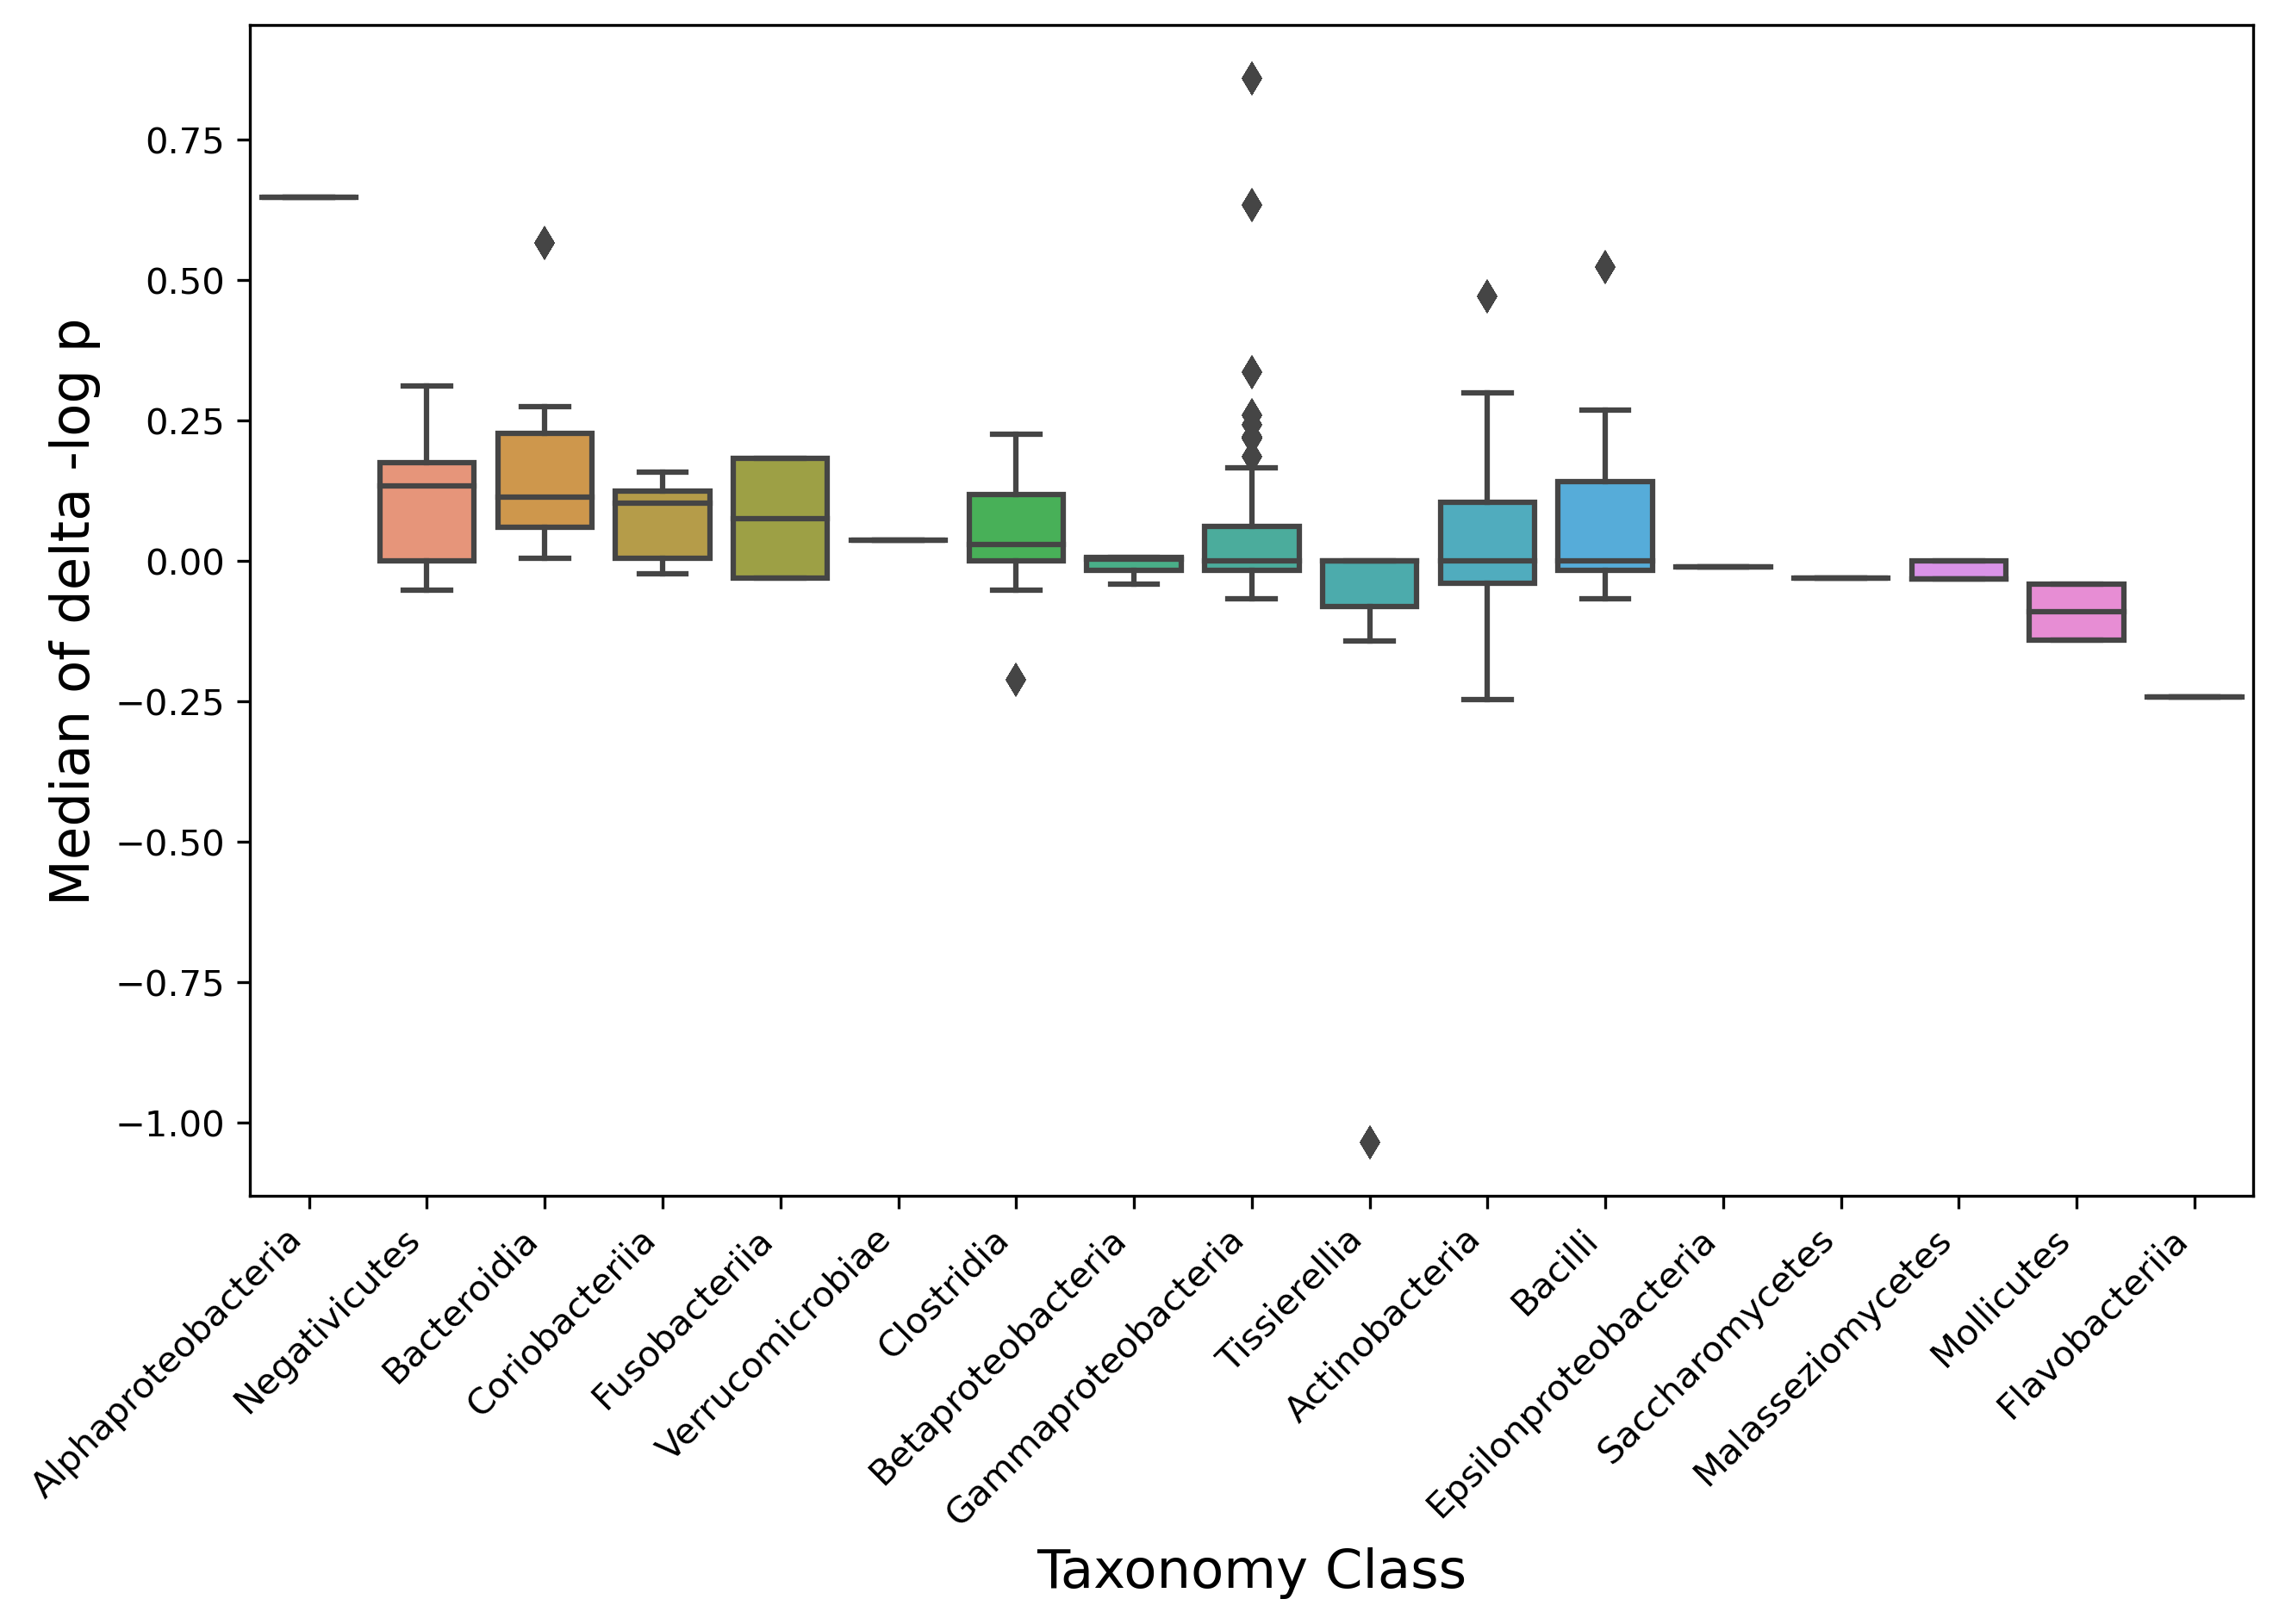

In [18]:
result = []
for taxa in delta_p.index:
    for study in delta_p.columns:
        taxa_class = taxa.split('|c__')[1].split('|o__')[0]
        result.append([taxa, taxa_class, study, delta_p.loc[taxa, :].median()])
result = pd.DataFrame(result, columns=['Taxa', 'Class', 'Study', 'Delta_D'])
order = result.groupby('Class').median().sort_values('Delta_D', ascending=False).index
_ = plt.figure(0, (10, 6), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylabel('Median of delta -log p', fontsize=15)
_ = plt.xlabel('Taxonomy Class', fontsize=15)
#plt.savefig('../Results/3.2.2 pvalue变化.pdf',bbox_inches = 'tight')
_ = plt.show()

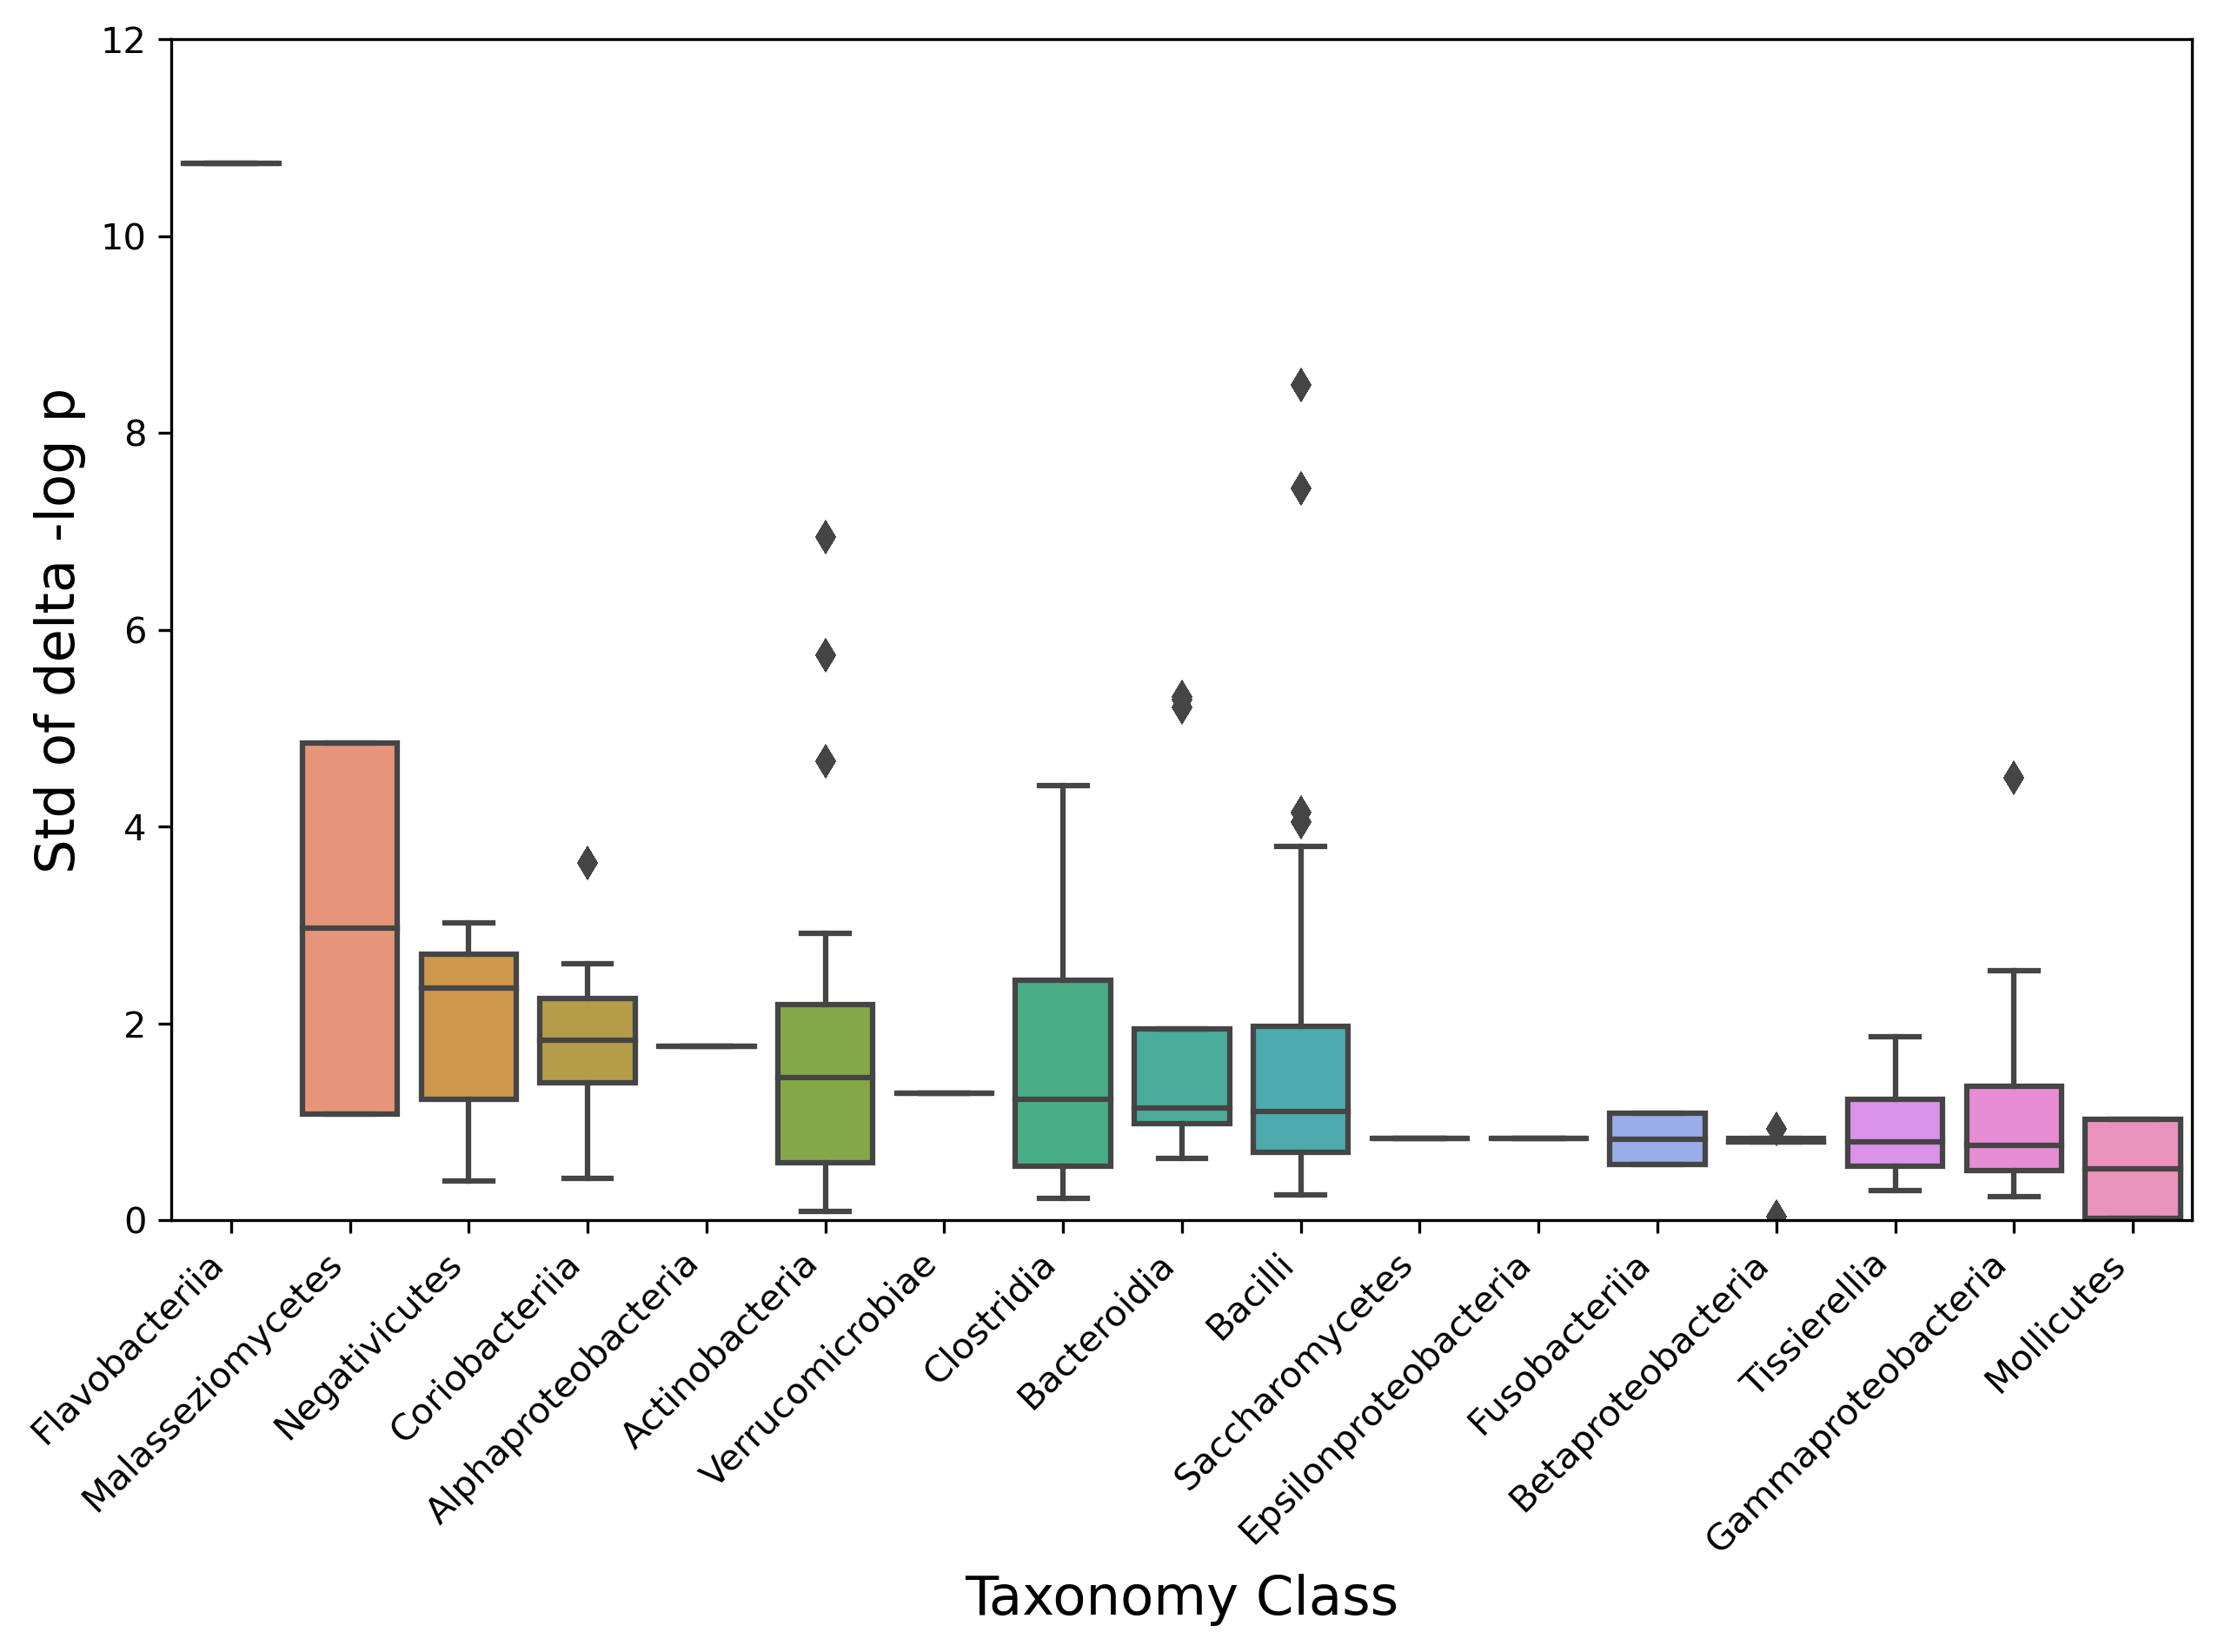

In [19]:
result = []
for taxa in delta_p.index:
    for study in delta_p.columns:
        taxa_class = taxa.split('|c__')[1].split('|o__')[0]
        result.append([taxa, taxa_class, study, delta_p.loc[taxa, :].std()])
result = pd.DataFrame(result, columns=['Taxa', 'Class', 'Study', 'Delta_D'])
order = result.groupby('Class').median().sort_values('Delta_D', ascending=False).index
_ = plt.figure(0, (10, 6), dpi=300)
_ = sns.boxplot(x="Class", y="Delta_D", data=result, order=order)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylim(0, 12)
_ = plt.ylabel('Std of delta -log p', fontsize=15)
_ = plt.xlabel('Taxonomy Class', fontsize=15)
#plt.savefig('../Results/3.2.2 Stdpvalue变化.pdf',bbox_inches = 'tight')
_ = plt.show()

In [20]:
result = pd.DataFrame()
result['Std'] = delta_p.std(1)
result['Min/Max'] = [delta_p.iloc[i, np.argmax(delta_p.iloc[i, :].abs())] for i in range(delta_p.shape[0])]
result['Median'] = delta_p.median(1)
result['Ratio'] = [(delta_p.mean(1)[i]*delta_p.iloc[i, :]>0).sum()/float(delta_p.shape[1]) for i in range(delta_p.shape[0])]
result['Class'] = [i.split('|c__')[1].split('|o__')[0] for i in delta_p.index]
taxa = result.groupby(['Class']).size().sort_values(ascending=False)
levels = []
for i in taxa.index:
    if taxa[i]>=10:
        result.loc[result['Class']==i, 'Label']=i
        levels.append(i)
    else:
        result.loc[result['Class']==i, 'Label']='Others'
levels.append('Others')
result.head()


Std    Min/Max  \
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  13.993252  39.624363   
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|...  10.735357  23.789115   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...   2.246881  -7.175300   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...   6.937668  50.705544   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...   4.666502  15.422543   

                                                      Median     Ratio  \
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  0.005927  0.045455   
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|... -0.242011  0.011364   
k__Bacteria|p__Actinobacteria|c__Actinobacteria... -0.193675  0.068182   
k__Bacteria|p__Actinobacteria|c__Actinobacteria... -0.013512  0.250000   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  0.000000  0.045455   

                                                             Class  \
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|...  Flavobacteriia   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria   

                                                             Label  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria  
k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|...          Others  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria  
k__Bacteria|p__Actinobacteria|c__Actinobacteria...  Actinobacteria

['Gammaproteobacteria',
 'Bacilli',
 'Actinobacteria',
 'Clostridia',
 'Bacteroidia',
 'Negativicutes',
 'Coriobacteriia',
 'Others']

<AxesSubplot:xlabel='Std', ylabel='Density'>

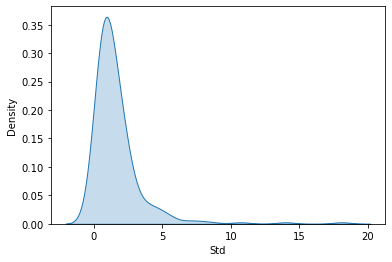

In [21]:
levels
std=result['Std']
sns.kdeplot(std, shade=True)

Corynebacterium_kroppenstedtii (13.993252261712543, 0.005927377536060208)
Cloacibacterium_normanense (10.735356691773069, -0.24201067899185913)
Cutibacterium_acnes (6.937668360858485, -0.01351242305750125)
Staphylococcus_capitis (8.483074818994343, -0.016449441493911133)
Bacteroides_caccae (5.319606029554556, 0.22715070960280237)
Cutibacterium_granulosum (18.100036865911676, 0.2995048153083326)
Bacteroides_fragilis (5.285644396219933, 0.2260976647373385)
Bacteroides_thetaiotaomicron (5.211148914859569, 0.004997629124896097)
Staphylococcus_epidermidis (7.435745294991502, -0.060129018004242474)
Micrococcus_aloeverae (5.739976872396741, -0.21353524787582648)
Anaerococcus_octavius (1.6654564137770433, -1.034897810593984)
Mixta_calida (0.39066515040615407, 0.8599868043120609)
Serratia_fonticola (0.2432702771585231, 0.6345147468447524)
Roseomonas_mucosa (1.7648032020696434, 0.6486532204326363)
Romboutsia_hominis (0.22508844653166002, -0.2111778571782281)
Corynebacterium_tuberculostearicum (0

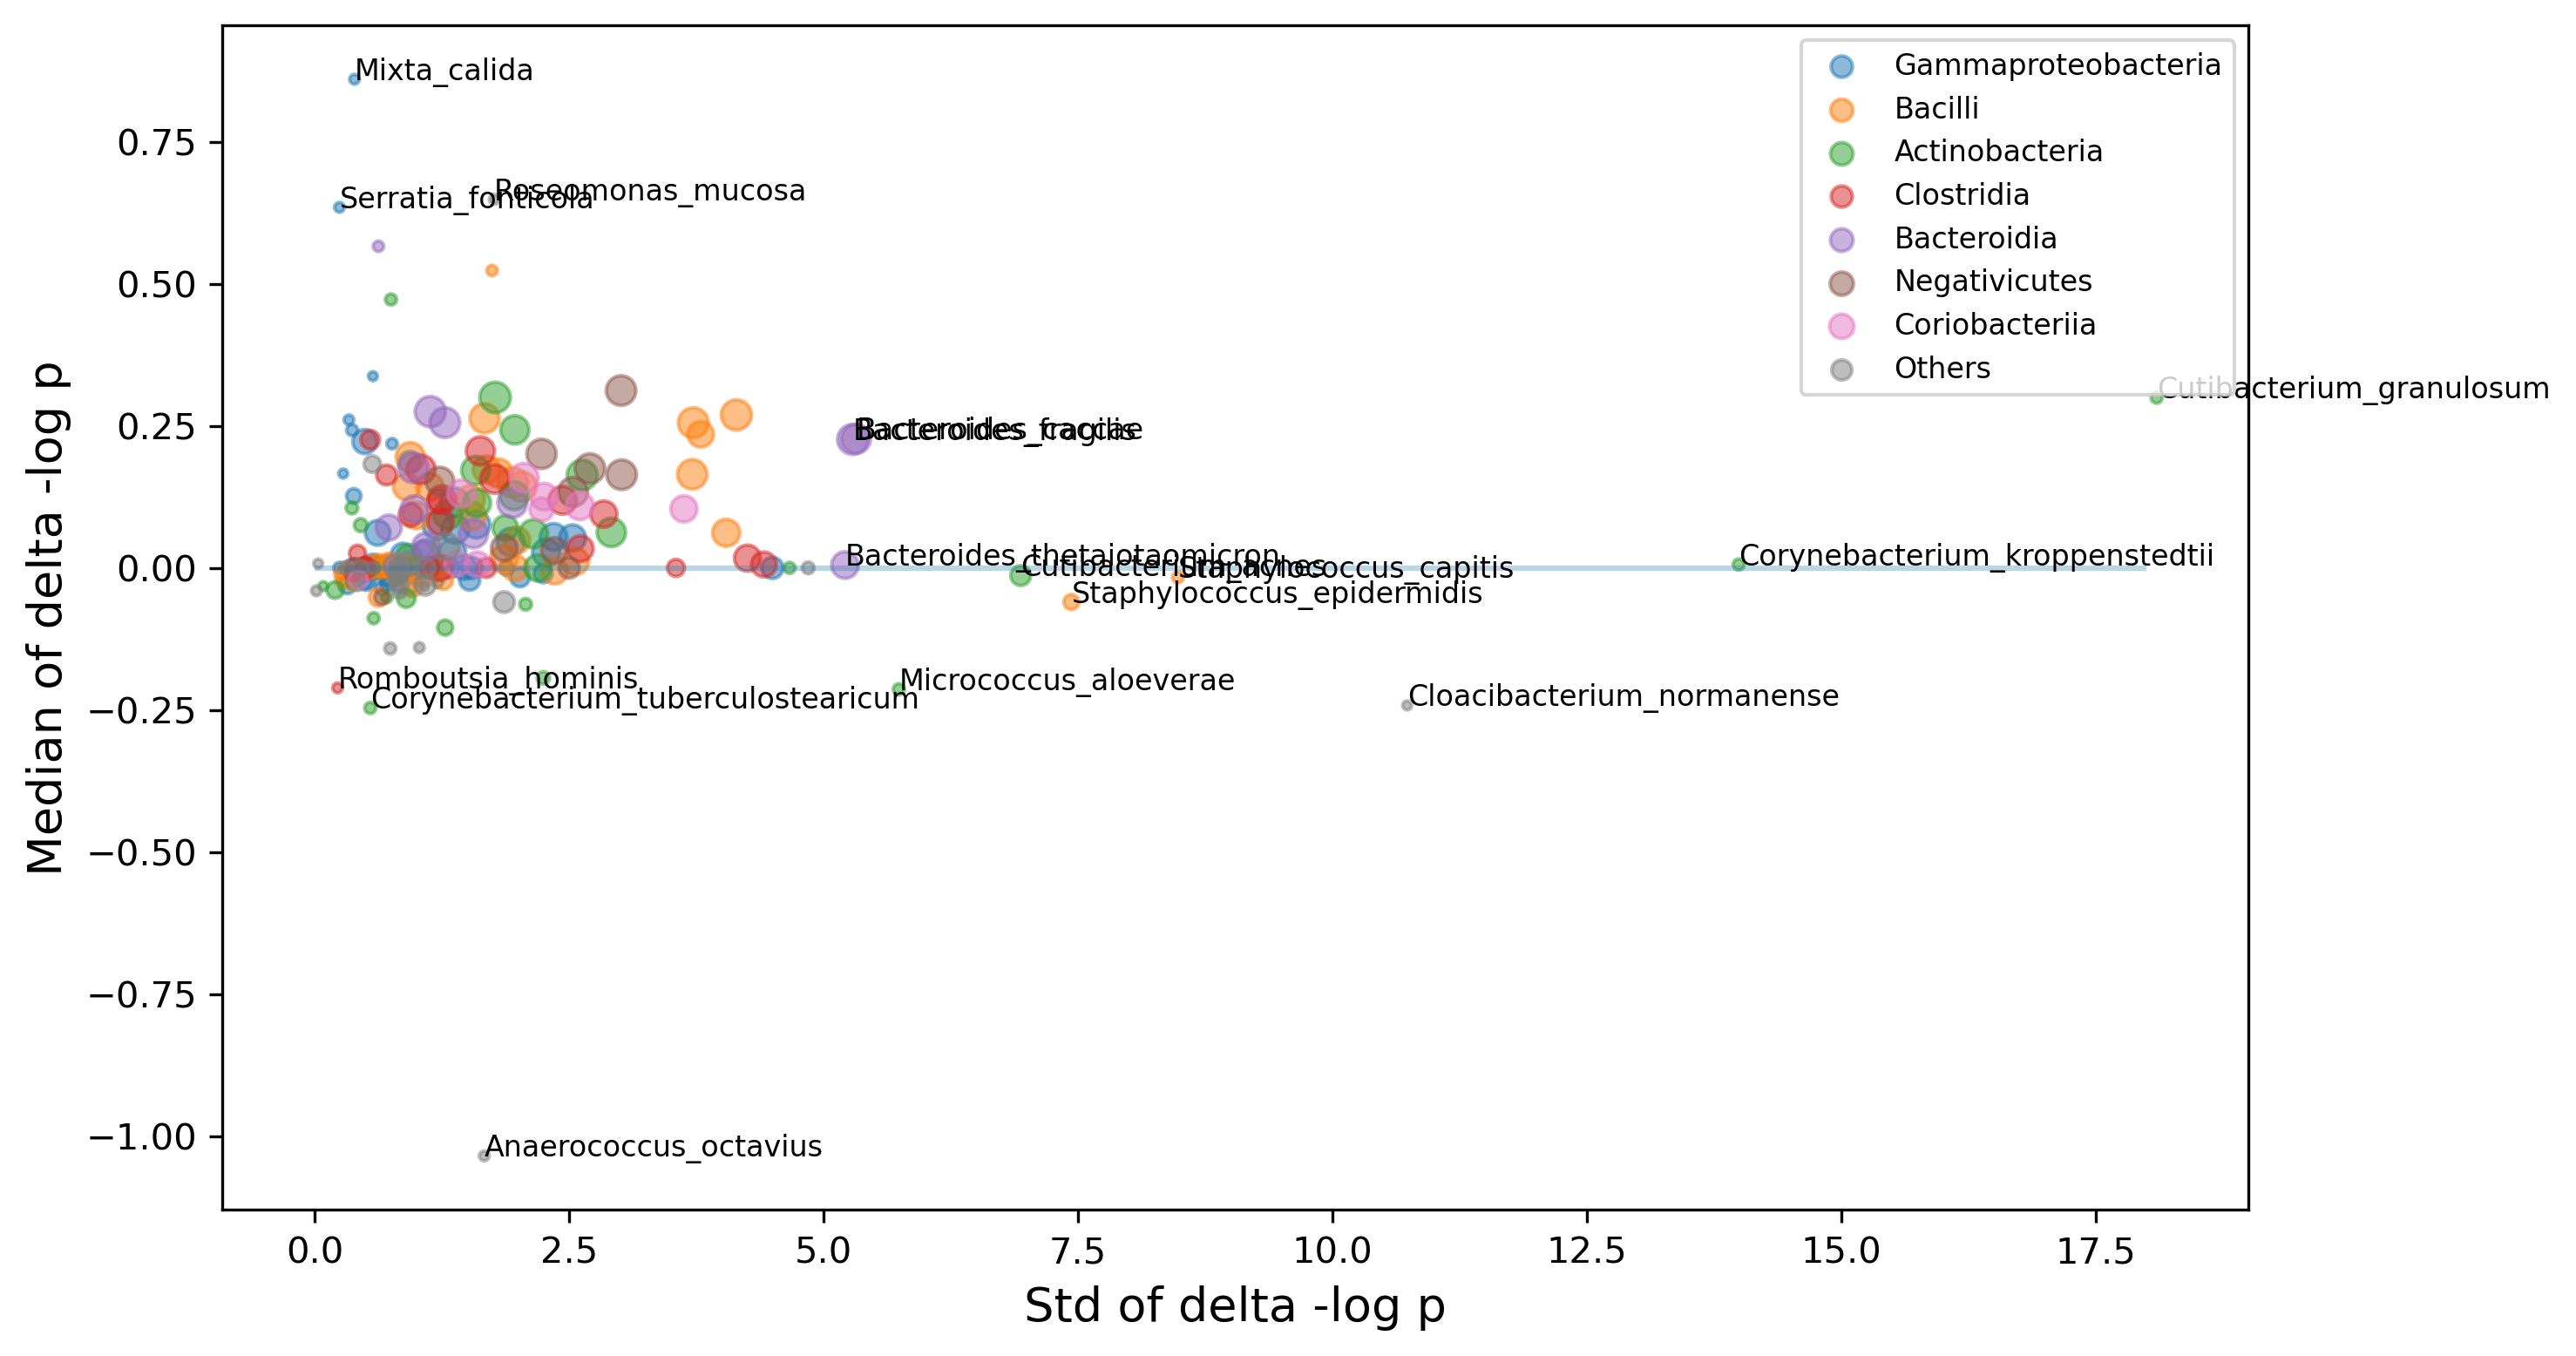

In [26]:
_ = plt.figure(0, (10, 6), dpi=300)
ax = plt.subplot(111)
_ = plt.hlines(xmin=0, xmax=18, y=0, alpha=0.3)
for l in levels:
    _ = plt.scatter(result.loc[result['Label']==l, 'Std'], result.loc[result['Label']==l, 'Median'], 
                    s=result.loc[result['Label']==l, 'Ratio']*100+5, label=l, alpha=0.5)
for i in result.index:
    if result.loc[i, 'Median']>0.6 or result.loc[i, 'Std']>5 or result.loc[i, 'Median']<-0.2:
        name = i.split('|s__')[1].strip()
        #if name not in taxas.keys():
        print(name, (result.loc[i, 'Std'], result.loc[i, 'Median']))
        name, xy = taxa.get(name, [name, (result.loc[i, 'Std'], result.loc[i, 'Median'])])
        _ = plt.annotate(name, xy, fontsize=8)
    
_ = plt.legend(fontsize=8)
#_ = plt.xlim(-1.8, 0)
_ = plt.xlabel("Std of delta -log p", fontsize=13)
_ = plt.ylabel("Median of delta -log p", fontsize=13)
#plt.savefig('../Results/3.主图pvalue分布.pdf',bbox_inches = 'tight')
_ = plt.show()